<a href="https://colab.research.google.com/github/rastehNili/linearRegression/blob/master/sharingBikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loading Modules**

In [4]:
! pip3 install "texttable"

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import Javascript
from google.colab import drive
import scipy.stats as stats
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.core.tools.numeric import to_numeric
from sklearn.metrics import r2_score, mean_squared_error
from texttable import Texttable
from copy import copy
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot

warnings.filterwarnings(action='ignore')

## **Loading Data**

In [6]:
# mount to the colab
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
ROOT = "/content/drive/MyDrive/upgrad/2.MachineLearning1/data"

df = pd.read_csv(f"{ROOT}/day.csv")
print(df.head())
print(df.tail())

   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
     instant      dteday  

In [8]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None
(730, 16)


In [9]:
# =========================================
# Dataset characteristics
# =========================================
# day.csv have the following fields:

# 	- instant: record index
# 	- dteday : date
# 	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
# 	- yr : year (0: 2018, 1:2019)
# 	- mnth : month ( 1 to 12)
# 	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
# 	- weekday : day of the week
# 	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
# 	+ weathersit :
# 		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
# 	- temp : temperature in Celsius
# 	- atemp: feeling temperature in Celsius
# 	- hum: humidity
# 	- windspeed: wind speed
# 	- casual: count of casual users
# 	- registered: count of registered users
# 	- cnt: count of total rental bikes including both casual and registered

# =========================================
# License
# =========================================
# Use of this dataset in publications must be cited to the following publication:

# [1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

# @article{
# 	year={2013},
# 	issn={2192-6352},
# 	journal={Progress in Artificial Intelligence},
# 	doi={10.1007/s13748-013-0040-3},
# 	title={Event labeling combining ensemble detectors and background knowledge},
# 	url={http://dx.doi.org/10.1007/s13748-013-0040-3},
# 	publisher={Springer Berlin Heidelberg},
# 	keywords={Event labeling; Event detection; Ensemble learning; Background knowledge},
# 	author={Fanaee-T, Hadi and Gama, Joao},
# 	pages={1-15}
# }

# =========================================
# Contact
# =========================================

# For further information about this dataset please contact Hadi Fanaee-T (hadi.fanaee@fe.up.pt)


## **Cleaning Data**

Check percentages of missing values in each column:

In [10]:
percNaDf = (df.isnull().sum()/df.shape[0])*100
print(percNaDf[percNaDf>0])

# check presence of blank rows
null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]

print(null_rows)

Series([], dtype: float64)
Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []


Identify low variant columns:

All the low variant columns are actually categorical columns so we will not remove them. Only generate appropriate dummy variables for them.

In [11]:
variantDf = df.nunique().sort_values()
variantDf

yr              2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
mnth           12
temp          498
hum           594
casual        605
windspeed     649
registered    678
atemp         689
cnt           695
instant       730
dteday        730
dtype: int64

Find number of unique values:

In [12]:
df.nunique().sort_values(ascending=False)

instant       730
dteday        730
cnt           695
atemp         689
registered    678
windspeed     649
casual        605
hum           594
temp          498
mnth           12
weekday         7
season          4
weathersit      3
yr              2
holiday         2
workingday      2
dtype: int64

instant and dteday are variables that all the values are being unique.  So both of them can be used as the identifier. I will keep instant and make more features by spliting dteday column. Since year and month are already included in the dataframe we use only the day of the month from that column.

In [13]:
# df["dteday"] = pd.to_datetime(df["dteday"], format='%y%m%d')
df["day"] = df["dteday"].apply(lambda x:x.split("-")[0])
df["day"] = to_numeric(df["day"])
df.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  day  
0   985    1  
1   801    2  
2  1349    3  
3  1562    4  
4  1600    5

## **Data Preparation:**

At this stage we identify categorical variable and generate proper dummy variable for them.

Months and weekday are considered as ordinal variables that no mathematical operation is meaningful between them. So they are considered as categorical variables. While day is considered interval variable that have some order. So mathematical differences between them is meaningful and they can be considered as numerical values.
Column 'yr' with two values 0 and 1 indicating the years 2018 and 2019 respectively.

In [14]:
df1 = copy(df)

season_map = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
df1["season"] = df1["season"].map(season_map)
season_dum=pd.get_dummies(df1["season"],drop_first=True)

weather_map = {1: "clear", 2:"mist", 3:"light_rain", 4:"heavy_rain"}
df1["weathersit"] = df1["weathersit"].map(weather_map)
weather_dum=pd.get_dummies(df1["weathersit"],drop_first=True)

weekday_map = {0: "sunday", 1:"monday", 2:"tuesday", 3:"wednesday",
               4:"thurseday", 5:"friday", 6:"saturday"}
df1["weekday"] = df1["weekday"].map(weekday_map)
weekday_dum=pd.get_dummies(df1["weekday"],drop_first=True)

mnth_map = {1: "Jan", 2:"Feb", 3:"Mar", 4:"Apr",
               5:"May", 6:"Jun", 7:"July", 8:"Aug",
               9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
df1["mnth"] = df1["mnth"].map(mnth_map)
mnth_dum=pd.get_dummies(df1["mnth"],drop_first=True)

work_map = {0: "Weekend/Holiday", 1:"Working day"}
df1["workingday"] = df1["workingday"].map(work_map)

year_map = {0: "2018", 1:"2019"}
df1["yr"] = df1["yr"].map(year_map)

holiday_map = {0: "Not Holiday", 1:"Holiday"}
df1["holiday"] = df1["holiday"].map(holiday_map)

## **Univariate Analysis**

**1. For Numerical variables**: Get general idea about all the numerical variables by using descrption function

In [15]:
df2 = pd.concat([df, season_dum, weather_dum, mnth_dum, weekday_dum], axis=1)
numericalCols = ["temp", "atemp", "hum", "windspeed", "day", "cnt"]

print(df1[numericalCols].describe())
df2 = df2.drop(["instant", "weathersit", "dteday", "season", "casual", "registered", "mnth", "weekday", 'casual', "registered"], axis=1)
print("\n", df2.columns)

             temp       atemp         hum   windspeed         day          cnt
count  730.000000  730.000000  730.000000  730.000000  730.000000   730.000000
mean    20.319259   23.726322   62.765175   12.763620   15.720548  4508.006849
std      7.506729    8.150308   14.237589    5.195841    8.802278  1936.011647
min      2.424346    3.953480    0.000000    1.500244    1.000000    22.000000
25%     13.811885   16.889713   52.000000    9.041650    8.000000  3169.750000
50%     20.465826   24.368225   62.625000   12.125325   16.000000  4548.500000
75%     26.880615   30.445775   72.989575   15.625589   23.000000  5966.000000
max     35.328347   42.044800   97.250000   34.000021   31.000000  8714.000000

 Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'day', 'spring', 'summer', 'winter', 'light_rain', 'mist', 'Aug',
       'Dec', 'Feb', 'Jan', 'July', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep',
       'monday', 'saturday', 'sunday', 'thurseday', 't

Distribution of the data and possible outliers in each of these variables will be investigated by histogram and box plot.

In [16]:
def dist_investigate(data, label):
  plt.figure(figsize=(16,4))

  plt.subplot(1,2,1)
  sns.distplot(data)
  plt.xlabel(label)

  plt.subplot(1,2,2)
  sns.boxplot(data)
  plt.xlabel(label)

  plt.gca().set_xticklabels([])
  plt.suptitle(label, fontsize=20, fontweight="bold")
  plt.show()

<IPython.core.display.Javascript object>

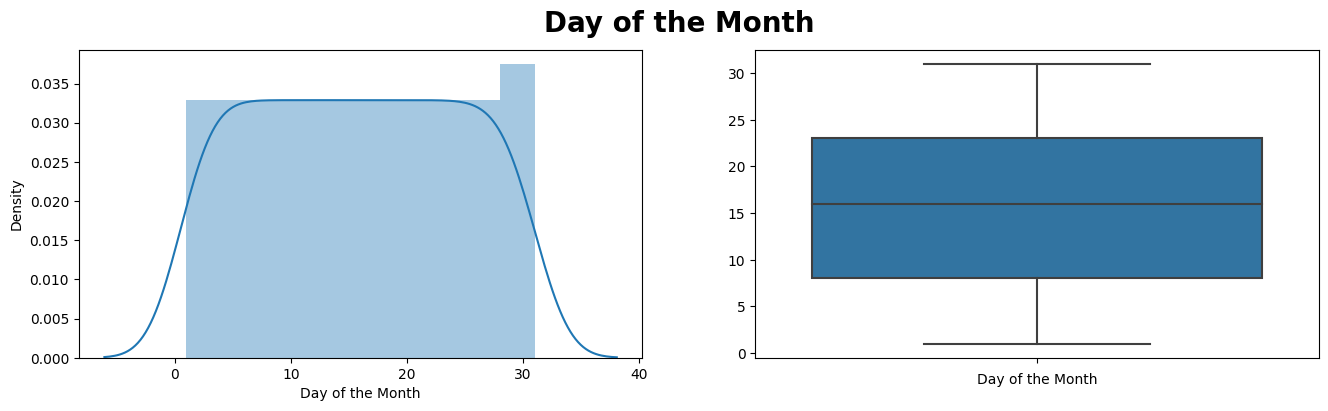

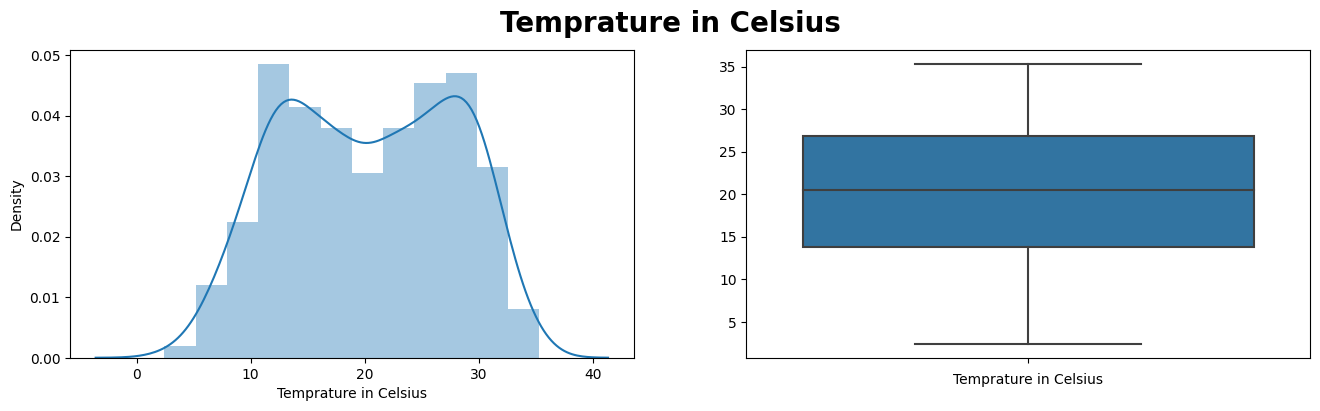

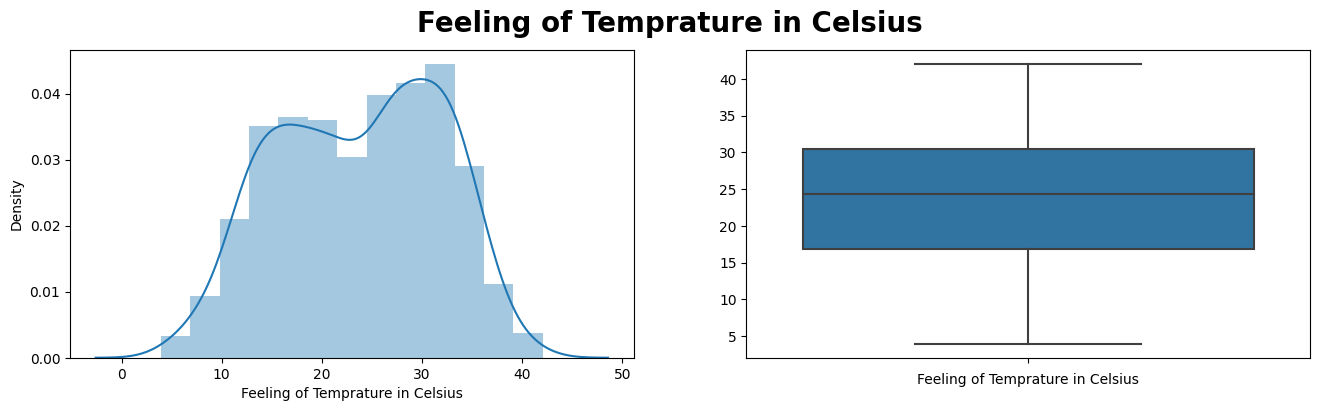

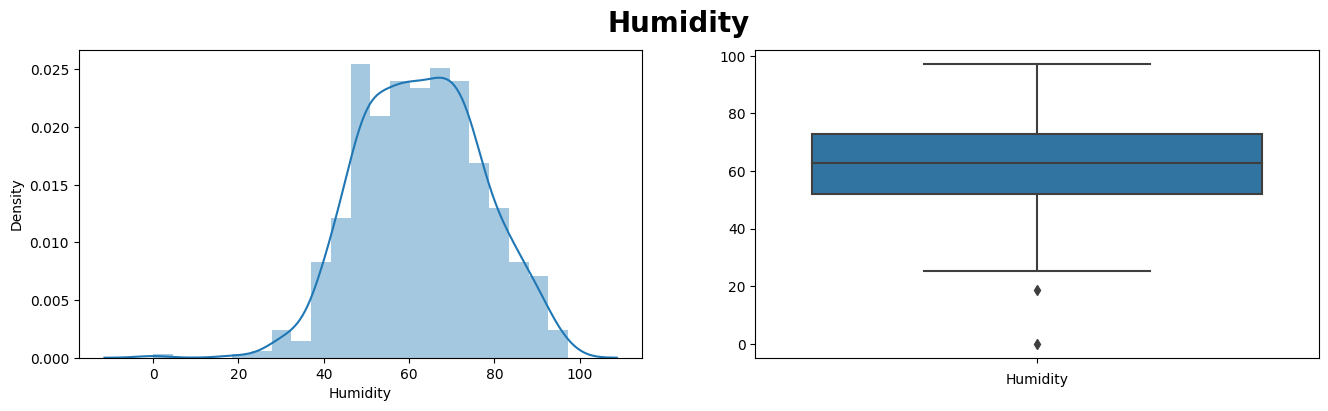

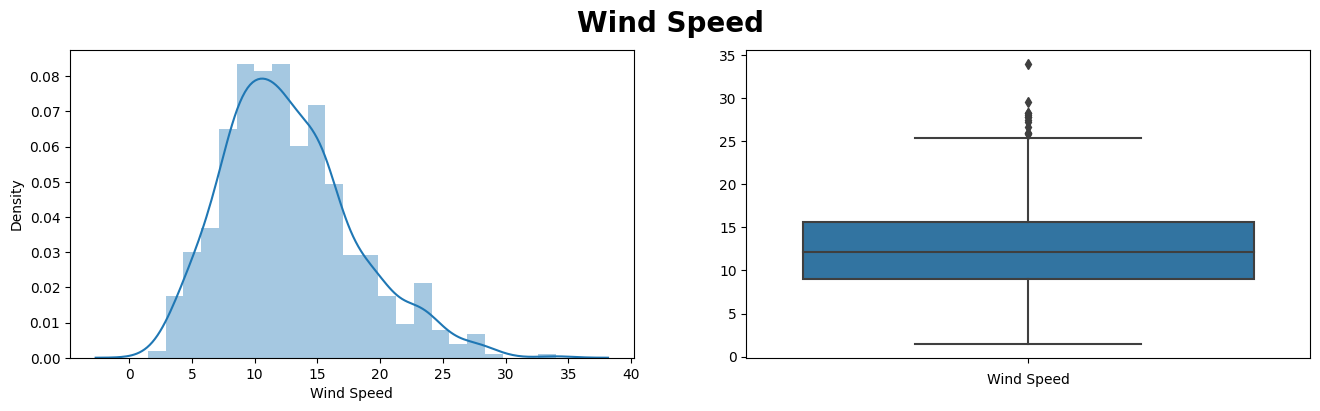

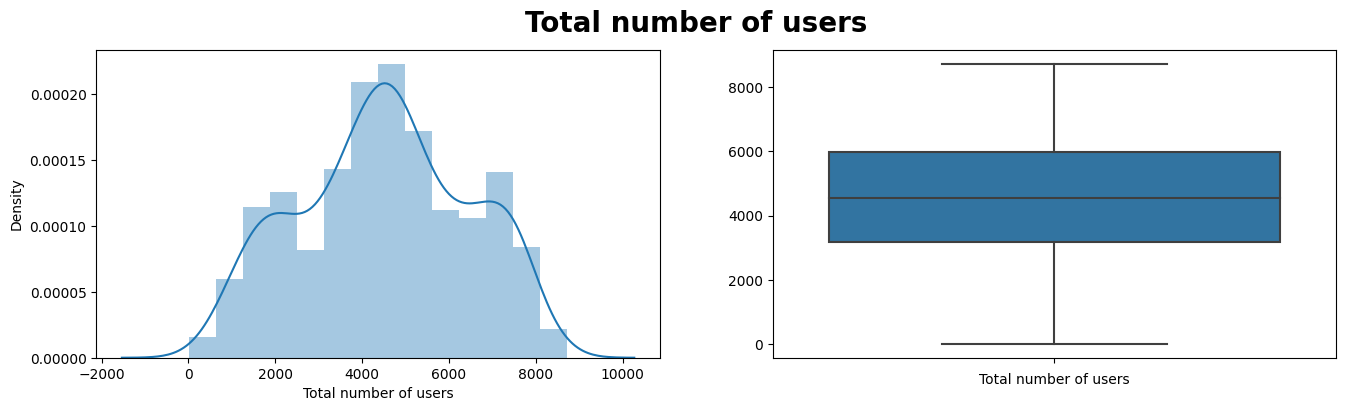

In [17]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

continuesDict = {"Day of the Month":"day", "Temprature in Celsius":"temp",
                 "Feeling of Temprature in Celsius":"atemp", "Humidity":"hum",
                 "Wind Speed":"windspeed", "Total number of users":"cnt"}

for k in continuesDict.keys():
  dist_investigate(df2[continuesDict[k]], k)

1. The uniformal distribution of number of users based at different days of the month is showing that the usage of the bikes are equal across all the days in the month with exception of last days. This is because only some months has day 31 that would cause a jump at the end of the month in number of bike users.  

2. There is binomila distribution for temprature and feeling temprature

3. the distribution of registered ratio and casual ration is very similar, but since both can be user as the outcome of the model we keep them for now.

## **Outlier Removal**

There are some features such as Humidity, wind speed and registered that have some extream values but based on the nature of these data neither of them can be considered as outlier.

### **2. For categorical variables**: We would get general idea about all the categorical variables by using pie chart combined with bar chart

In [18]:
def countPlots(data, target, title):

  porcent = data[target].value_counts(normalize=True)*100
  labels = data[target].unique()

  plt.figure(figsize=(16,4))
  plt.subplot(1,2,1)
  sns.countplot(x=target, data=data, dodge=True, palette="mako_r")
  plt.tick_params(axis='x', rotation=90)

  plt.subplot(1,2,2)
  patches, texts = plt.pie(porcent, radius=1.5)
  labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(porcent.index, porcent)]

  sort_legend = True
  if sort_legend:
      patches, labels, dummy =  zip(*sorted(zip(patches, labels, porcent),
                                            key=lambda x: x[2],
                                            reverse=True))

  plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
            fontsize=8)

  plt.suptitle(title, fontsize=20, fontweight="bold")
  plt.show()


<IPython.core.display.Javascript object>

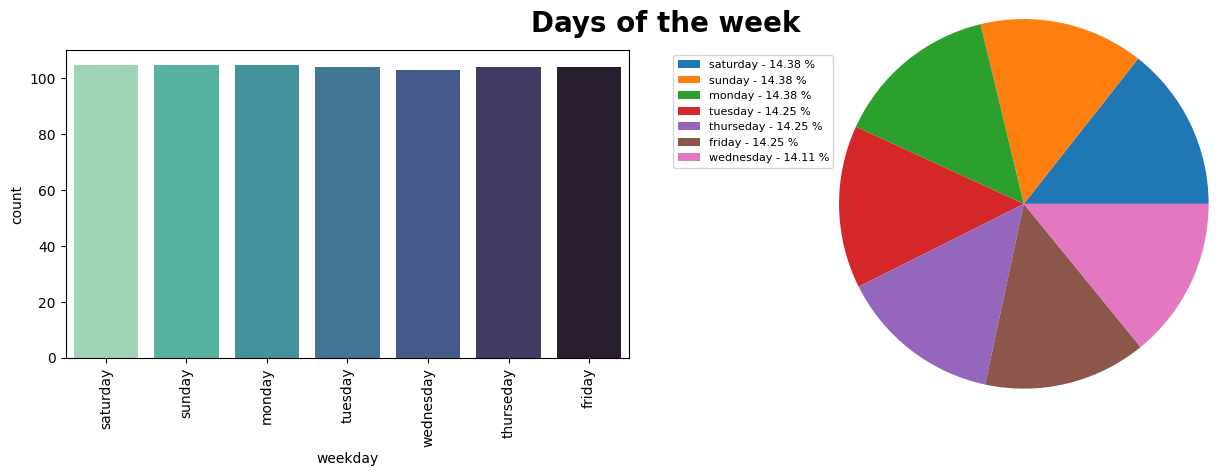

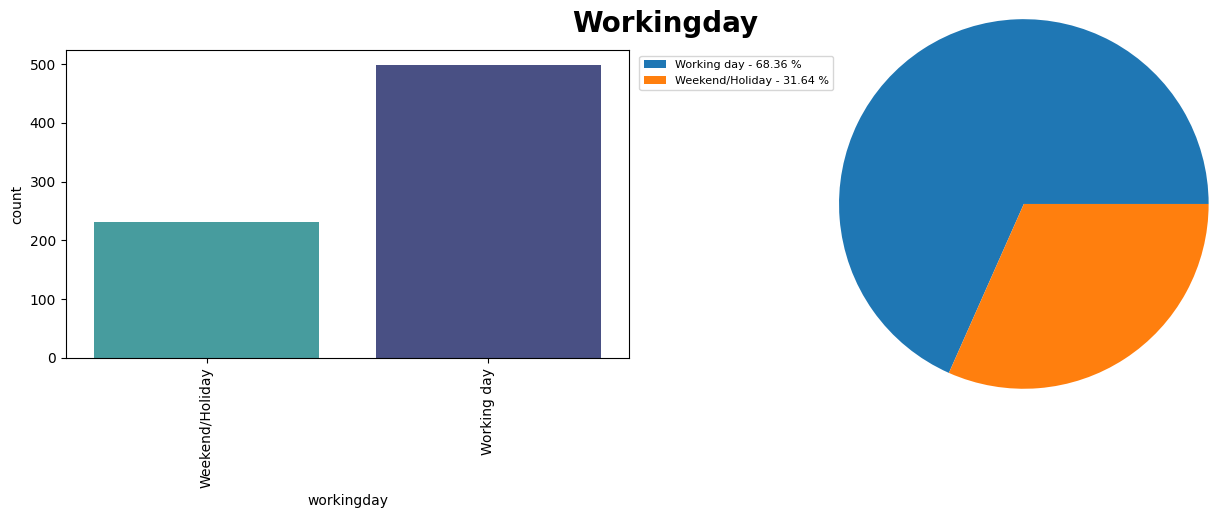

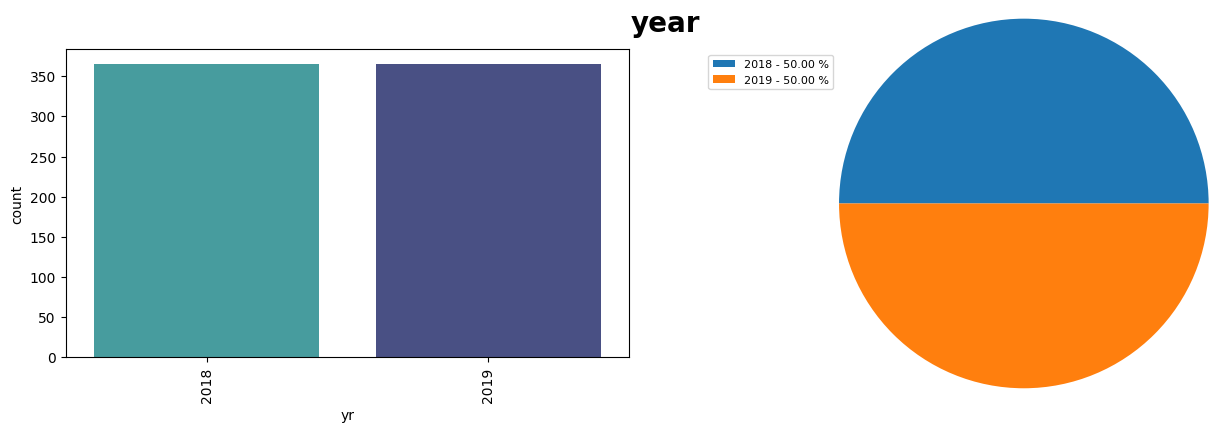

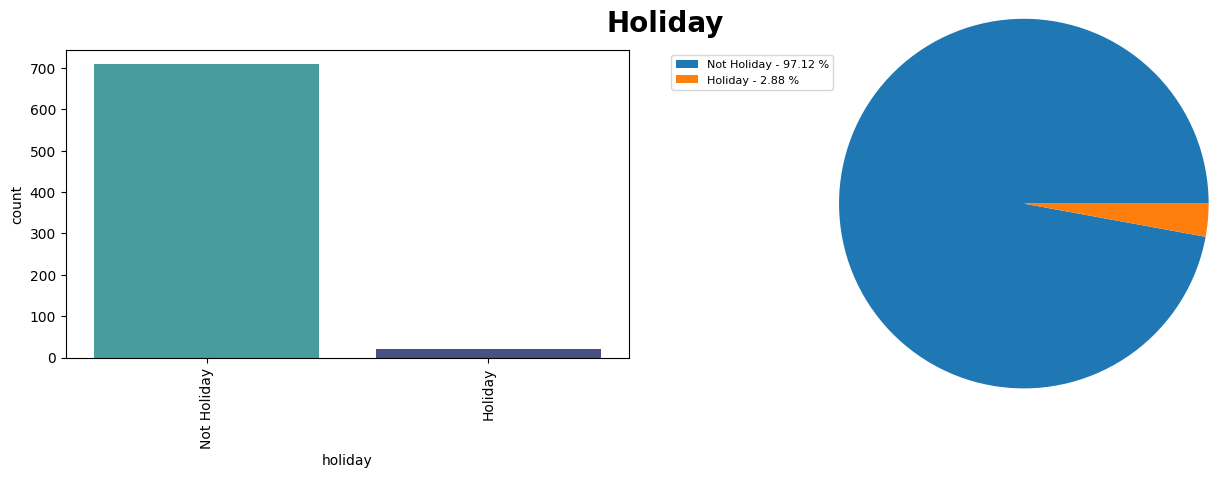

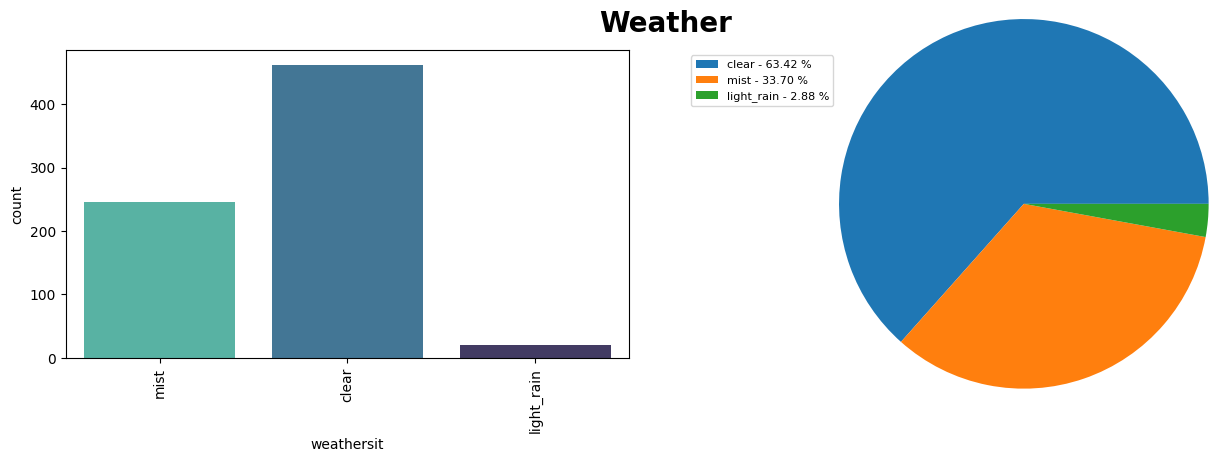

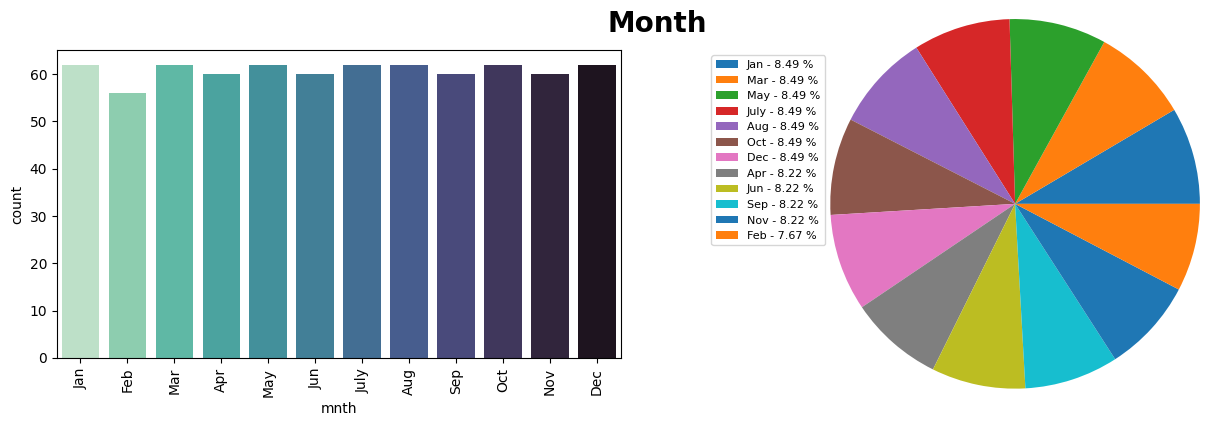

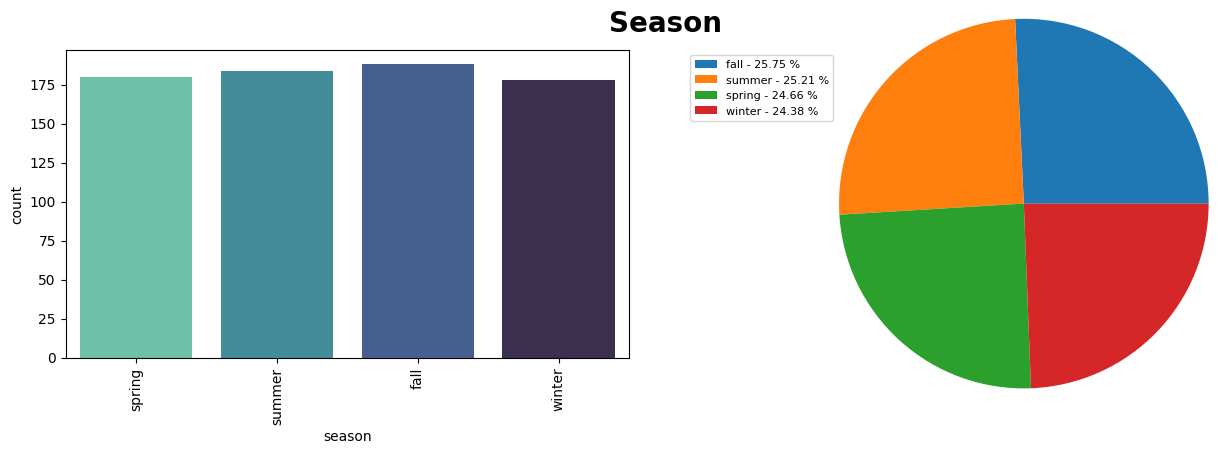

In [19]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

categoricalCols = list(set(df1.columns) - set(numericalCols+["instant", "dteday"]))

categoricalDict1 = {"Days of the week":"weekday", "Workingday": "workingday", "year":"yr",
                    "Holiday": "holiday", "Weather":"weathersit", "Month":"mnth", "Season":"season"}


for k in categoricalDict1.keys():
  countPlots(df1, categoricalDict1[k], k)

The result indicates that:
1. only abot 3% of the days are holiday
2. More than 68% of them are working days
3. only about 35 of the days been rainy and it was light rain
4. There is no heavy rain day.
5. there are more days in Fall and summer
6. slightly more saturdays, sundays and mondays in comparison with other days


 **Segmented Univariate Analysis**


The only interesting relationship in segmented categorical values is the relationship between weather and holiday, and working days. So in this part I just investigate how many of the non working days are having good weather as well.

In [20]:
def segment_barplot(data, x, col, title):
  from itertools import product
  plt.figure(figsize=(16,3))

  ax = sns.countplot(x=x, hue=col, data=data)

  for container in ax.containers:
    labels = [f'{h/data[col].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge')

  plt.suptitle(title, fontsize=20, fontweight="bold")
  plt.tick_params(axis='x', rotation=90)
  plt.ylabel("Percentage")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

<IPython.core.display.Javascript object>

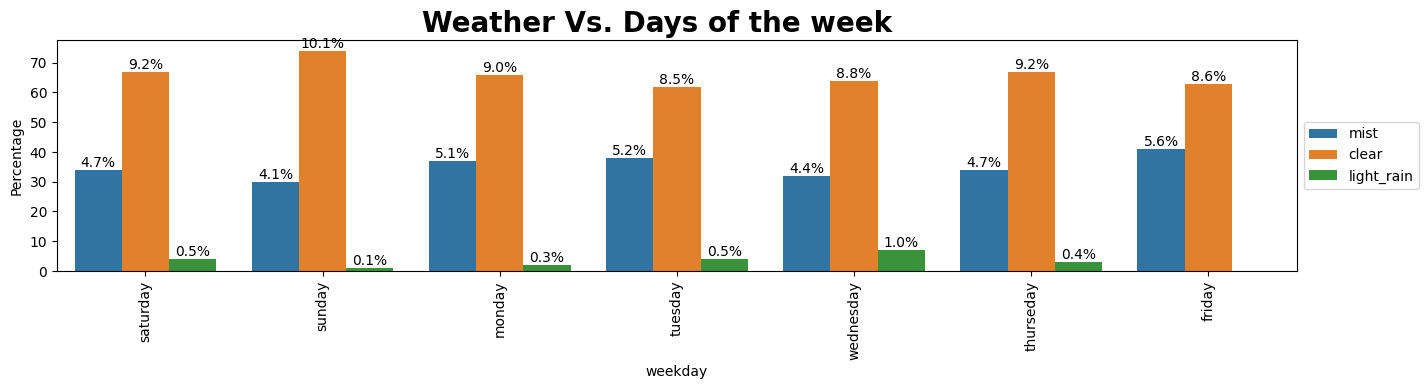

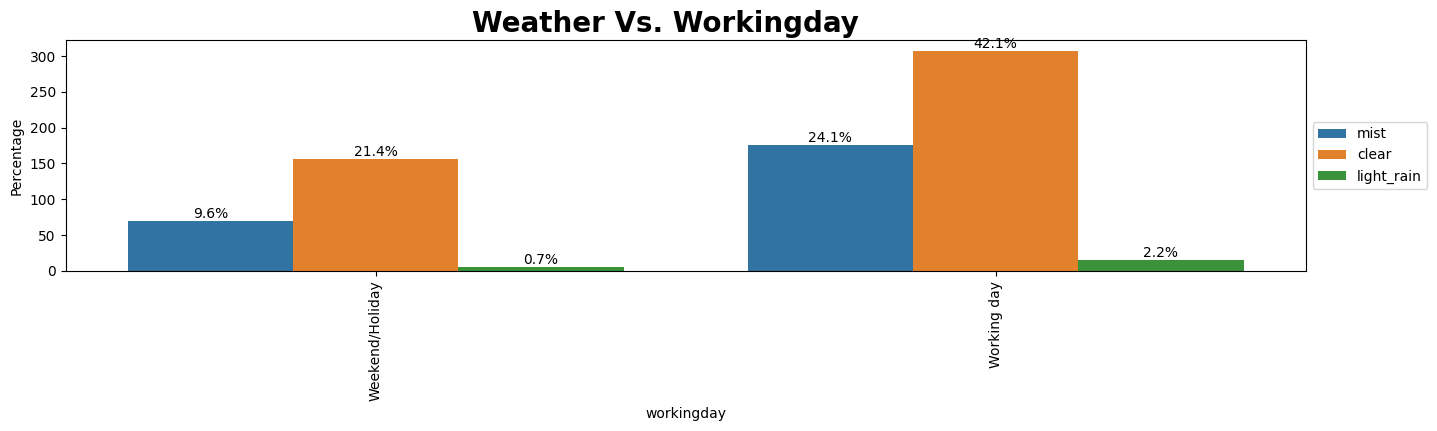

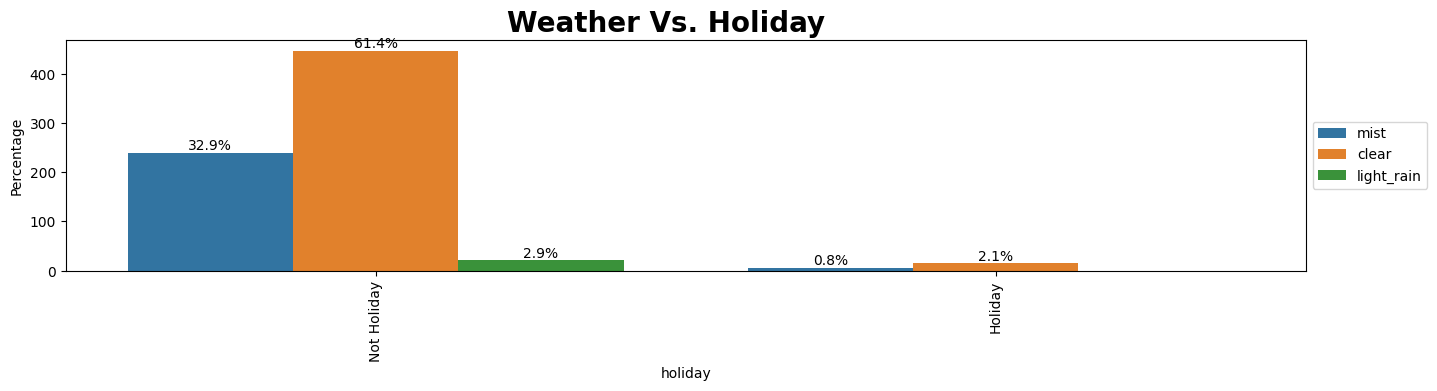

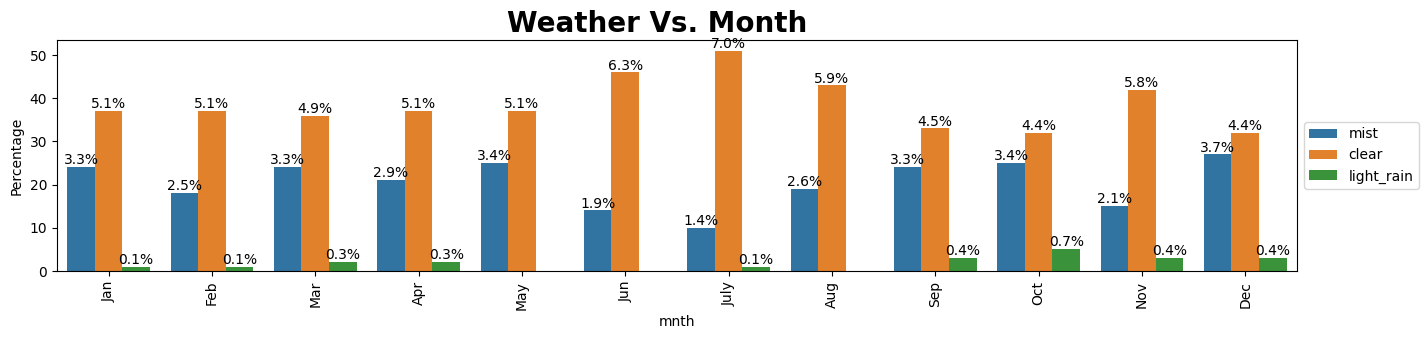

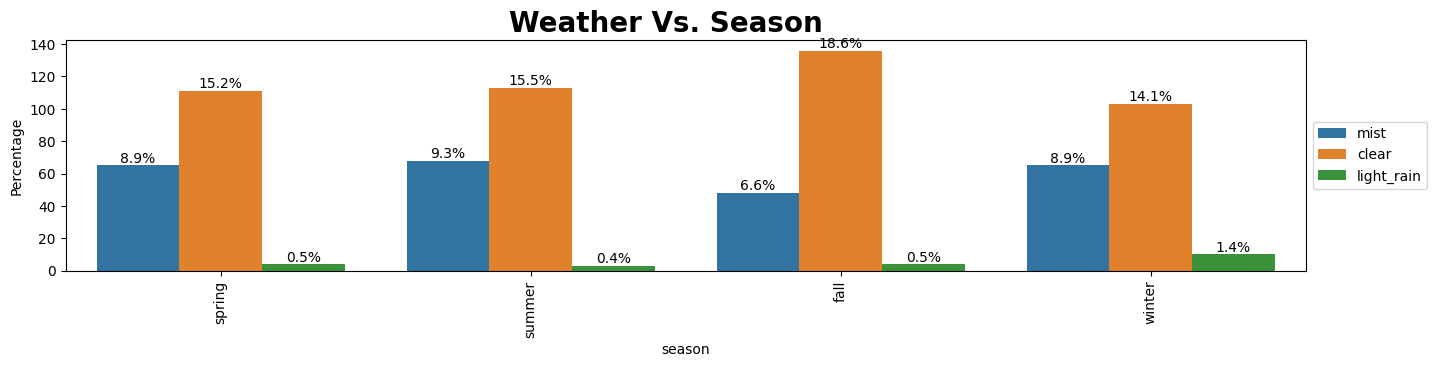

In [21]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

categoricalDict3 = {"Days of the week":"weekday", "Workingday": "workingday", "Holiday": "holiday", "Month":"mnth", "Season": "season"}
# categoricalDict3 = {"Days of the week":"weekday"}
for k in categoricalDict3.keys():
  segment_barplot(df1, categoricalDict3[k], "weathersit", f"Weather Vs. {k}")

The result indicates that:
1. There is no rain in holidays
2. only 0.7% of the days are rainy weekends and holidays. So most of the weekends are also eaither clear or mist.
3. winter has the maximum percentage of light raining days and fall has maximum percentage of clear days

### **Segmented Univariate analysis for a categorical variable against continues variable**:

In [22]:
def segment_boxPlot(data, x, y, title):

  plt.figure(figsize=(16,4))
  sns.boxplot(x=x, y=y, data=data)
  plt.suptitle(title, fontsize=20, fontweight="bold")
  plt.tick_params(axis='x', rotation=90)
  plt.show()

  levels = list(data[x].unique())

  if len(levels)>=3:
    normality_list = []
    z_list = []
    for i in range(len(levels)):
      z = data.loc[data[x]==levels[i], y]
      z_list.append(z)
      normality_list.append(stats.shapiro(z).pvalue)

    if any(t < 0.05 for t in normality_list):
      print(f"Data is not normaly distributed. So we use Kruskal-Wallis H-test to test equality between categories {', '.join(map(str, levels))}.")
      sigVal = stats.kruskal(*z_list).pvalue

      if sigVal < 0.05:
        print(f"P-value = {sigVal} and is statistically significant. So we can reject the Null hypothesis and\nconclude that the mean for {', '.join(map(str, levels))} samples are not equal.")
      else:
        print(f"P-value = {sigVal} and is not statistically significant. So we can not reject the Null hypothesis.\nMeaning that there is a chance the mean of two of {', '.join(map(str, levels))} samples are equal.")

    else:
      print("Data is normaly distributed and we use ANOVA to test equality between two categories")
      sigVal = stats.f_oneway(*z_list).pvalue

      if sigVal < 0.05:
        print(f"P-value = {sigVal} and is statistically significant. So we can reject the Null hypothesis and\nconclude that the mean for {', '.join(map(str, levels))} samples are not equal.")
      else:
        print(f"P-value = {sigVal} and is not statistically significant. So we can not reject the Null hypothesis.\nMeaning that there is a chance the mean the mean of two of {', '.join(map(str, levels))} samples are equal.")

  elif len(levels)==2:
    y1 = data.loc[data[x]==levels[0], y]
    y2 = data.loc[data[x]==levels[1], y]

    normality_g1 = stats.shapiro(y1).pvalue
    normality_g2 = stats.shapiro(y2).pvalue

    if normality_g1 < 0.05 or normality_g2 < 0.05:
      print(f"Data is not normaly distributed. So we use Kolmogorov-Smirnov test to test equality between two categories {levels[0]} and {levels[1]}.")
      sigVal = stats.ks_2samp(y1, y2, method="exact")[1]

      if sigVal < 0.05:
        print(f"P-value = {sigVal} and is statistically significant. So we can reject the Null hypothesis and\nconclude that the mean for {levels[0]} samples is not equal to the mean for {levels[1]} sample.")
      else:
        print(f"P-value = {sigVal} and is not statistically significant. So we can not reject the Null hypothesis.\nMeaning that there is a chance the mean for {levels[0]} sample is equal to the mean for {levels[1]} sample.")

    else:
      print("Data is normaly distributed and we use t-test to test equality between two categories")
      sigVal = stats.ttest_ind(y1, y2, equal_var=False).pvalue

      if sigVal < 0.05:
        print(f"P-value = {sigVal} and is statistically significant. So we can reject the Null hypothesis and\nconclude that the mean for {levels[0]} sample is not equal to the mean for {levels[1]} sample.")
      else:
        print(f"P-value = {sigVal} and is not statistically significant. So we can not reject the Null hypothesis.\nMeaning that there is a chance the mean for {levels[0]} sample is equal to the mean for {levels[1]} sample.")



<IPython.core.display.Javascript object>

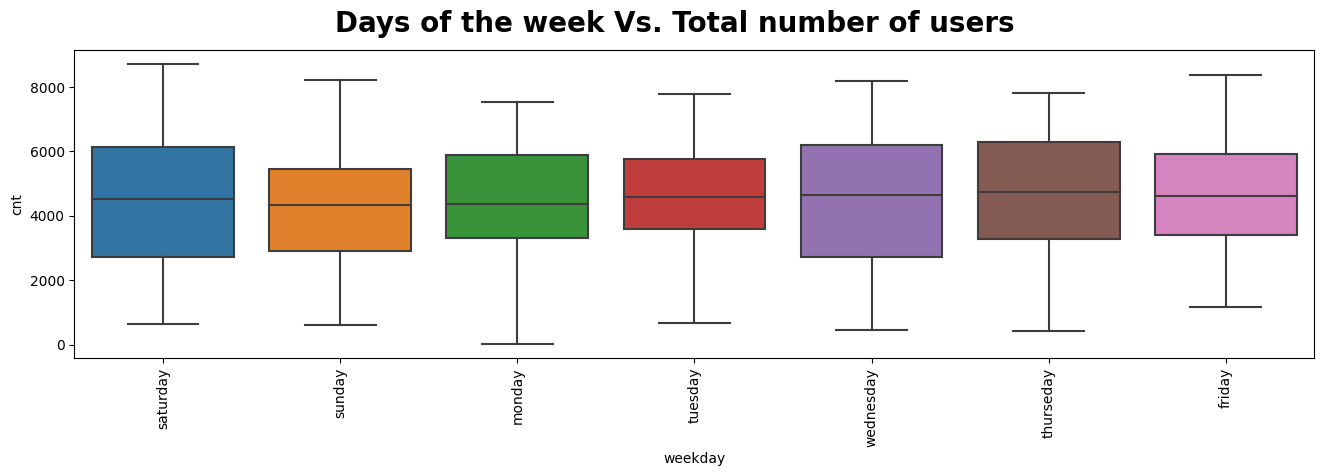

Data is not normaly distributed. So we use Kruskal-Wallis H-test to test equality between categories saturday, sunday, monday, tuesday, wednesday, thurseday, friday.
P-value = 0.6158021287171862 and is not statistically significant. So we can not reject the Null hypothesis.
Meaning that there is a chance the mean of two of saturday, sunday, monday, tuesday, wednesday, thurseday, friday samples are equal.


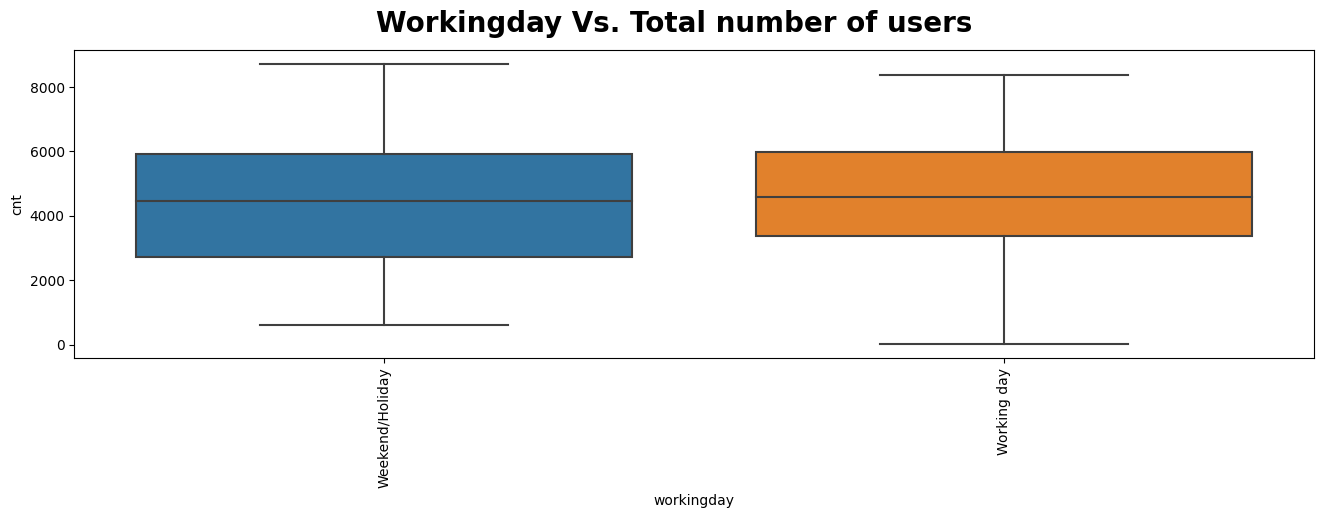

Data is not normaly distributed. So we use Kolmogorov-Smirnov test to test equality between two categories Weekend/Holiday and Working day.
P-value = 0.03963466320338063 and is statistically significant. So we can reject the Null hypothesis and
conclude that the mean for Weekend/Holiday samples is not equal to the mean for Working day sample.


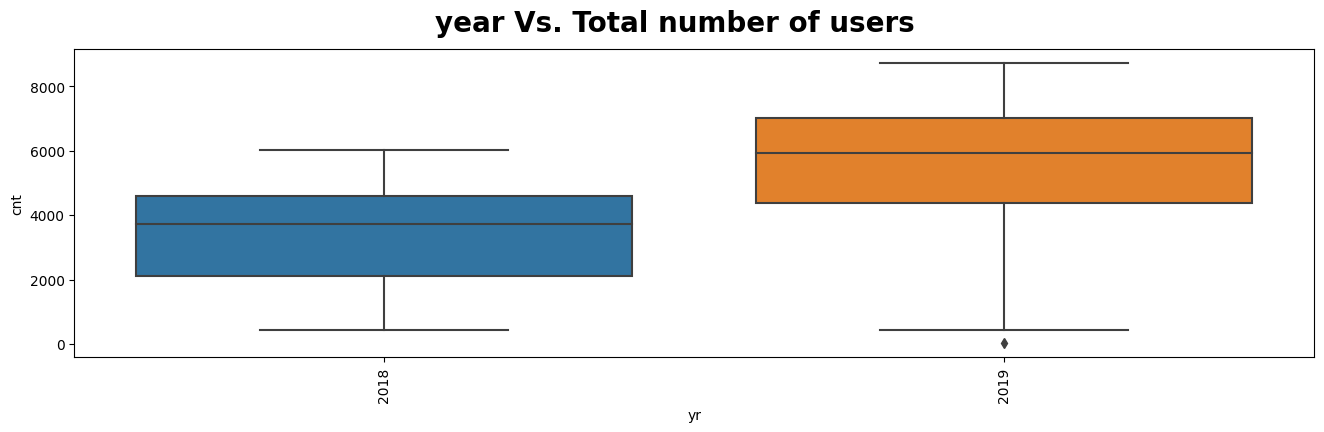

Data is not normaly distributed. So we use Kolmogorov-Smirnov test to test equality between two categories 2018 and 2019.
P-value = 1.9543388070206605e-61 and is statistically significant. So we can reject the Null hypothesis and
conclude that the mean for 2018 samples is not equal to the mean for 2019 sample.


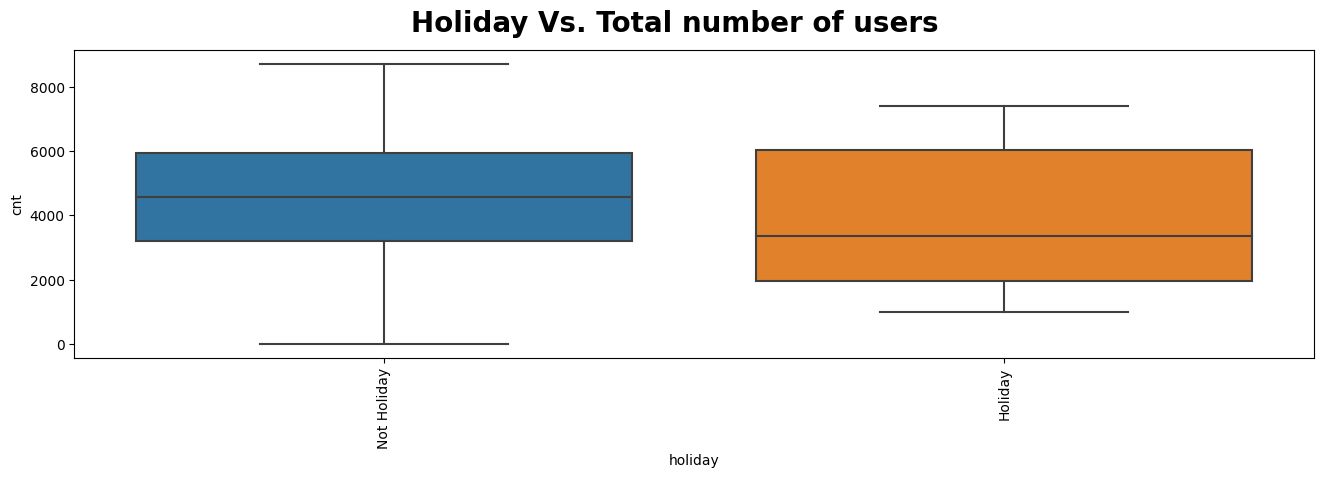

Data is not normaly distributed. So we use Kolmogorov-Smirnov test to test equality between two categories Not Holiday and Holiday.
P-value = 0.039387969698777614 and is statistically significant. So we can reject the Null hypothesis and
conclude that the mean for Not Holiday samples is not equal to the mean for Holiday sample.


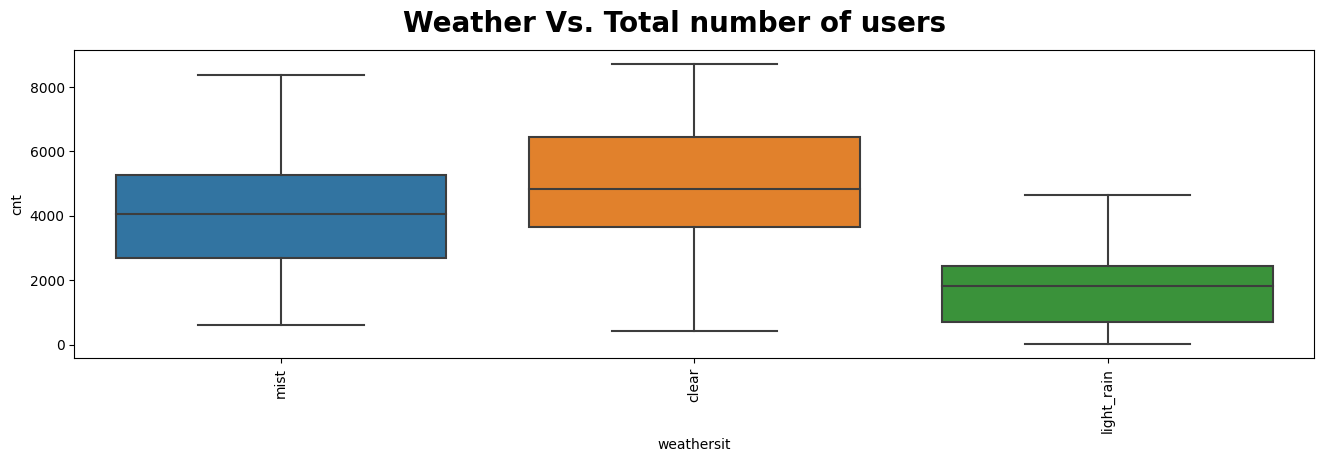

Data is not normaly distributed. So we use Kruskal-Wallis H-test to test equality between categories mist, clear, light_rain.
P-value = 3.446081291890538e-15 and is statistically significant. So we can reject the Null hypothesis and
conclude that the mean for mist, clear, light_rain samples are not equal.


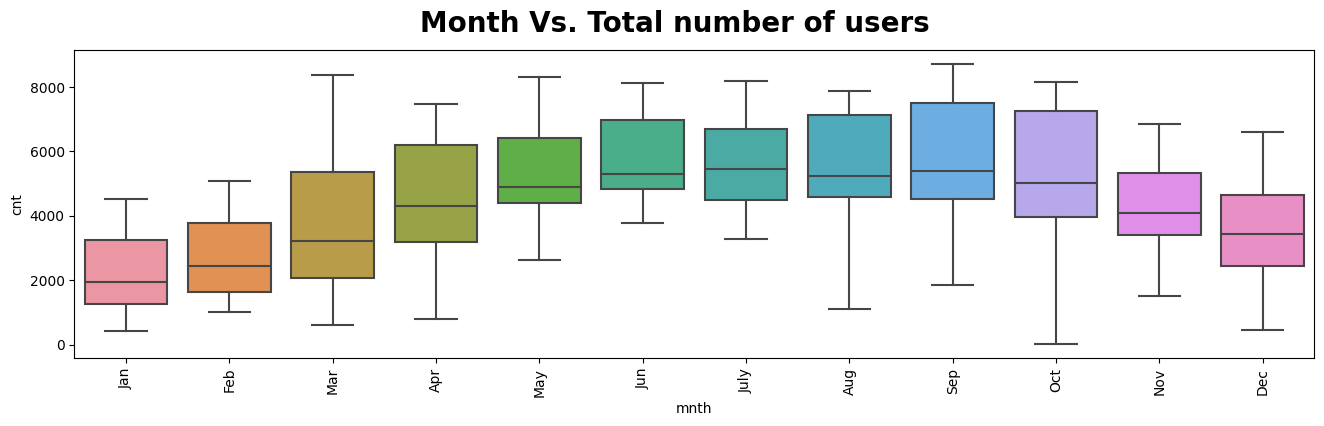

Data is not normaly distributed. So we use Kruskal-Wallis H-test to test equality between categories Jan, Feb, Mar, Apr, May, Jun, July, Aug, Sep, Oct, Nov, Dec.
P-value = 3.6883220139461083e-54 and is statistically significant. So we can reject the Null hypothesis and
conclude that the mean for Jan, Feb, Mar, Apr, May, Jun, July, Aug, Sep, Oct, Nov, Dec samples are not equal.


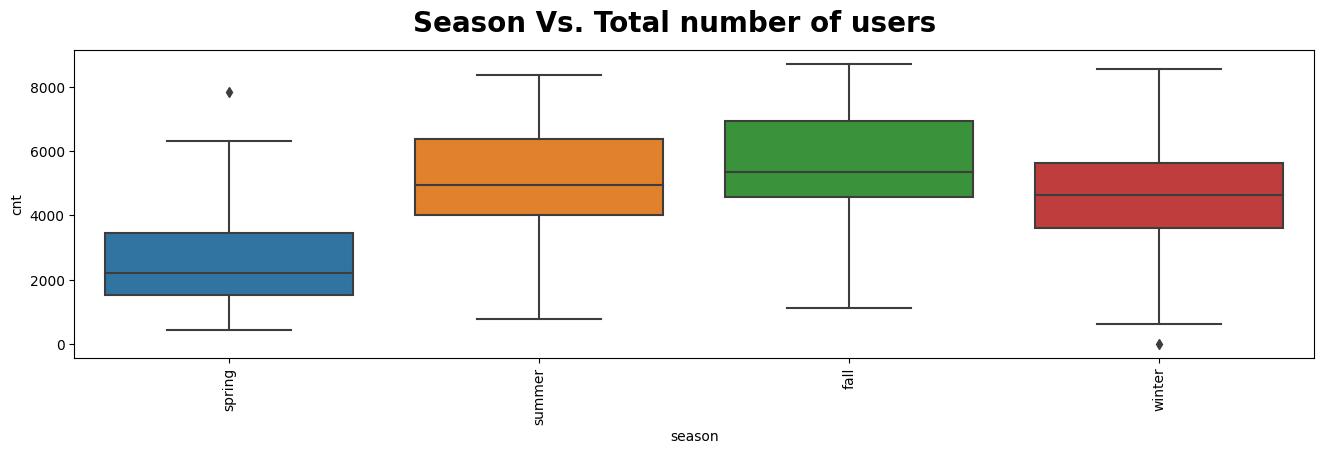

Data is not normaly distributed. So we use Kruskal-Wallis H-test to test equality between categories spring, summer, fall, winter.
P-value = 8.932925666291152e-54 and is statistically significant. So we can reject the Null hypothesis and
conclude that the mean for spring, summer, fall, winter samples are not equal.


In [23]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

# since Outlier removed version was more clear that version been used

outcomeDict = {"Total number of users":"cnt"}


for z in categoricalDict1.keys():
  for k in outcomeDict.keys():
    segment_boxPlot(df1, categoricalDict1[z], outcomeDict[k], f"{z} Vs. {k}")

1. The year has very significant effect on the bike usage within 2019 having higer level of total bake rental
2. there are significantly less number of bike being rented in light rainy days incomparison with clear and mist days and there is no heavy rain day recorded.
3. Most of bikes being rented are between month of May to October and the rental range have closer distribution during these months with larger range in upper quantile (between 50 to 75 percentile).
4. number of bukes being rented in summer, fall and winter is much higher than spring.

# **Bivariate Analysis**

## **Bivariate Analysis between Continues Variables**

### **Correlation Matrix**: is a Bivariate Analysis used to measure the closeness between continues variables. When two continues variables are highly corelated (|correlation| >= 0.75) That means those features are dependent to each other. So a change in one of them will cause the change in the other one. Meaning that one feature can be explained by the other one. These variables are considered data driven matrics. When we see very high correlation between two features we can use the ratio of these features instead of actual values.

The highly correalated values will negatively affect multiple regression. So we need to remove them or replace them.

<IPython.core.display.Javascript object>

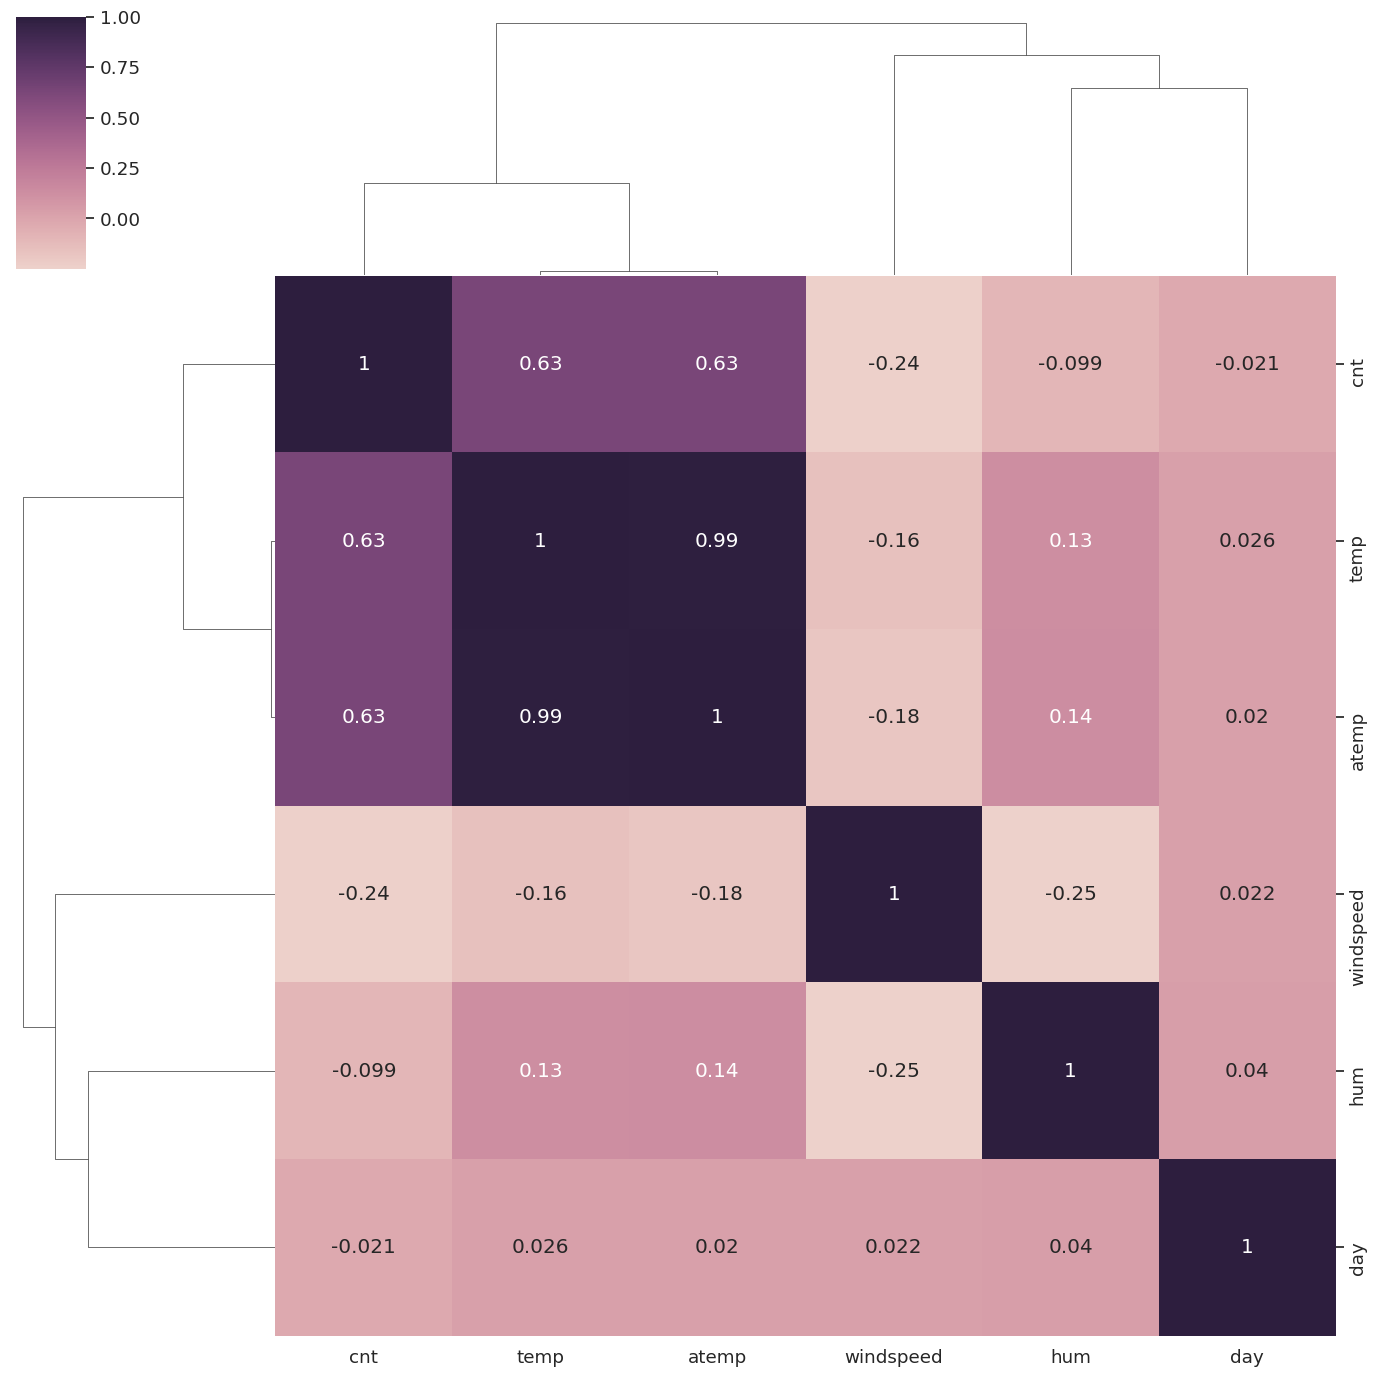

In [24]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

corrMatrix = df2[numericalCols].corr()
sns.set(font_scale=1.2)
sns.clustermap(corrMatrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), figsize=(14, 14))
plt.show()

1. It is also indicating that there is a high correlation between cnt and both temp and atemp that indicates that temp and atemp are determinant factor in cnt prediction.

2. there is also a very high correlation between temp and atemp. So I'm using atemp and combined with a new feature made from ration of temp to atemp.


<IPython.core.display.Javascript object>

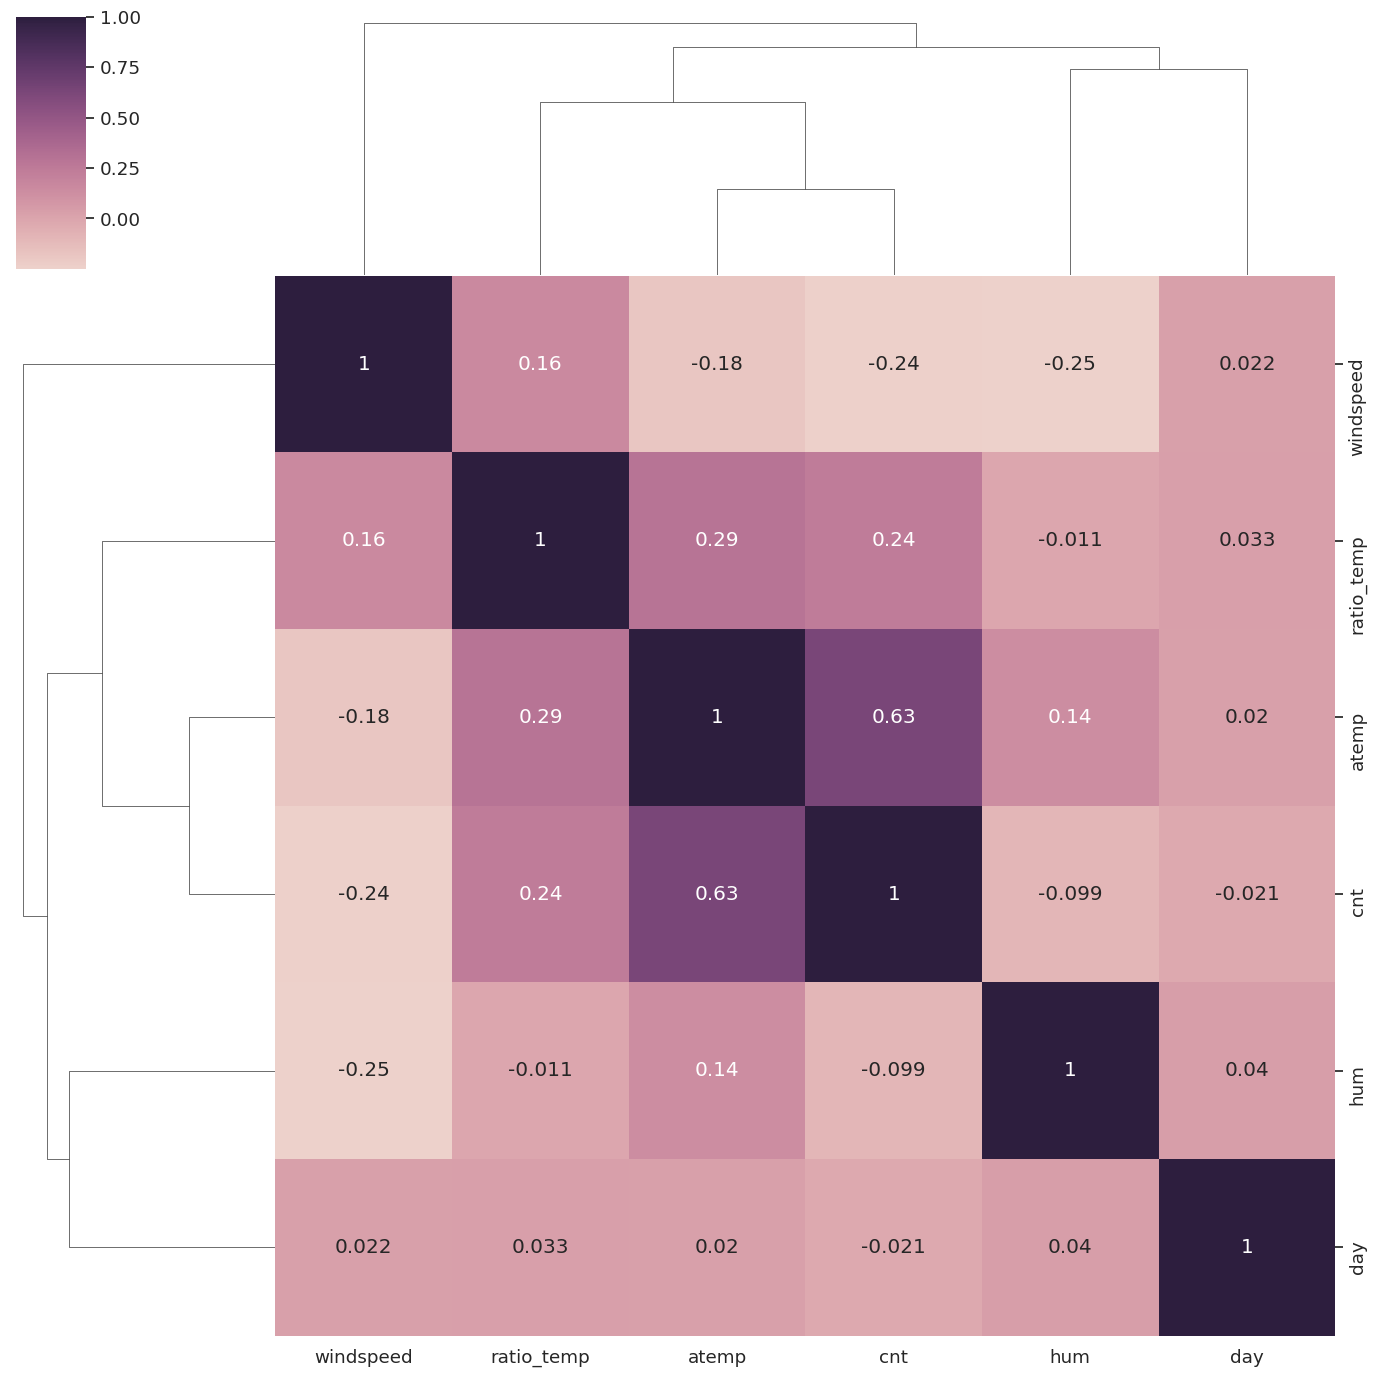

In [25]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

df2["ratio_temp"] = df2["temp"]/df2["atemp"]

nonCorrNumericCols = list(set(numericalCols)-set(["temp"]))
corrMatrix = df2[nonCorrNumericCols + ["ratio_temp"]].corr()
sns.set(font_scale=1.2)
sns.clustermap(corrMatrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), figsize=(14, 14))
plt.show()


## **Bivariate Analysis for two categorical variables**

In [26]:
def bivar_barplot(data, x, col, title):
  plt.figure(figsize=(16,4))
  newdf = data[[x, col]].groupby([x, col], as_index=False).value_counts()
  newdf[f'proportion {col}'] = newdf[["count", col]].groupby([col]).transform(lambda x: x/x.sum())
  newdf[f'proportion {col}'] = newdf[f'proportion {col}'].round(2)

  ax = sns.barplot(x=x, y=f'proportion {col}', hue=col, data=newdf, estimator=np.median)
  for i in ax.containers:
    ax.bar_label(i,)

  plt.suptitle(title, fontsize=20, fontweight="bold")
  plt.tick_params(axis='x', rotation=90)
  plt.legend(loc='upper right',fontsize=10)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

1.   **Our outcome variable Against All the Categorical Variables we have**:

<IPython.core.display.Javascript object>

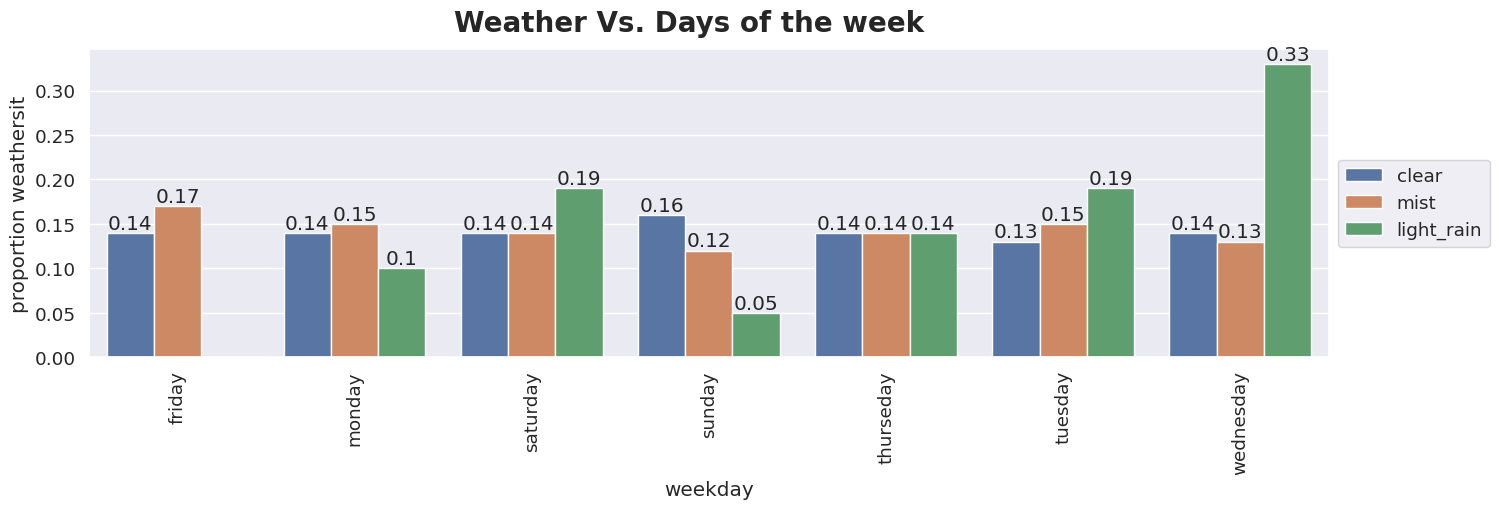

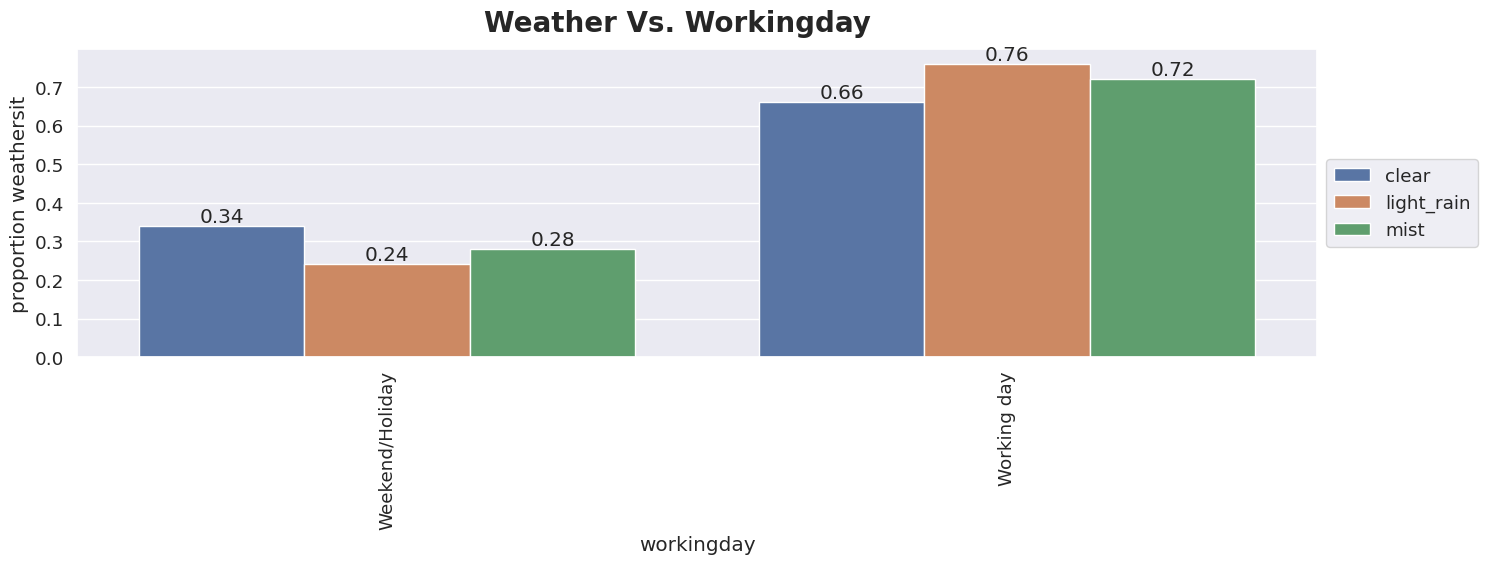

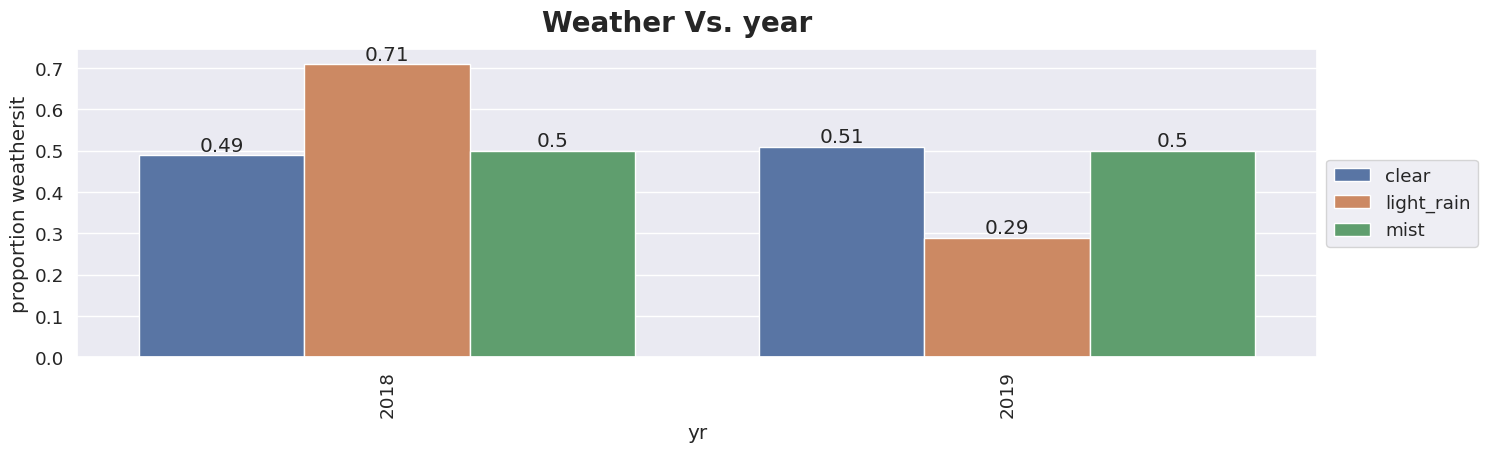

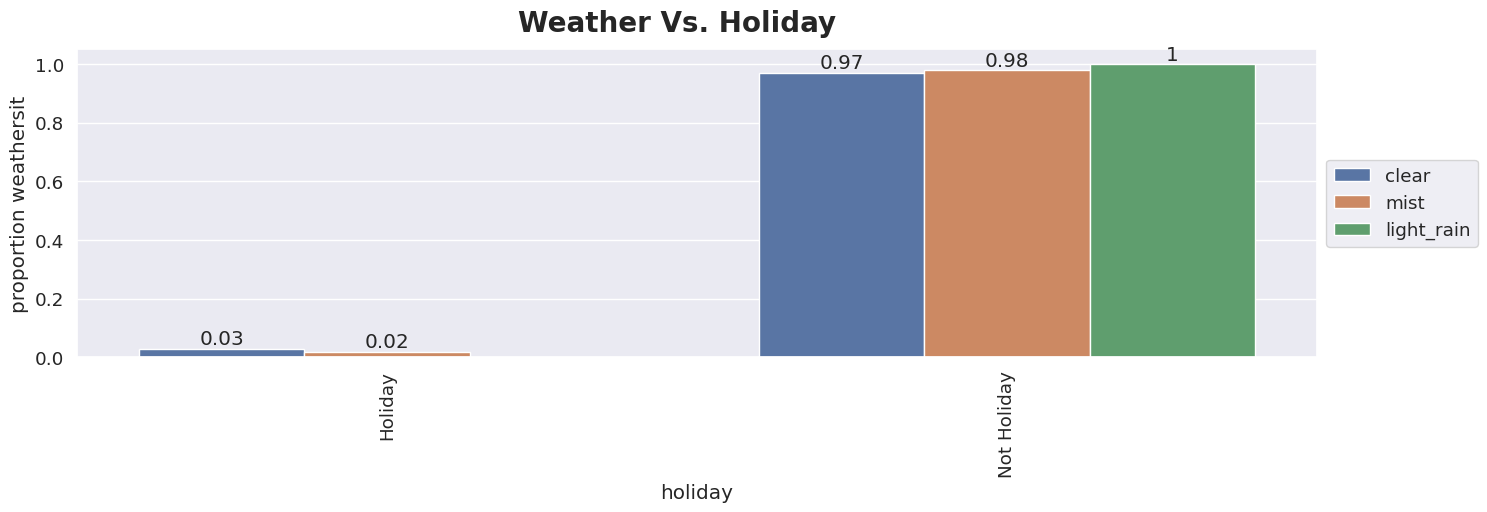

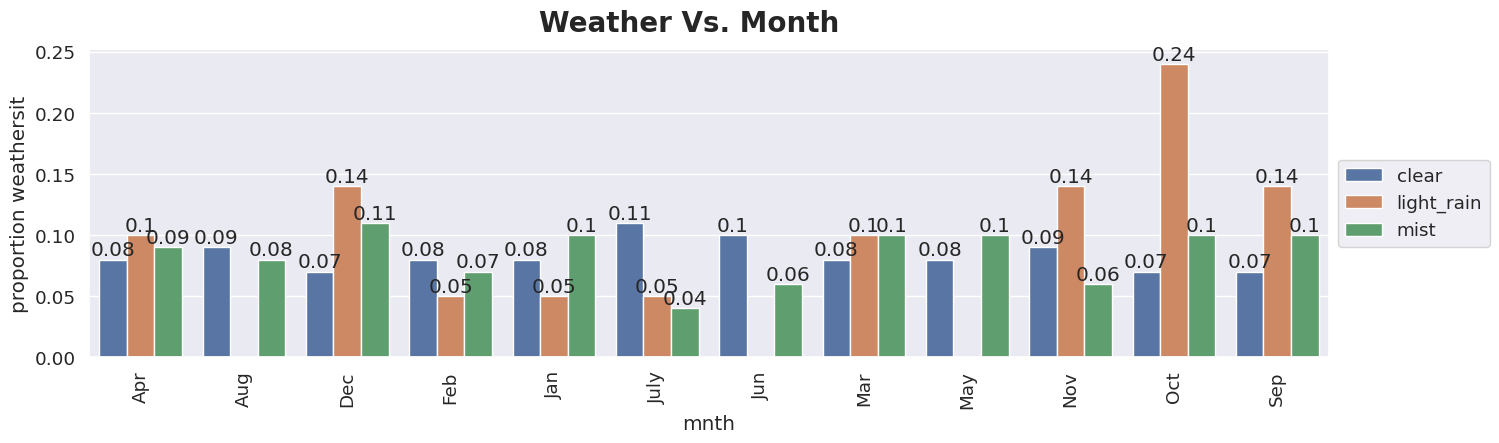

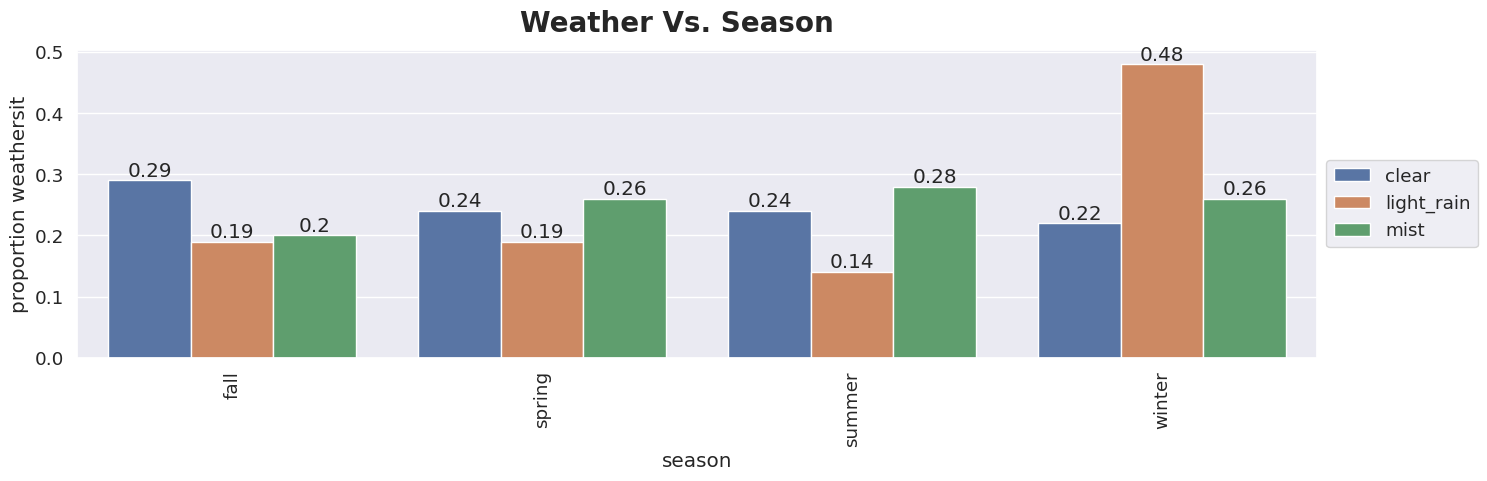

In [27]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

categoricalDict = {'Days of the week': 'weekday',
                    'Workingday': 'workingday',
                    'year': 'yr',
                    'Holiday': 'holiday',
                    'Month': 'mnth',
                    'Season': 'season'}
for k in categoricalDict.keys():
    bivar_barplot(df1, categoricalDict[k], 'weathersit', f"Weather Vs. {k}")

1. Most rainy days of the week are wednesdays and there is no rain in Fridays. only 5% of rainy days are in sundays.
2. 2018 has 71% of rainy days incompare with 2019 that only had 29% of rainy days.
3. all rainy days are non holidays. and 76% of them are working days.
4. October has the highest percentage of rainy days (24%) and winter has the highest number of rainy days (48%).

## **Bivariate analysis between categorical variables and continues variables**

In [28]:
def bivariate_box_barPlot(data, x, y, col, title):
  plt.figure(figsize=(16,6))
  plt.subplot(211)
  a = plt.gca()
  sns.boxplot(x=x, y=y, hue=col, data=data)
  plt.tick_params(axis='x', rotation=90)
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left',fontsize=10)
  xax = a.axes.get_xaxis()
  xax = xax.set_visible(False)

  plt.subplot(212)
  sns.barplot(x=x, y=y, hue=col, data=data, estimator=np.median)
  plt.suptitle(title, fontsize=20, fontweight="bold")
  plt.tick_params(axis='x', rotation=90)
  plt.legend().set_visible(False)
  plt.show()

<IPython.core.display.Javascript object>

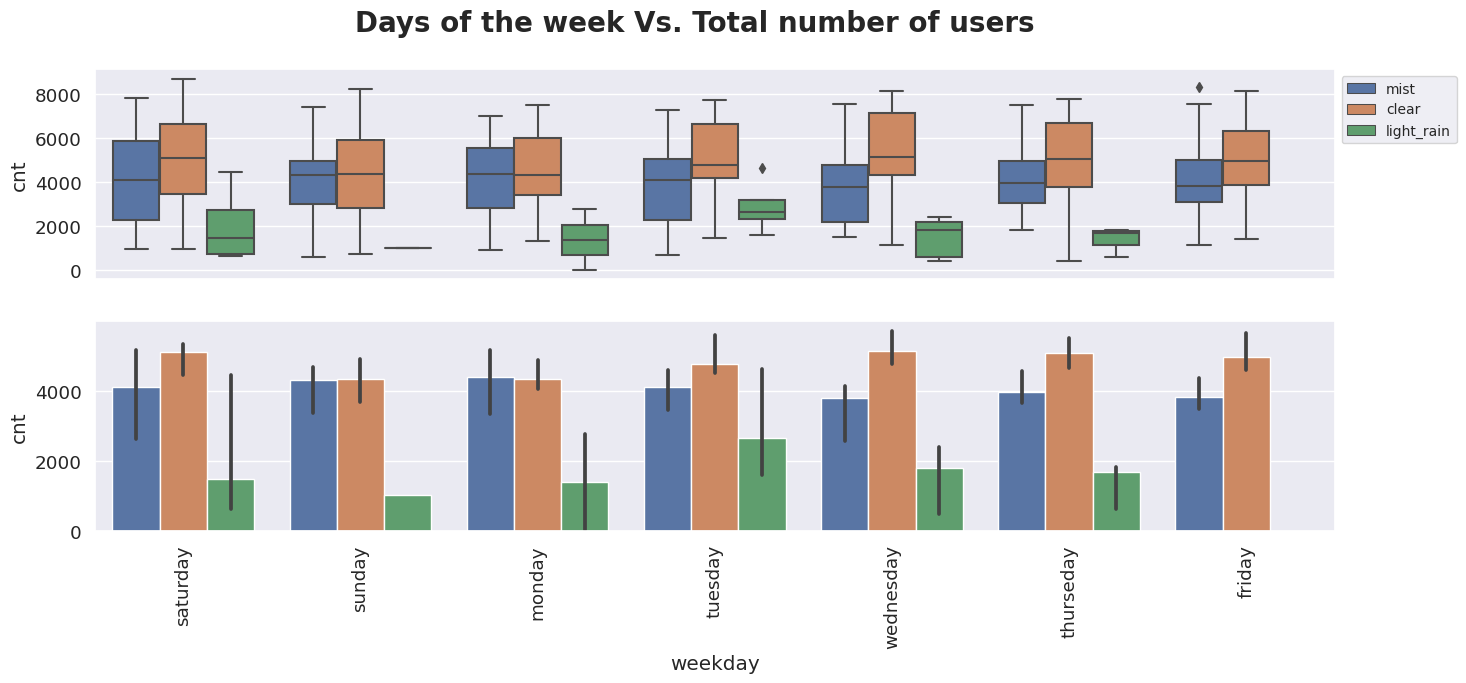

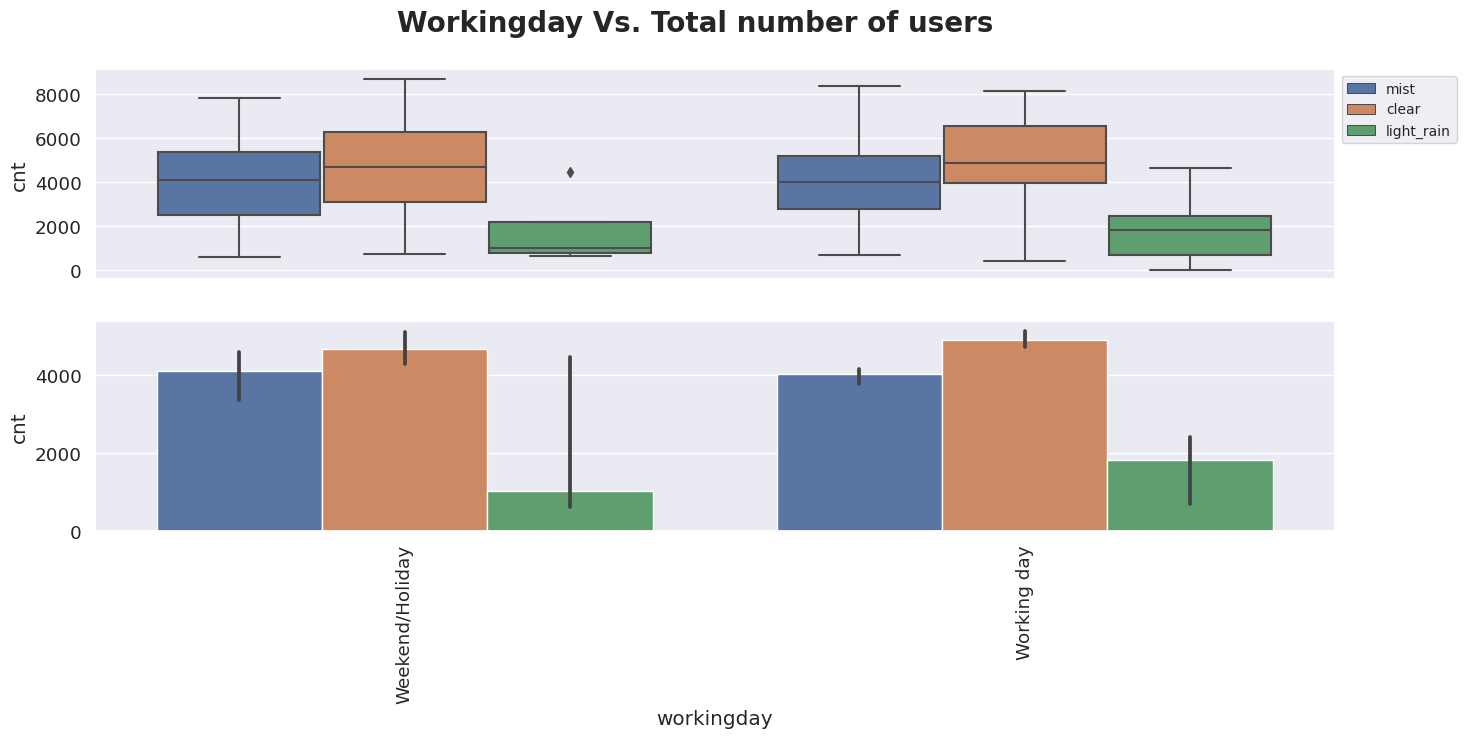

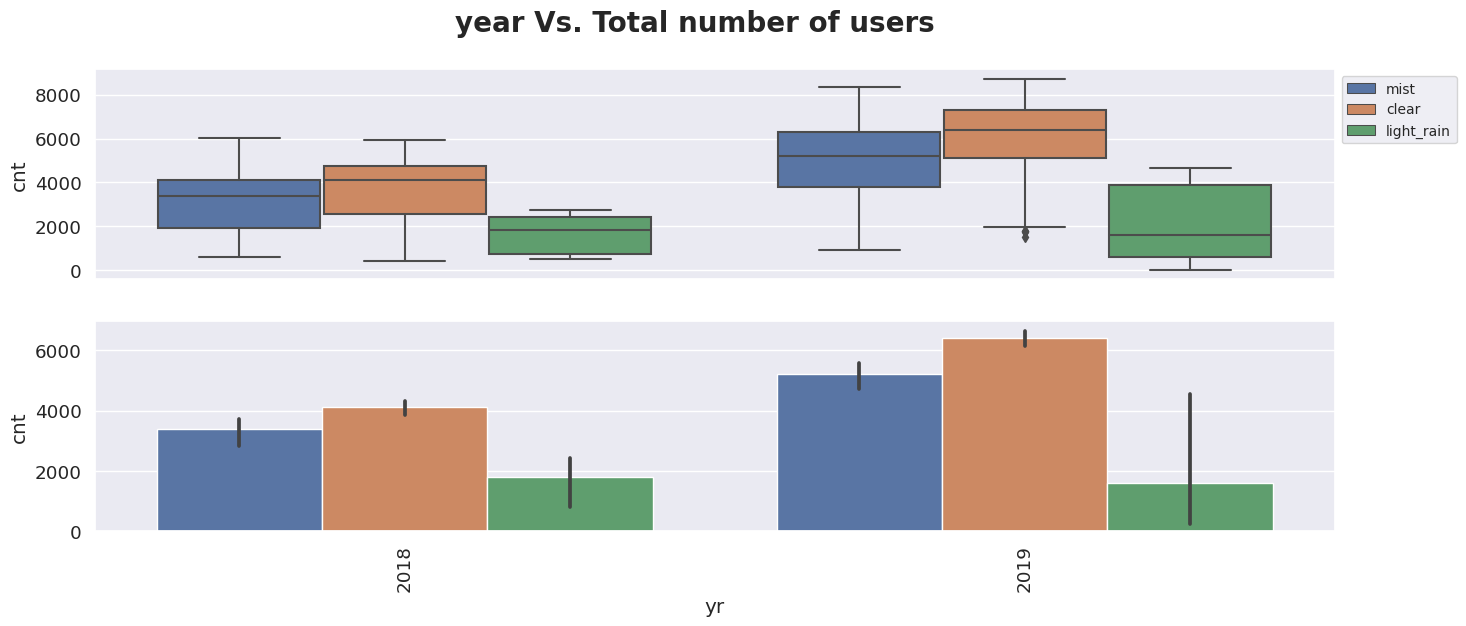

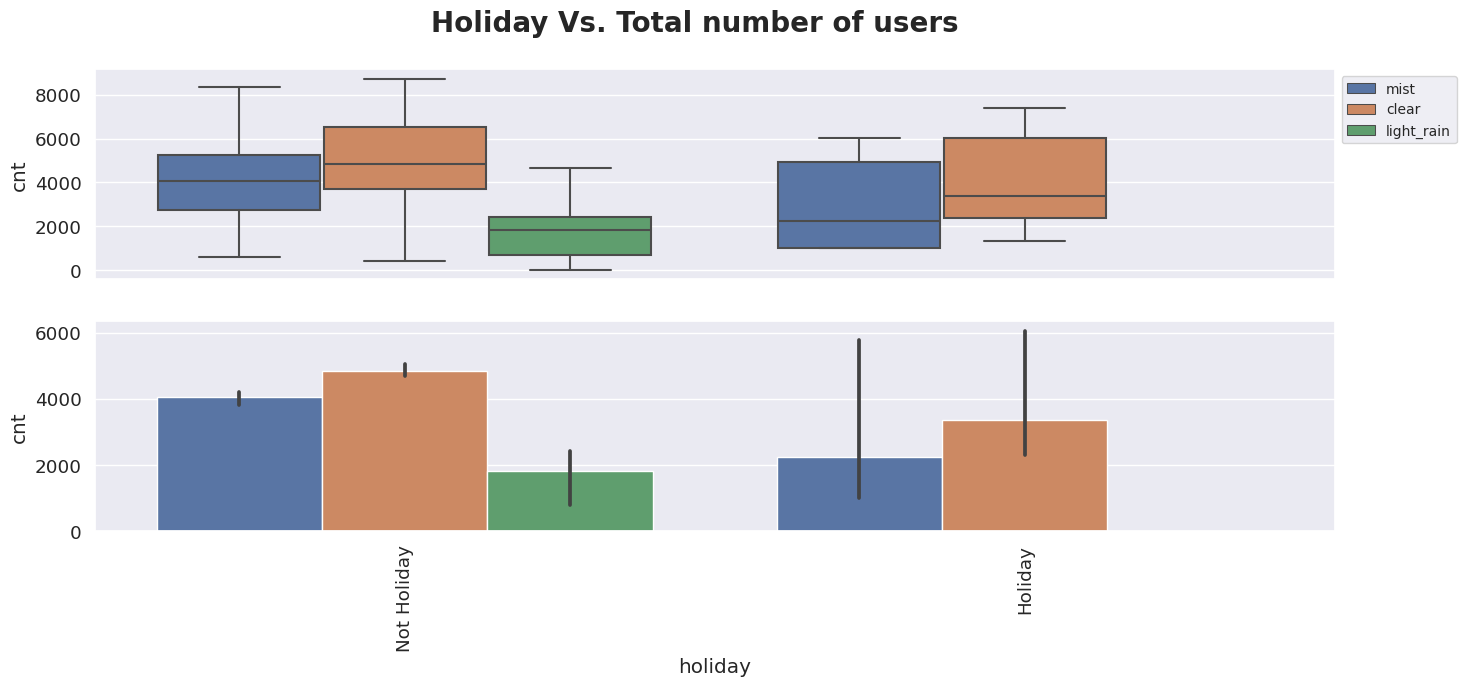

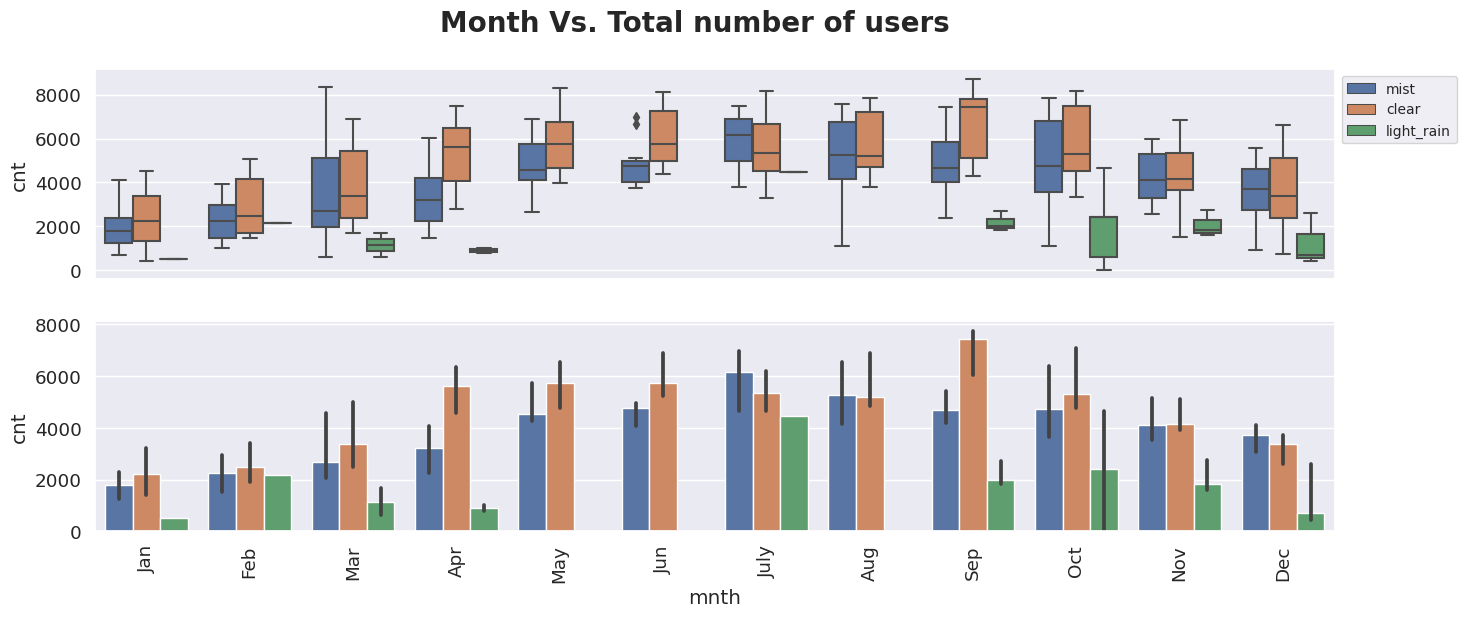

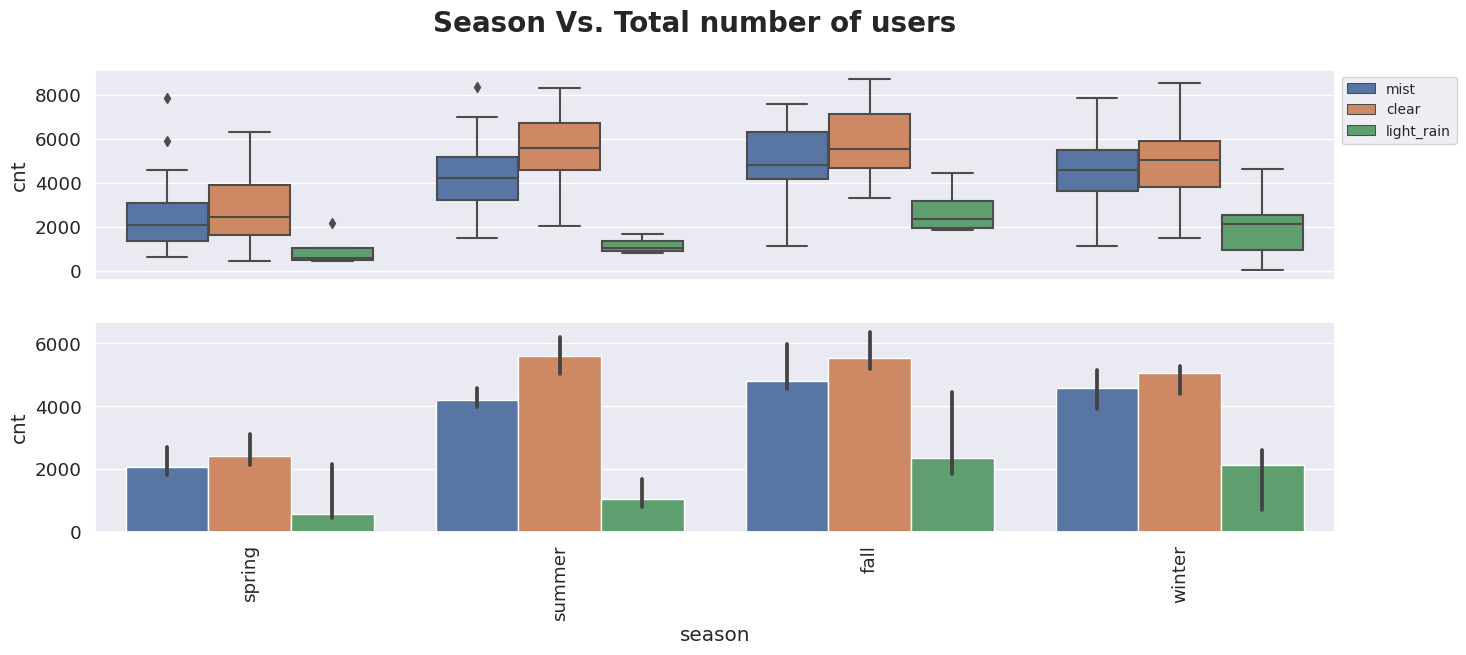

In [29]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

categoricalDict2 = {"Days of the week":"weekday", "Workingday": "workingday", "year":"yr",
                    "Holiday": "holiday", "Month":"mnth", "Season":"season"}

for i in categoricalDict2.keys():
    bivariate_box_barPlot(df1, categoricalDict2[i], "cnt", 'weathersit', f"{i} Vs. Total number of users")


1. most rentals are hppening in clear days specially tuesdays, wednesday, Thurseday and saturday. the mean number of rentals are much lower in rainy days than two other days.
2. Higest number of rentals happen in clear days in september.
3. overall results in this section indicates that all the categorical variables selected combined with weather situation affect the rental number.

## **Visualising the Data**

<IPython.core.display.Javascript object>

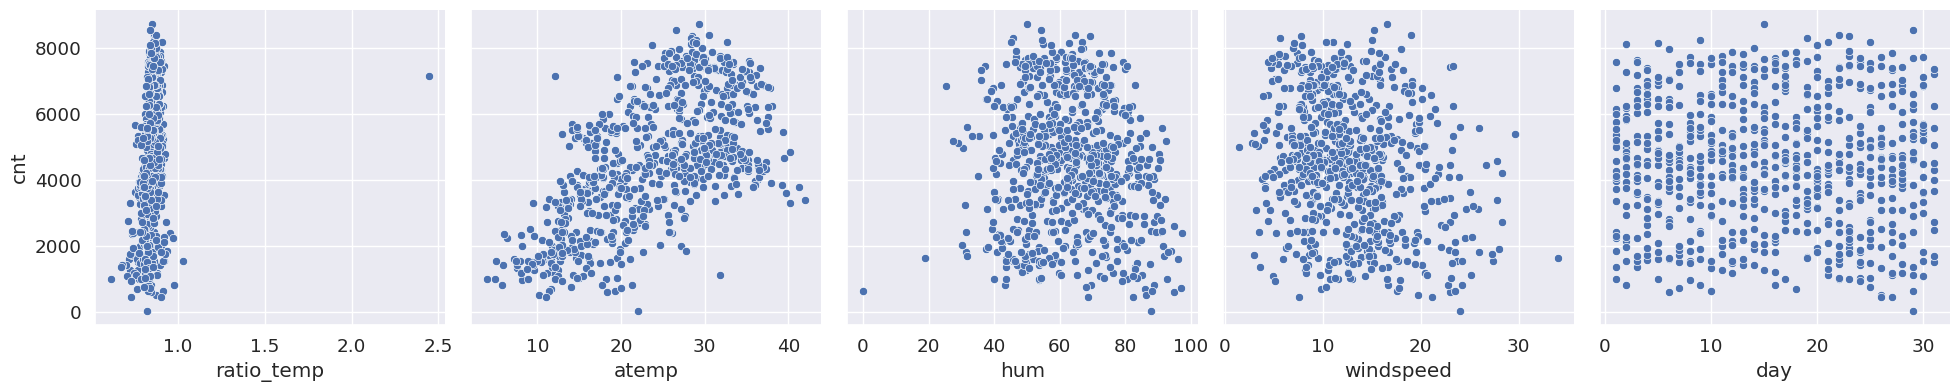

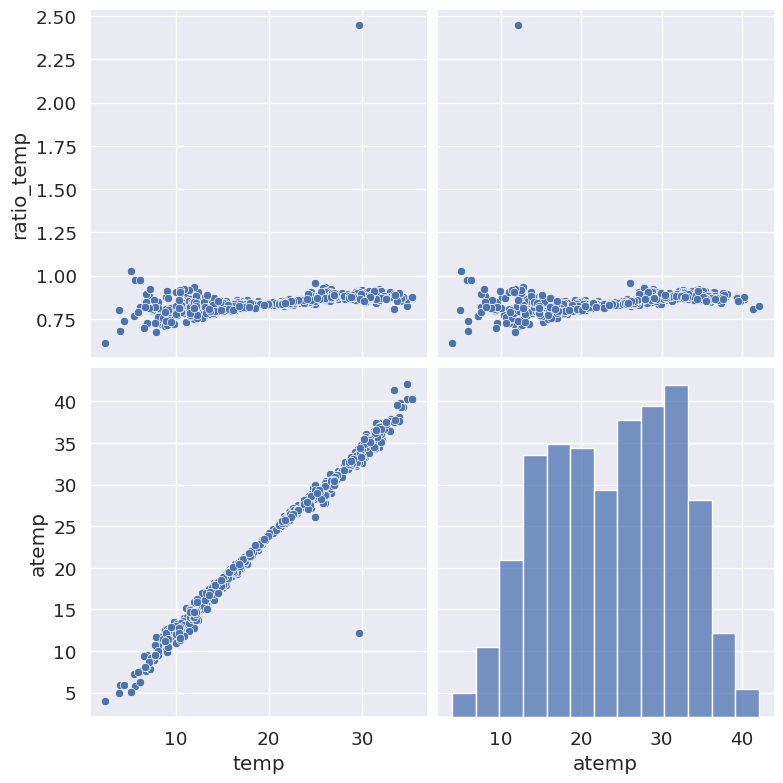

In [30]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

sns.pairplot(df2, x_vars=["ratio_temp", "atemp", "hum", "windspeed", "day"], y_vars=["cnt"], size=4, aspect=1, kind='scatter')
plt.show()

sns.pairplot(df2, x_vars=["temp", "atemp"], y_vars=["ratio_temp",  "atemp"], size=4, aspect=1, kind='scatter')
plt.show()

1. There is a clear linear relationship between atemp and total number of users. there isn't such relationship between cnt and windspeed, humidity or days of month.
2. there is a linear correlation between all values in temp and atemp with the exception of one value. when the temp is around 30 celsius and the stemp is around 12 celsius.

In [31]:
df3 = df2.drop(columns=["temp"])
df3.columns.tolist()


['yr',
 'holiday',
 'workingday',
 'atemp',
 'hum',
 'windspeed',
 'cnt',
 'day',
 'spring',
 'summer',
 'winter',
 'light_rain',
 'mist',
 'Aug',
 'Dec',
 'Feb',
 'Jan',
 'July',
 'Jun',
 'Mar',
 'May',
 'Nov',
 'Oct',
 'Sep',
 'monday',
 'saturday',
 'sunday',
 'thurseday',
 'tuesday',
 'wednesday',
 'ratio_temp']

## **Estimate possible correlation between dependent variable and each of numerical features**

since assumptions of Peason correlation been met we can use it to find relationship between different variables.
1. measurements are in ratio
2. there is a linear relationship
3. there is no outlier
4. features are approximately normally distributed

<IPython.core.display.Javascript object>

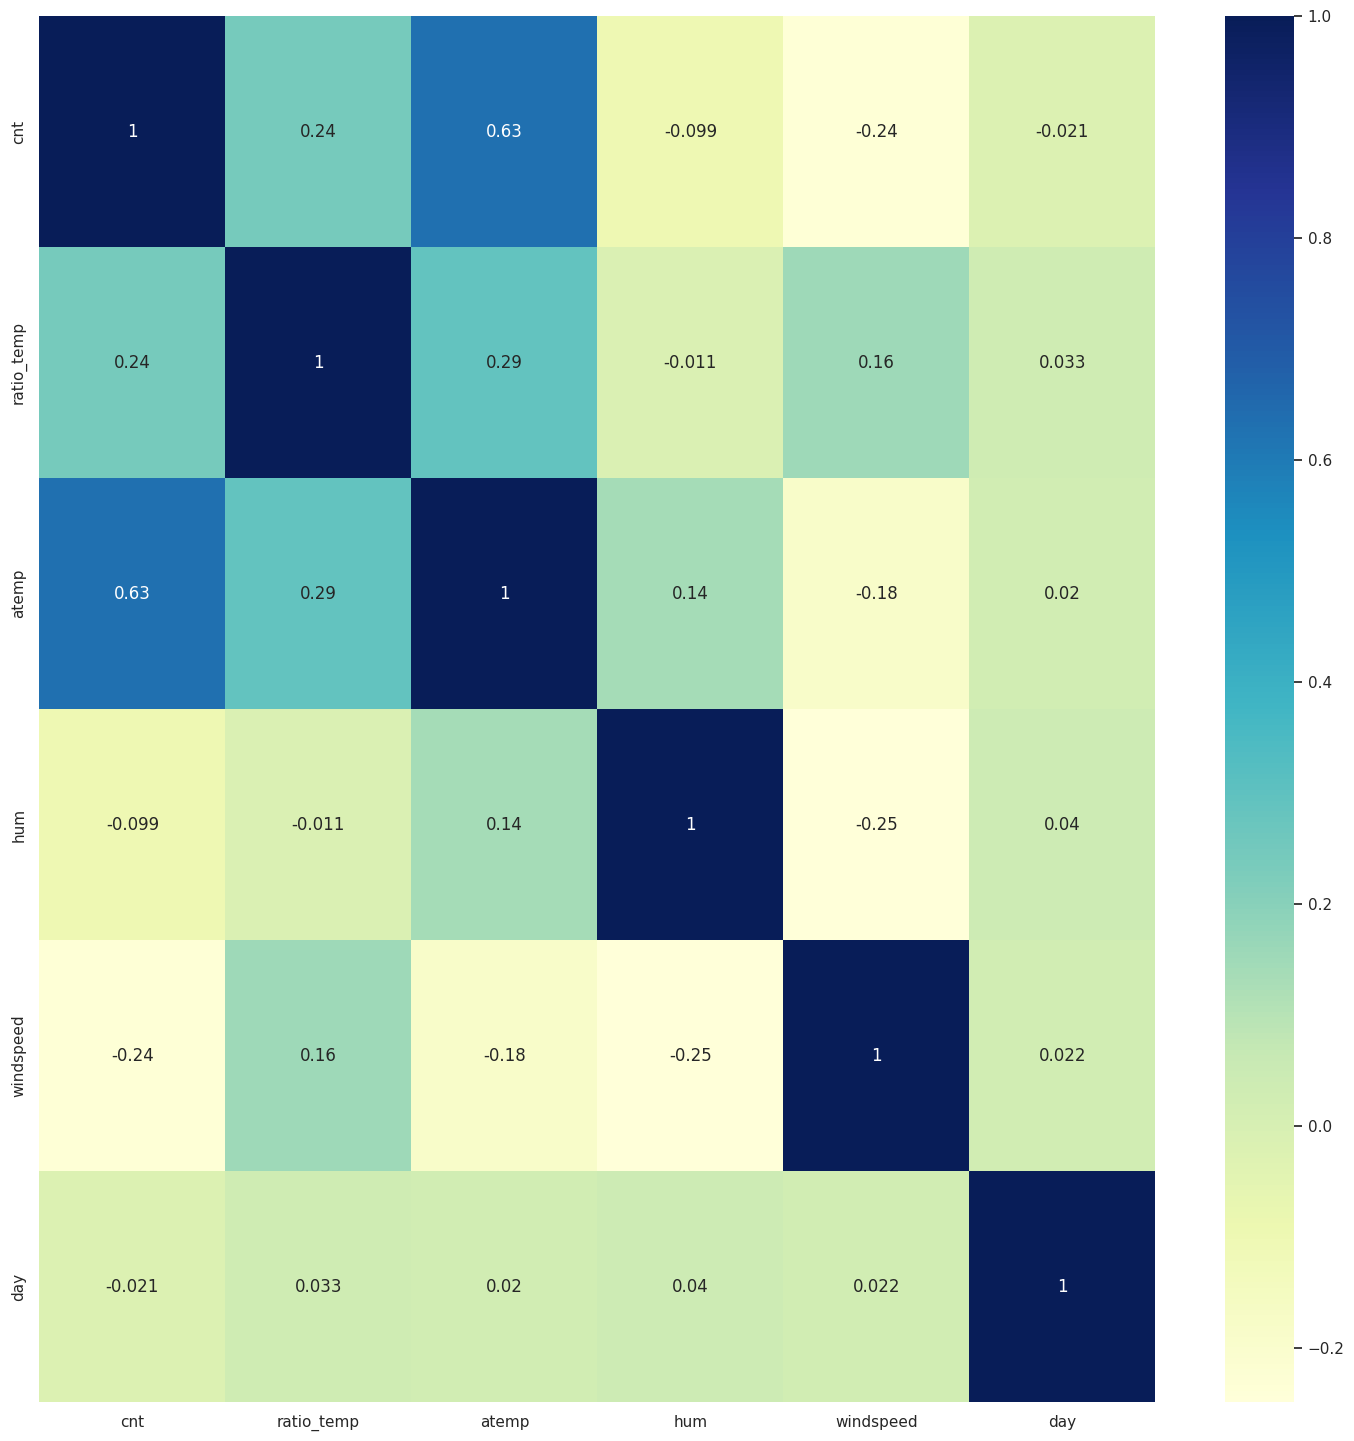

In [32]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

num_cols = ["cnt", "ratio_temp", "atemp",
            "hum", "windspeed", "day"]
sns.set(font_scale=1.)
plt.figure(figsize = (18,18))
sns.heatmap(df3[num_cols].corr(), cmap="YlGnBu", annot = True)
plt.show()

atemp is the only varibale with very high correlation with cnt. there are some correlation between cnt, and both windspeed and ratio-temp.

## **Splitting the Data into Training and Testing Sets**

In [33]:
df_train, df_test = train_test_split(df3, train_size = 0.8, test_size = 0.2, random_state = 100)

In [34]:
df3[num_cols].describe()

cnt  ratio_temp       atemp         hum   windspeed         day
count   730.000000  730.000000  730.000000  730.000000  730.000000  730.000000
mean   4508.006849    0.849183   23.726322   62.765175   12.763620   15.720548
std    1936.011647    0.072158    8.150308   14.237589    5.195841    8.802278
min      22.000000    0.613218    3.953480    0.000000    1.500244    1.000000
25%    3169.750000    0.826898   16.889713   52.000000    9.041650    8.000000
50%    4548.500000    0.847775   24.368225   62.625000   12.125325   16.000000
75%    5966.000000    0.875971   30.445775   72.989575   15.625589   23.000000
max    8714.000000    2.446919   42.044800   97.250000   34.000021   31.000000

## **Scaling**


Since our data has variables within very different ranges from (0.6, 2.4) for ratio temp to (22, 8714) for cnt we may better to find a way to scale them. Since there are some very large values in our data that may not be outliers, specially in the weather related variables such as humidity and wind, it is probably beter to use standardization.

Here I'm using both normalization and standardisation and also use unscaled data for the comparison.

Scaling should be done after split. beacause we dont want any influence from training set leaks into the test set.


In [36]:

dummy_vars = list(set(df3.columns)-set(num_cols))
scaler = StandardScaler()
scalingCols = df_train.columns.difference(['instant']+dummy_vars)
df_train_sd = scaler.fit_transform(df_train[scalingCols])
df_train_sd = pd.DataFrame(df_train_sd, index=df_train.index, columns= scalingCols)

df_test_sd = scaler.transform(df_test[scalingCols])
df_test_sd = pd.DataFrame(df_test_sd, index=df_test.index, columns= scalingCols)

scaler = MinMaxScaler()
df_train_nrm = scaler.fit_transform(df_train[scalingCols])
df_train_nrm = pd.DataFrame(df_train_nrm, index=df_train.index, columns= scalingCols)

df_test_nrm = scaler.transform(df_test[scalingCols])
df_test_nrm = pd.DataFrame(df_test_nrm, index=df_test.index, columns= scalingCols)


In [37]:
scalingCols


Index(['atemp', 'cnt', 'day', 'hum', 'ratio_temp', 'windspeed'], dtype='object')

## **Model Building**

## **Multiple linear Regression model and residual analysis**


In [38]:
def residualAnalusis(model, predDF, title):

  residuals = np.array(predDF["res"])

  plt.figure(figsize=(16,4))
  plt.suptitle(title, fontsize=20, fontweight="bold")

  sns.distplot(predDF["res"], bins = 15)
  plt.suptitle('Error Terms Normalization', fontsize = 15)
  plt.xlabel('Residuals', fontsize = 15)
  plt.show()

  qqplot(residuals, fit=True, line='45')
  plt.suptitle('Error Terms Normalization Q-Q Plot', fontsize = 15)
  plt.show()

  plt.suptitle('Error Terms Autocorrelation', fontsize = 15)
  autocorrelation_plot(predDF[["res"]])
  plt.show()

  sns.regplot(data=predDF, x="pred", y="res")
  plt.suptitle('Homoscedasticity', fontsize = 15)
  plt.ylabel('Residuals', fontsize = 15)
  plt.xlabel('Predicted Y', fontsize = 15)

  plt.show()

<IPython.core.display.Javascript object>

*********************************** Total number of users *********************************

============================ Summary Original Data ============================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     111.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           2.49e-82
Time:                        13:47:34   Log-Likelihood:                -5057.8
No. Observations:                 584   AIC:                         1.013e+04
Df Residuals:                     578   BIC:                         1.015e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err     

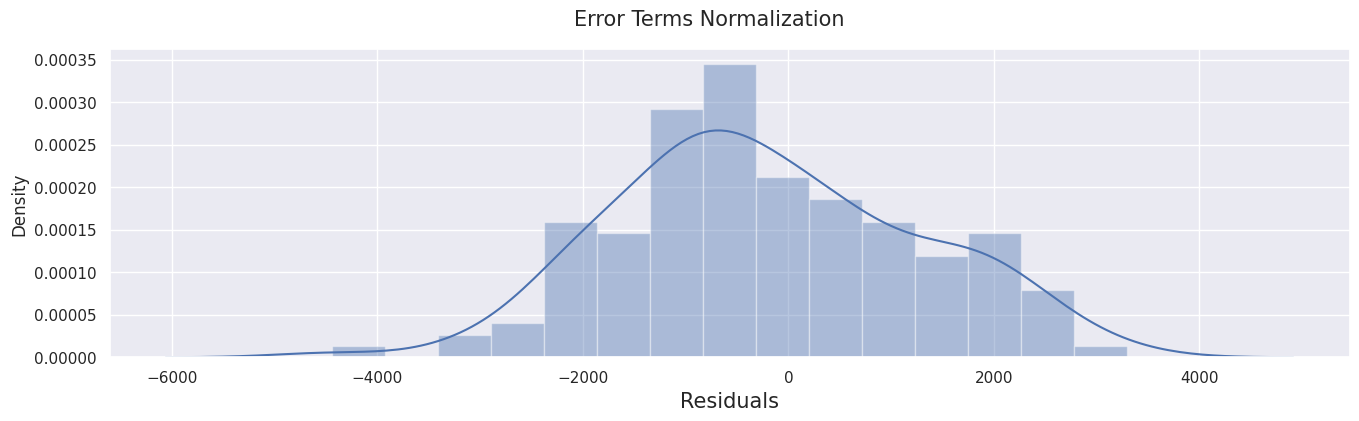

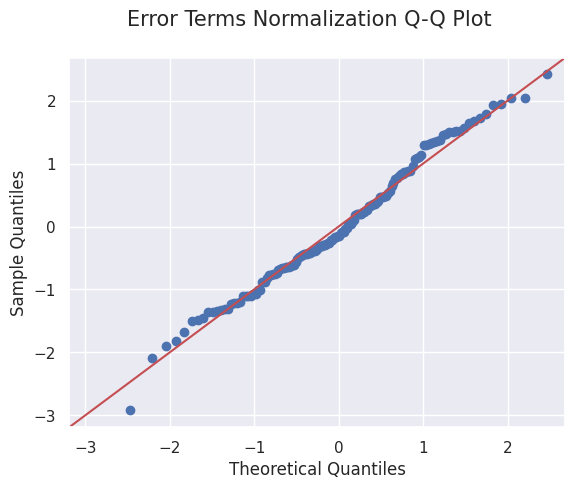

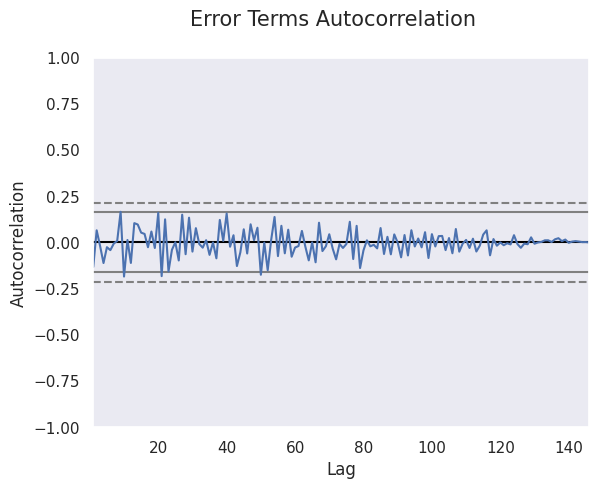

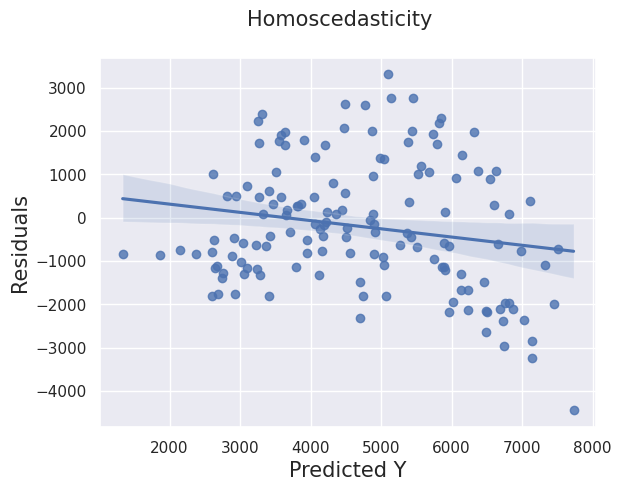


================= Prediction Evaluation Table Original Data ===================
+-------+-------------+
|  R2   |     MSE     |
+=======+=============+
| 0.368 | 2148187.710 |
+-------+-------------+

============================ Summary Standardised Data ============================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     111.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           2.49e-82
Time:                        13:47:36   Log-Likelihood:                -631.57
No. Observations:                 584   AIC:                             1275.
Df Residuals:                     578   BIC:                             1301.
Df Model:                           5                                         
Cov

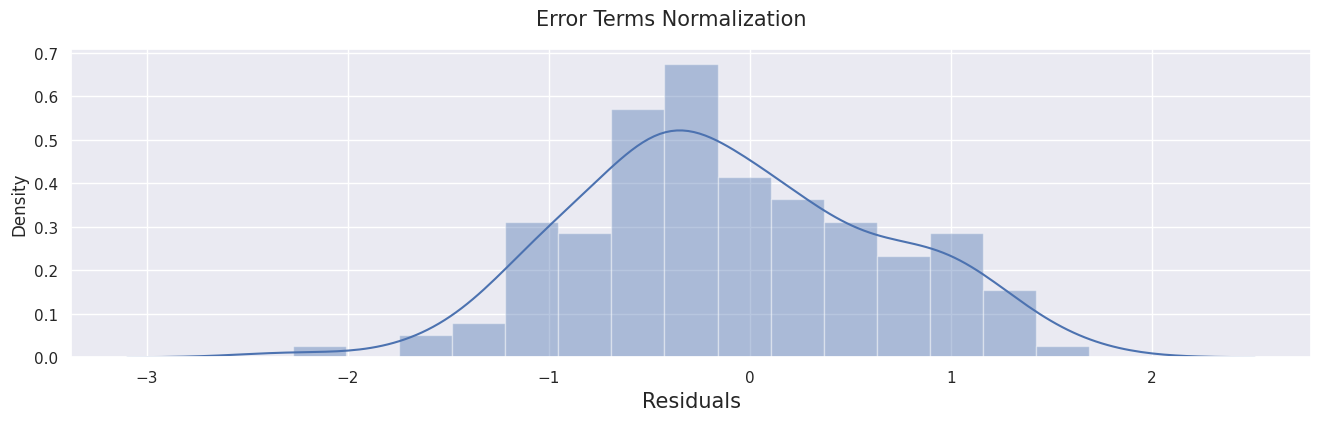

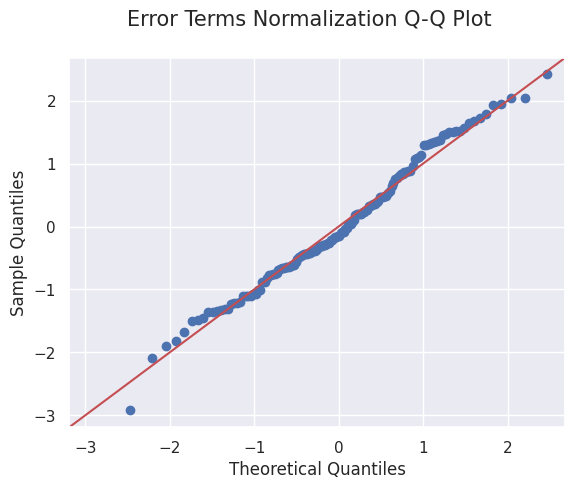

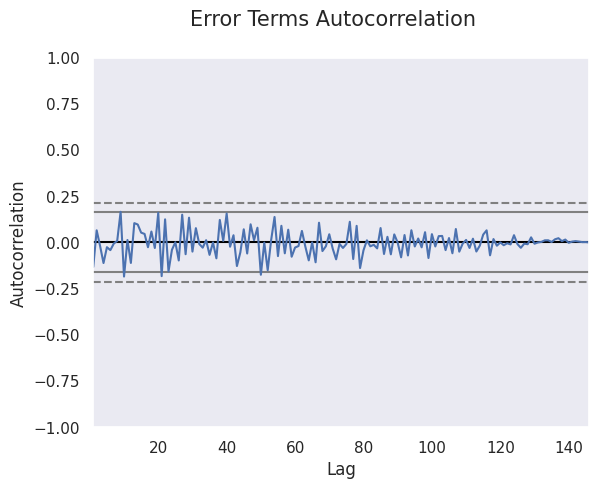

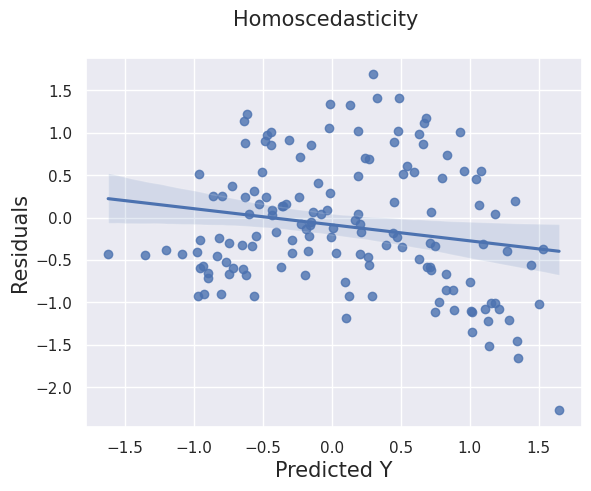


================= Prediction Evaluation Table Standardised Data ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.368 | 0.560 |
+-------+-------+

============================ Summary Normalised Data ============================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     111.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           2.49e-82
Time:                        13:47:37   Log-Likelihood:                -5057.8
No. Observations:                 584   AIC:                         1.013e+04
Df Residuals:                     578   BIC:                         1.015e+04
Df Model:                           5                                         
Covariance Type:            non

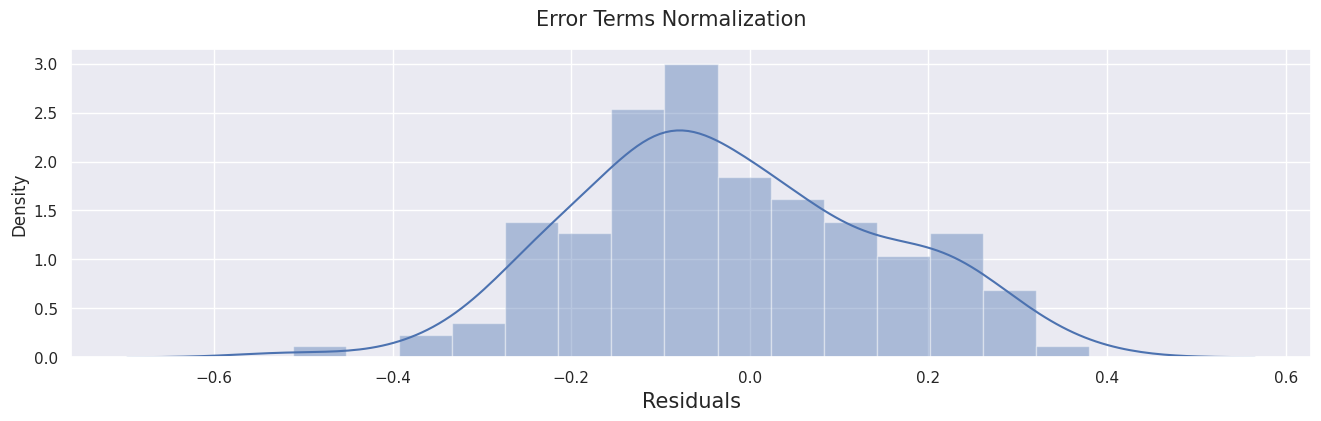

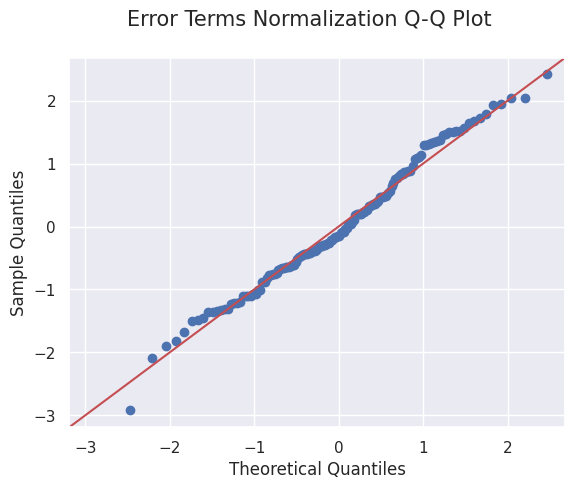

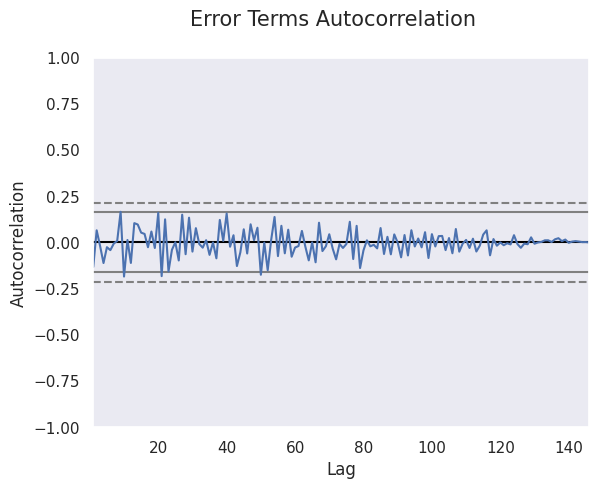

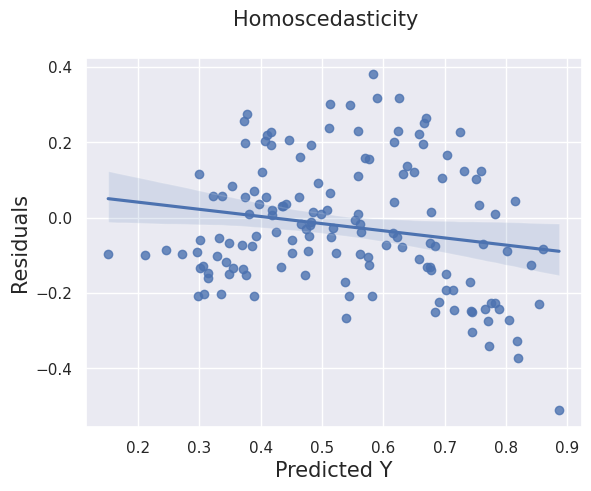


================= Prediction Evaluation Table Normalised Data ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.368 | 0.030 |
+-------+-------+


In [39]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

xDict = {"Temprature Ratio":"ratio_temp", "Feeling of Temprature in Celsius":"atemp",
        "Wind Speed":"windspeed", "Humidity":"hum",
         "Day of the Month":"day"}

yDict = {"Total number of users":"cnt"}


for j in yDict.keys():
    x = list(xDict.values())
    y = yDict[j]


    print(f"********************************************************************")

    x_train_sm = sm.add_constant(df_train[x])
    lr = sm.OLS(df_train[y], x_train_sm).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train[x], df_train[y])

    y_pred = lm.predict(df_test[x])
    ytest = df_test[y].reset_index(drop=True)

    predDF = pd.DataFrame(y_pred)
    predDF.columns=["pred"]
    predDF["res"] = ytest - predDF["pred"]

    print("\n============================ Summary Original Data ============================")
    print(lr.summary())

    print(f"\n================= Linear Assumption test Original Data ===================")

    residualAnalusis(lr, predDF, f"Original Data")

    print(f"\n================= Prediction Evaluation Table Original Data ===================")

    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())

    # ========================================================================================
    x_train_sm_sd = sm.add_constant(df_train_sd[x])
    lr_sd = sm.OLS(df_train_sd[y], x_train_sm_sd).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train_sd[x], df_train_sd[y])

    y_pred = lm.predict(df_test_sd[x])
    ytest = df_test_sd[y].reset_index(drop=True)

    predDF_sd = pd.DataFrame(y_pred)
    predDF_sd.columns=["pred"]
    predDF_sd["res"] = ytest - predDF_sd["pred"]

    print("\n============================ Summary Standardised Data ============================")
    print(lr_sd.summary())

    print(f"\n================= Linear Assumption test Standardised Data ===================")

    residualAnalusis(lr_sd, predDF_sd, f"Standardised Data")

    print(f"\n================= Prediction Evaluation Table Standardised Data ===================")

    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())

    # ========================================================================================
    x_train_sm_nrm = sm.add_constant(df_train_nrm[x])
    lr_nrm = sm.OLS(df_train[y], x_train_sm_nrm).fit()
    y_pred_nrm = lr_nrm.predict(x_train_sm_nrm)

    lm = LinearRegression()
    lm = lm.fit(df_train_nrm[x], df_train_nrm[y])

    y_pred = lm.predict(df_test_nrm[x])
    ytest = df_test_nrm[y].reset_index(drop=True)

    predDF_nrm = pd.DataFrame(y_pred)
    predDF_nrm.columns=["pred"]
    predDF_nrm["res"] = ytest - predDF_nrm["pred"]

    print("\n============================ Summary Normalised Data ============================")
    print(lr_nrm.summary())

    print(f"\n================= Linear Assumption test Normalised Data ===================")

    residualAnalusis(lr_nrm, predDF_nrm, f"Normalised Data")

    print(f"\n================= Prediction Evaluation Table Normalised Data ===================")

    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())


When only numerical variables being used to train the model the adjusted R2 is 0.486 (magnitude of association) and p-value of F-statistics is close to zero (over all model fit didnot happen by chance) that indicates the combination of these features is generating a good fit for our outcome variables. Now we need check and see if the assumptions of our regression model been met:
1. normality of residuals been shown by both density plot and Q-Q plot. Both plots indicate that the residual is normally distributed. But the mean is deviated from zero specially in the case of normalised data.
2. independence of residuals from each other been investigated using Autocorrelation plot and Durbin Watson test. Since the plot indicates that residual auto correlation has been fall in 95% confidence of zero and the Durbin Watson result is about 2 we conclude that there isn't any auto correlation
3. since the increase in predicted y cause decrease in residuals we can conclude that the regression line is not Homoscedastic and homoscedasticity assumption has been violated

Now we would like to see if scaling improve the condition of our model. Regarding presence of some large values that are not considered outlier I expected the standardisation to be a better scaling method for our data.

Since scaling just affects the coefficients and none of the other parameters like t-statistic, F-statistic, p-values, R-squared, etc. we only need to focouse on the coefficients from summary table.

But when we look at the R2 of prediction on test set we can see that standardised data has the highest R2 level.

if we compare the coefficients of scaled data with coefficients in original data, we can see that to our surprise coefficients have been dramatically redused by standardisation while it has been dramatically improved by normalization.

When we look at the coefficients of these features we can see all continues variables with the exception of day have significat coefficient with dependent variable.

## **Building Models adding Dummy variables**

> Now we would like to see how adding dummy variables affect model performances.




In [40]:
df_train_sd_dummy = df_train_sd.join(df_train[dummy_vars])
df_test_sd_dummy = df_test_sd.join(df_test[dummy_vars])

df_train_nrm_dummy = df_train_nrm.join(df_train[dummy_vars])
df_test_nrm_dummy = df_test_nrm.join(df_test[dummy_vars])

<IPython.core.display.Javascript object>

*********************************** Total number of users *********************************

============================ Summary Original Data ============================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     117.0
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          4.23e-215
Time:                        13:47:39   Log-Likelihood:                -4681.4
No. Observations:                 584   AIC:                             9423.
Df Residuals:                     554   BIC:                             9554.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err     

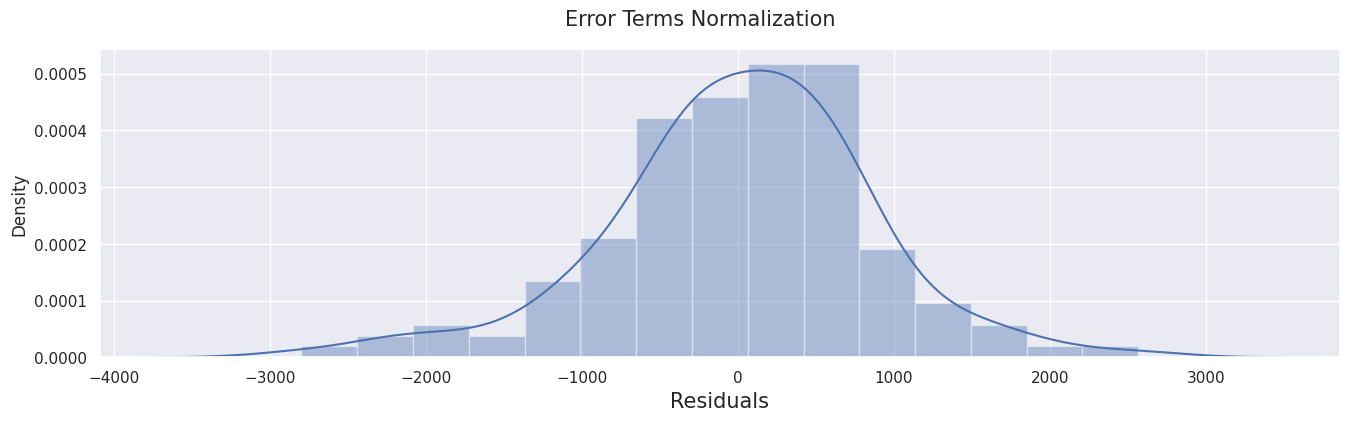

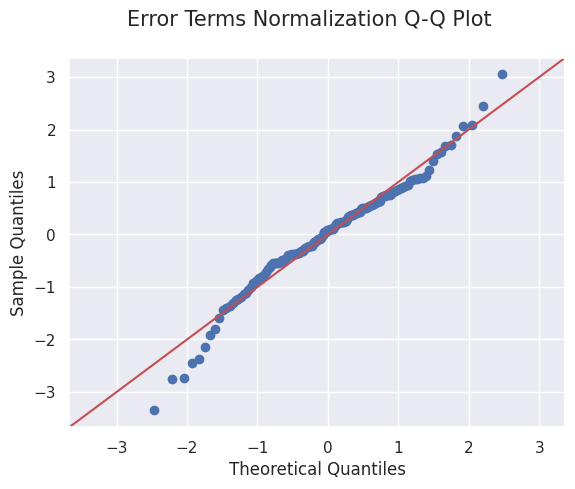

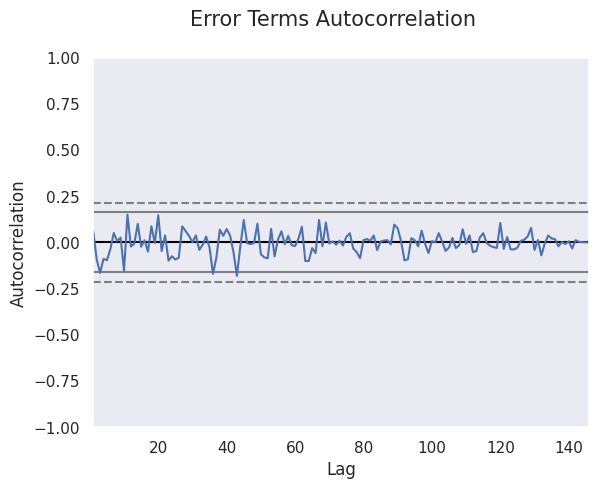

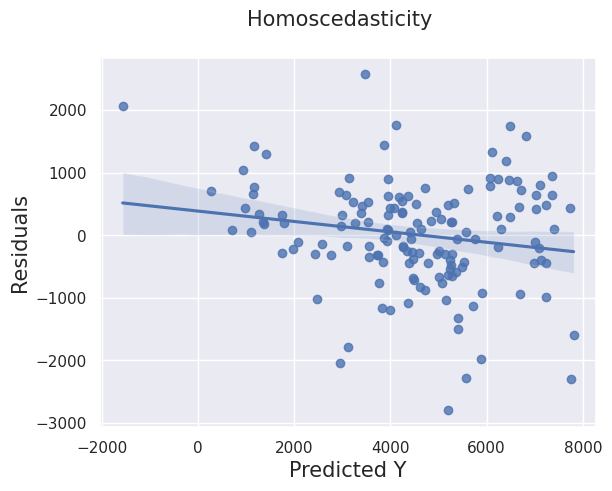


================= Prediction Evaluation Table Original Data ===================
+-------+------------+
|  R2   |    MSE     |
+=======+============+
| 0.793 | 702245.580 |
+-------+------------+

============================ Summary Standardised Data ============================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     117.0
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          4.23e-215
Time:                        13:47:40   Log-Likelihood:                -255.21
No. Observations:                 584   AIC:                             570.4
Df Residuals:                     554   BIC:                             701.5
Df Model:                          29                                         
Covarian

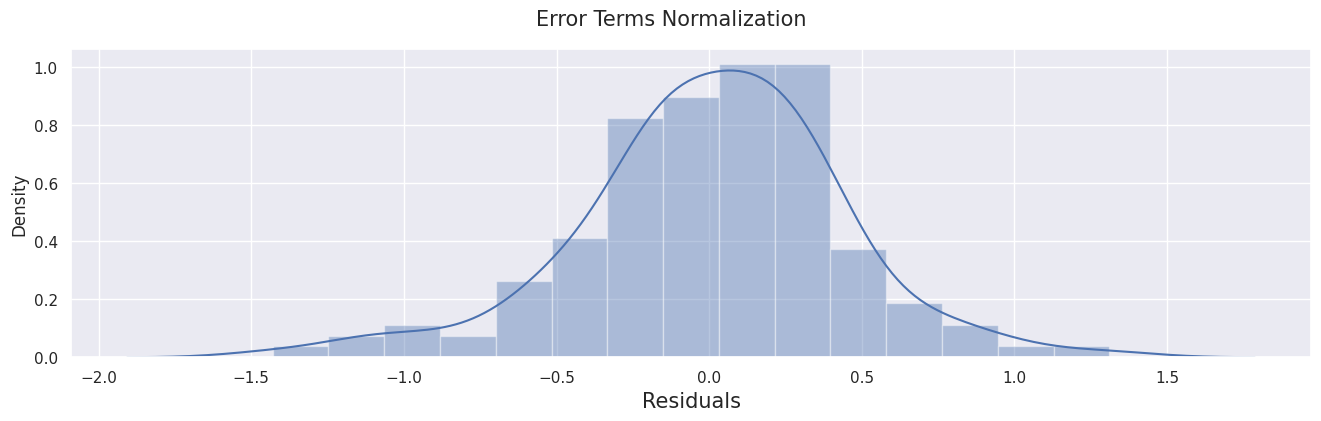

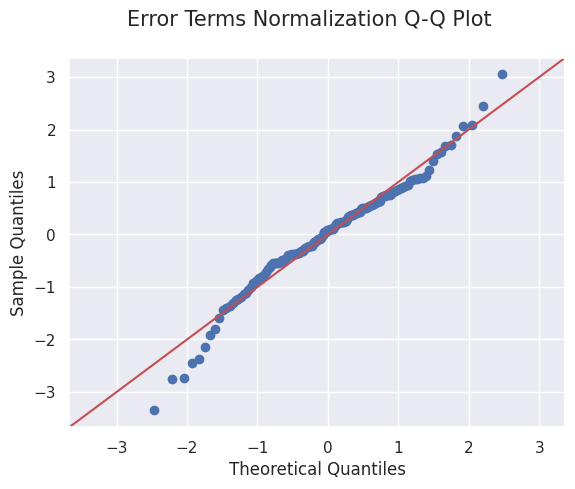

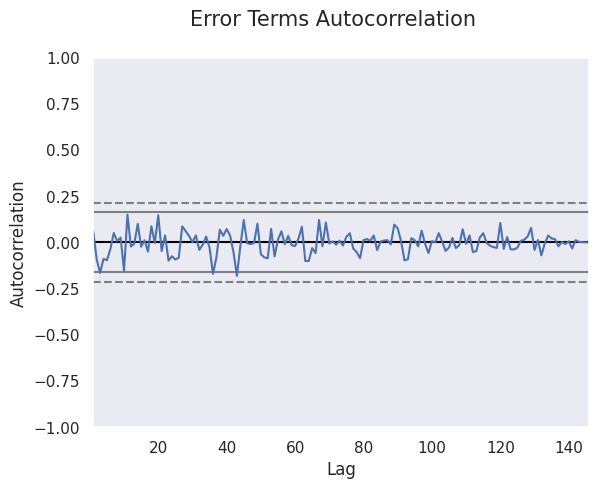

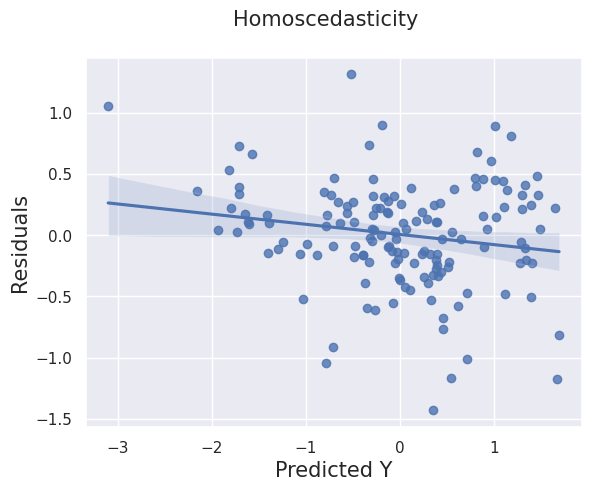


================= Prediction Evaluation Table Standardised Data ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.793 | 0.180 |
+-------+-------+

============================ Summary Normalised Data ============================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     117.0
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          4.23e-215
Time:                        13:47:42   Log-Likelihood:                 615.54
No. Observations:                 584   AIC:                            -1171.
Df Residuals:                     554   BIC:                            -1040.
Df Model:                          29                                         
Covariance Type:            non

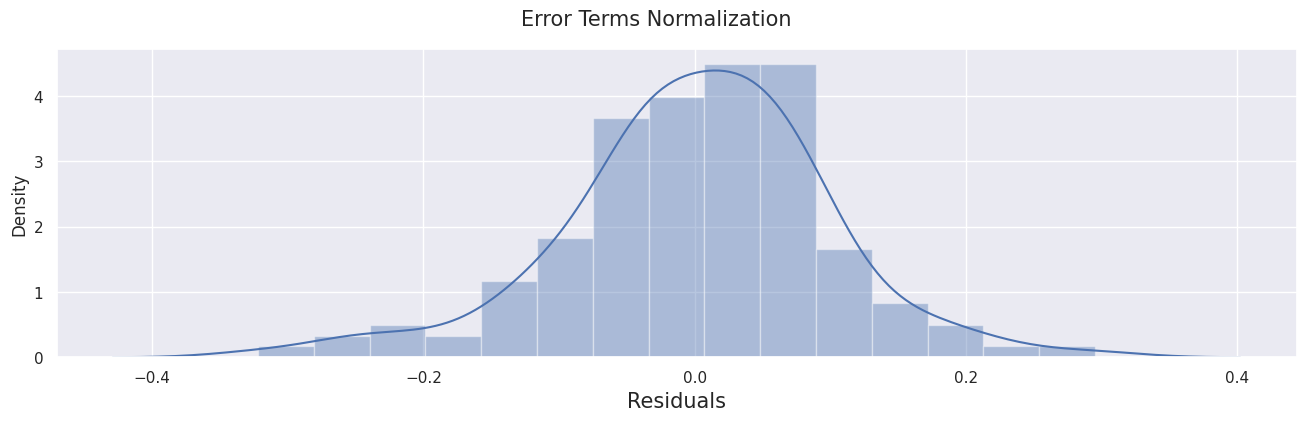

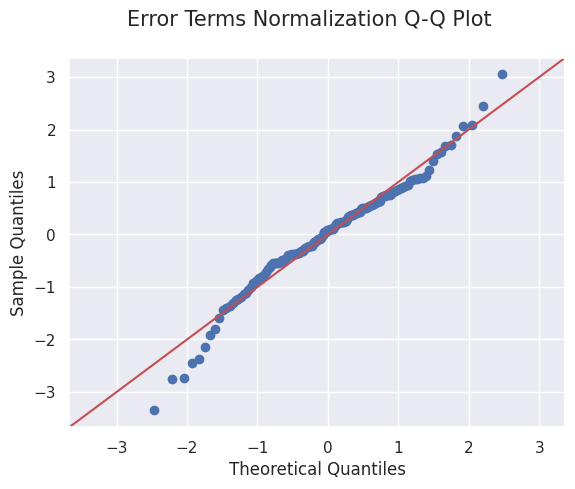

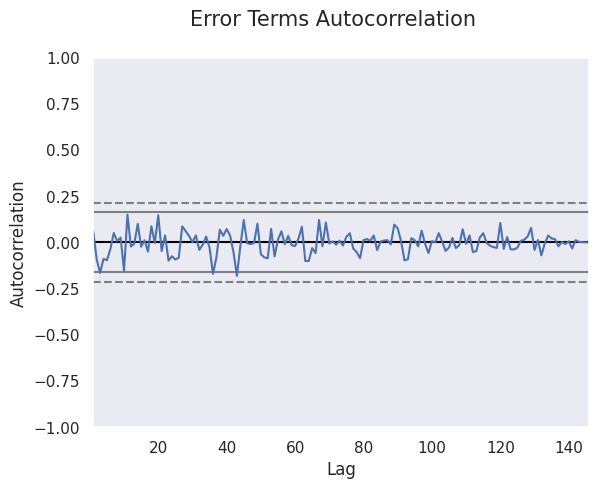

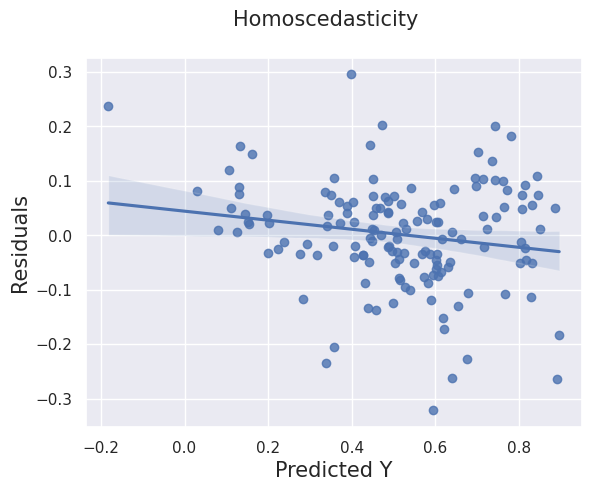


================= Prediction Evaluation Table Normalised Data ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.793 | 0.010 |
+-------+-------+


In [41]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

xDict = {"Temprature Ratio":"ratio_temp", "Feeling of Temprature in Celsius":"atemp",
          "Wind Speed":"windspeed", "Humidity":"hum", "Day of the Month":"day"}

yDict = {"Total number of users":"cnt"}


for j in yDict.keys():
    x = list(xDict.values()) + dummy_vars
    y = yDict[j]

    print(f"********************************************************************")

    x_train_sm = sm.add_constant(df_train[x])
    lr = sm.OLS(df_train[y], x_train_sm).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train[x], df_train[y])

    y_pred = lm.predict(df_test[x])
    ytest = df_test[y].reset_index(drop=True)

    predDF = pd.DataFrame(y_pred)
    predDF.columns=["pred"]
    predDF["res"] = ytest - predDF["pred"]

    print("\n============================ Summary Original Data ============================")
    print(lr.summary())

    print(f"\n================= Linear Assumption test Original Data ===================")

    residualAnalusis(lr, predDF, f"Original Data")

    print(f"\n================= Prediction Evaluation Table Original Data ===================")

    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())

    # ========================================================================================
    x_train_sm_sd = sm.add_constant(df_train_sd_dummy[x])
    lr_sd = sm.OLS(df_train_sd_dummy[y], x_train_sm_sd).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train_sd_dummy[x], df_train_sd_dummy[y])

    y_pred = lm.predict(df_test_sd_dummy[x])
    ytest = df_test_sd_dummy[y].reset_index(drop=True)

    predDF_sd = pd.DataFrame(y_pred)
    predDF_sd.columns=["pred"]
    predDF_sd["res"] = ytest - predDF_sd["pred"]

    print("\n============================ Summary Standardised Data ============================")
    print(lr_sd.summary())

    print(f"\n================= Linear Assumption test Standardised Data ===================")

    residualAnalusis(lr_sd, predDF_sd, f"Standardised Data")

    print(f"\n================= Prediction Evaluation Table Standardised Data ===================")

    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())

    # ========================================================================================
    x_train_sm_nrm = sm.add_constant(df_train_nrm_dummy[x])
    lr_nrm = sm.OLS(df_train_nrm_dummy[y], x_train_sm_nrm).fit()
    y_pred_nrm = lr_nrm.predict(x_train_sm_nrm)

    lm = LinearRegression()
    lm = lm.fit(df_train_nrm_dummy[x], df_train_nrm_dummy[y])

    y_pred = lm.predict(df_test_nrm_dummy[x])
    ytest = df_test_nrm_dummy[y].reset_index(drop=True)

    predDF_nrm = pd.DataFrame(y_pred)
    predDF_nrm.columns=["pred"]
    predDF_nrm["res"] = ytest - predDF_nrm["pred"]

    print("\n============================ Summary Normalised Data ============================")
    print(lr_nrm.summary())

    print(f"\n================= Linear Assumption test Normalised Data ===================")

    residualAnalusis(lr_nrm, predDF_nrm, f"Normalised Data")

    print(f"\n================= Prediction Evaluation Table Normalised Data ===================")

    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())



By adding these dummy variables the adjusted R2 improves from 0.49 to above 0.85. when we compare the results with scaled data we can see that coefficients been dramatically reduced incomparison with unscaled data in both scaling methods.

Checking the regression assumption indicates that:
1. residualls are normally distributed. The mean value is at zero for original data and slightly deviated in standardised data. But it is at -0.1 for normalized data.
2. the independence of residuals also seem to be respected for all three data types since the Auto correlation falls 95% confidence intervals. The Durbin Watson is also about 2.06.
3. in the case of homoscedasticity the standardised data is showing to be closest to haven uniform residuals against predicted values.

When we compare R2 and MSE for prediction we can see that standardised data has highest R2 (0.79) that has been improved in compare to all other models. When we compare MSE of the model in standardised data in this step and previous step we can see that it has also been reduced from 0.61 to 0.21.

Based on this and previous result adding dummy variables significantly improved model performance and also Normalization is not a good scaling technique for this data and we are removing it from the rest of the analysis.

When we look at the p-values of coefficients we can see that some of the features have p-values much higher than 0.05. So the correlation between dependent variable and these features is non significant and their removal may increase the level of adjusted R2. So we try manually remove them by using manual selection to confirm and improve our manual approach we later use RFE to automatically remove some other features and find the best feature combination for model.

## **Manual Feature selection using VIF**

### Drop values that are least helpful using p-value and VIF.

1.  correlation heatmap between x numerical variables for pairwise correlation. Since this is only between Nujmeric variables and it only considers pairwise correlations we are adding the combination of P-value and VIF as cokmplementary approach for  feature selection.
2.  checking the VIF: used to identify independent variables that are dependent upon a combination of other variables. It will explain how welll one independent variable is explained by all the other independent variables.
*   greater than 10:  Definitely high VIF value and the variable should be eliminated.
*   greater than 5:  Can be okay, but it is worth inspecting.
*   less than 5: Good VIF value. No need to eliminate this variable.

3. we can use the combination of p-value and VIF to select features that are important.
The selection criteria is as follow:
>  **1. High p-value, high vif (remove)**

>  **2. High, low**
1. High p-val, low vif (remove these first)
2. Low p, high vif (remove these after the one above)
3. Low p val, low vif (keep)


4. the process is as follow:
> 1. Build the model with all the features

> 2. Drop the features that are least helpful in prediction (high p-value)

> 3. Drop the features that are redundant (using correlations and VIF)

> 4. Rebuild model and repeat.


In [42]:
x = list(xDict.values()) + dummy_vars

coefDf_org = pd.DataFrame()
coefDf_org["pval"] = lr.pvalues
coefDf_org = coefDf_org.reindex(x)

coefDf_org["VIF"] = list(map(lambda i: variance_inflation_factor(df_train[x].values, i), range(len(x))))
coefDf_org["VIF"] = round(coefDf_org["VIF"], 2)
coefDf_org = coefDf_org.sort_values(by=["VIF","pval"], ascending = False)


coefDf_sd = pd.DataFrame()
coefDf_sd["pval"] = lr_sd.pvalues
coefDf_sd = coefDf_sd.reindex(x)

coefDf_sd["VIF"] = list(map(lambda i: variance_inflation_factor(df_train_sd_dummy[x].values, i), range(len(x))))
coefDf_sd["VIF"] = round(coefDf_sd["VIF"], 2)
coefDf_sd = coefDf_sd.sort_values(by=["VIF","pval"], ascending = False)

In [43]:
coefDf_org

pval     VIF
workingday   7.526373e-06  212.89
sunday       8.010555e-01   48.15
saturday     2.865535e-05   46.97
spring       3.080291e-02   10.79
holiday      3.442256e-01   10.24
winter       2.156851e-05    8.83
summer       1.024698e-01    8.27
Oct          6.719640e-01    6.86
Nov          1.399667e-01    6.40
atemp        2.694378e-24    6.25
Aug          5.086879e-01    6.10
Jan          8.440918e-02    6.08
Dec          9.893572e-02    5.82
July         3.287497e-01    5.48
Sep          7.529769e-03    4.92
Feb          3.616389e-01    4.86
Mar          8.739978e-01    3.50
Jun          5.289497e-01    2.71
May          2.908645e-01    2.26
hum          6.187054e-05    2.12
monday       9.101267e-02    1.99
wednesday    6.170335e-01    1.96
thurseday    5.085199e-01    1.86
tuesday      1.078171e-01    1.84
mist         2.082523e-09    1.65
ratio_temp   9.270505e-04    1.34
windspeed    3.127566e-13    1.31
light_rain   2.763925e-23    1.30
yr          7.113048e-123    1.06
day          2.524756e-01    1.02

In [44]:
coefDf_sd

pval    VIF
workingday   1.385435e-01  44.60
spring       3.080291e-02  10.79
sunday       9.324158e-06   9.97
saturday     2.898104e-01   9.95
winter       2.156851e-05   8.83
summer       1.024698e-01   8.27
Oct          6.719640e-01   6.86
Nov          1.399667e-01   6.40
atemp        2.694378e-24   6.25
Aug          5.086879e-01   6.10
Jan          8.440918e-02   6.08
Dec          9.893572e-02   5.82
July         3.287497e-01   5.48
Sep          7.529769e-03   4.92
Feb          3.616389e-01   4.86
Mar          8.739978e-01   3.50
holiday      2.227939e-04   3.03
Jun          5.289497e-01   2.71
May          2.908645e-01   2.26
hum          6.187054e-05   2.12
monday       9.101267e-02   1.99
wednesday    6.170335e-01   1.96
thurseday    5.085199e-01   1.86
tuesday      1.078171e-01   1.84
mist         2.082523e-09   1.65
ratio_temp   9.270505e-04   1.34
windspeed    3.127566e-13   1.31
light_rain   2.763925e-23   1.30
yr          7.113048e-123   1.06
day          2.524756e-01   1.02

Select features with high VIF and high p_values for each data type



In [45]:
removingF = coefDf_org[(coefDf_org.VIF>10)&(coefDf_org.pval>0.05)].index
print(removingF)

removingF_sd = coefDf_sd[(coefDf_sd.VIF>10)&(coefDf_sd.pval>0.05)].index
print("\n", removingF_sd)

Index(['sunday', 'holiday'], dtype='object')

 Index(['workingday'], dtype='object')


 sunday and holiday are identified as insignificant and redundant factors in original dataset and workingday for standardised data

<IPython.core.display.Javascript object>

*********************************** Total number of users *********************************

================= Summary Original Data sunday and holiday Removed by VIF ===================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     121.2
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          6.22e-216
Time:                        13:47:45   Log-Likelihood:                -4682.0
No. Observations:                 584   AIC:                             9422.
Df Residuals:                     555   BIC:                             9549.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef  

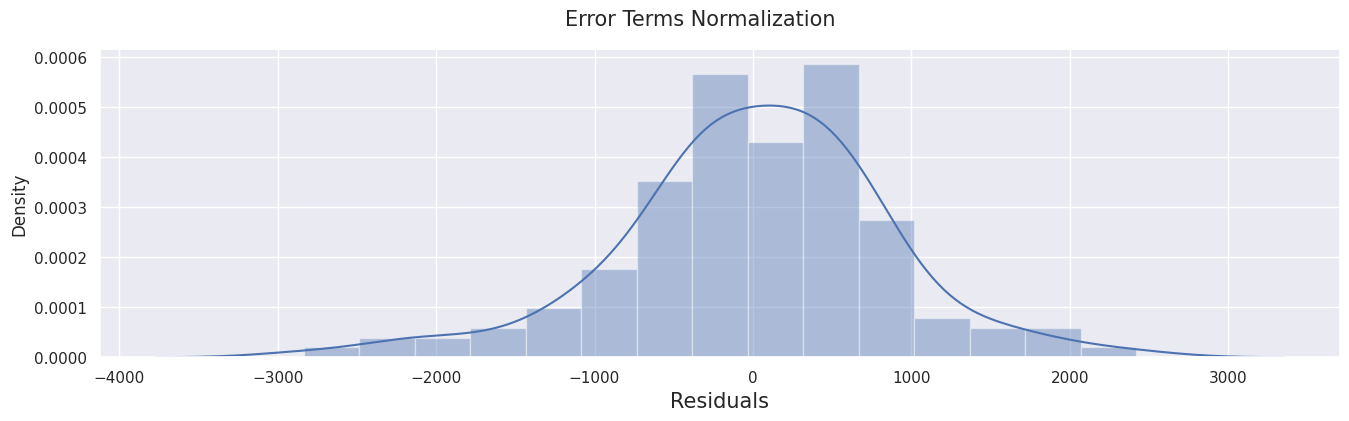

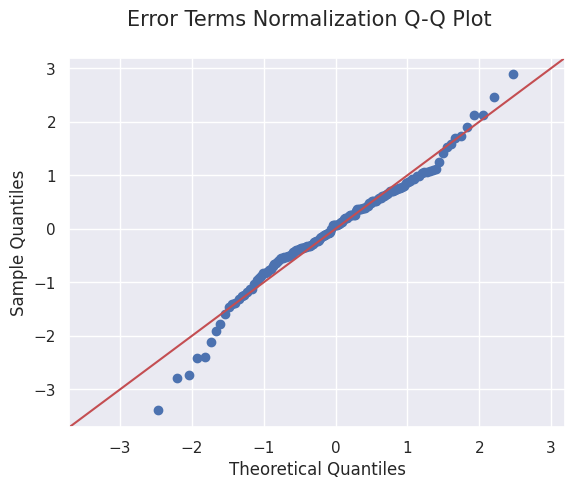

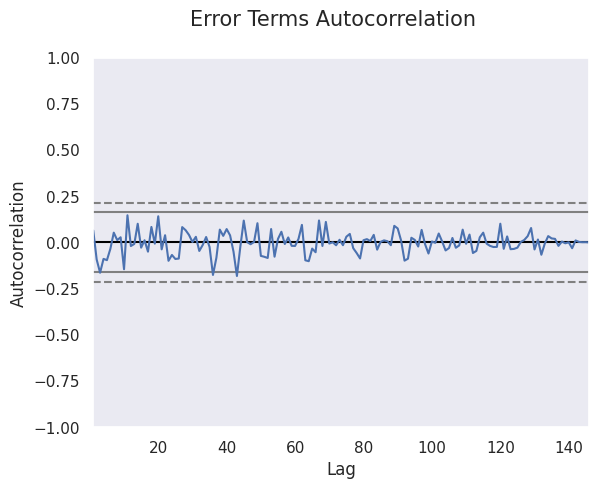

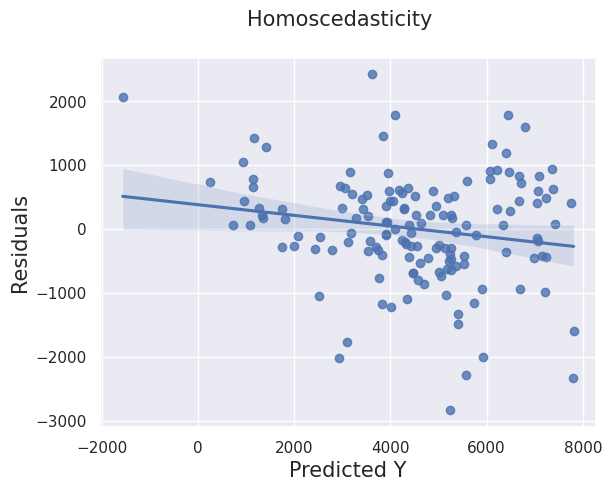


================= Evaluation Table Original Data sunday and holiday Removed by VIF ===================
+-------+------------+
|  R2   |    MSE     |
+=======+============+
| 0.794 | 700609.060 |
+-------+------------+

================= Summary Standardised Data workingday Removed by VIF =================
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     117.0
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          4.23e-215
Time:                        13:47:48   Log-Likelihood:                -255.21
No. Observations:                 584   AIC:                             570.4
Df Residuals:                     554   BIC:                             701.5
Df Model:                          29                       

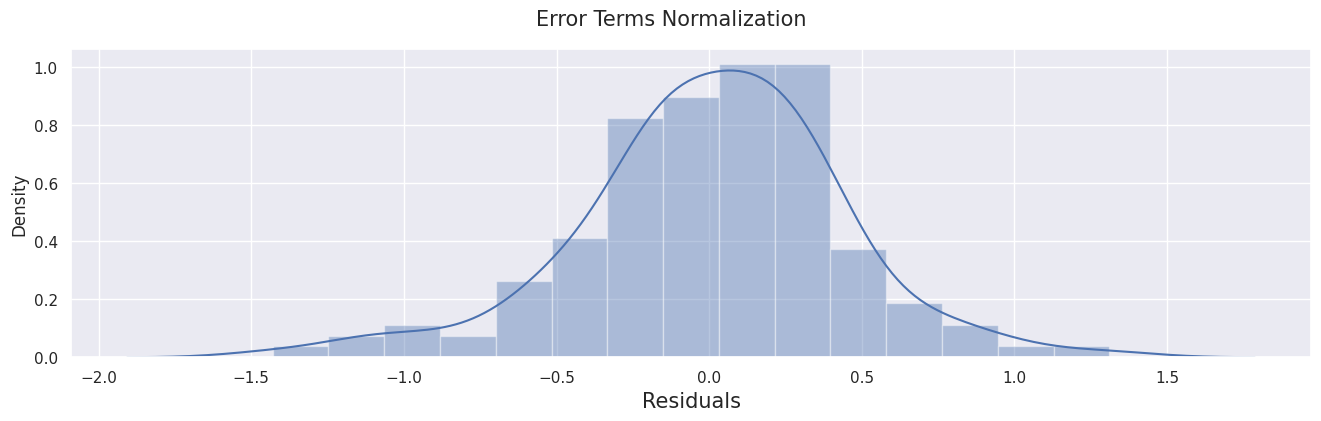

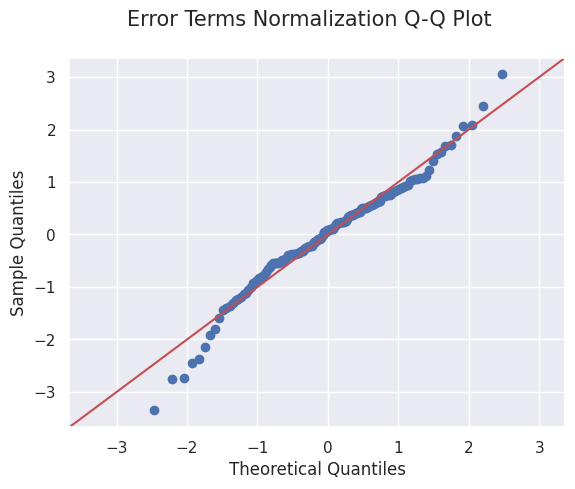

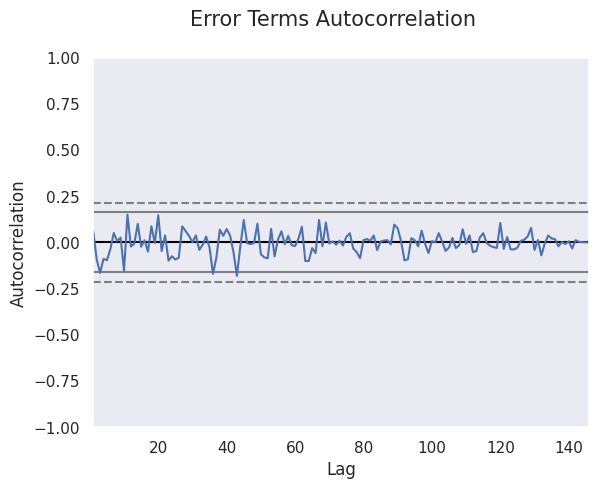

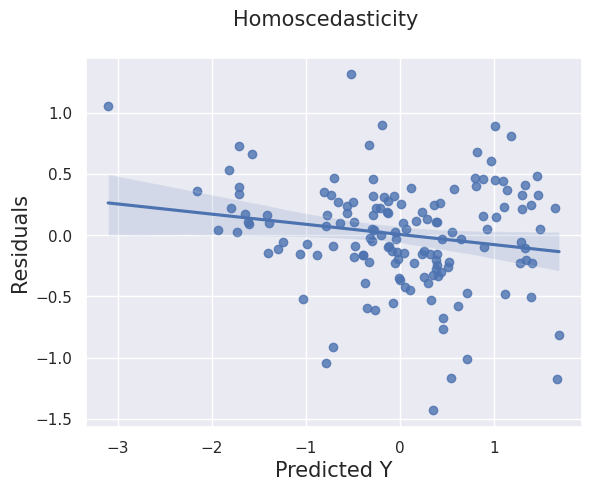


================= Evaluation Table Standardised Data workingday Removed by VIF ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.793 | 0.180 |
+-------+-------+


In [46]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))


yDict = {"Total number of users":"cnt"}

for j in yDict.keys():

    y = yDict[j]

    # remList = []

    print(f"********************************************************************")
    x1 = list(xDict.values()) + dummy_vars
    # x1.remove(removingF[0])
    x1 = list(set(x1)- set(removingF))
    x_train_sm = sm.add_constant(df_train[x1])
    lr = sm.OLS(df_train[y], x_train_sm).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train[x1], df_train[y])

    y_pred = lm.predict(df_test[x1])
    ytest = df_test[y].reset_index(drop=True)

    predDF = pd.DataFrame(y_pred)
    predDF.columns=["pred"]
    predDF["res"] = ytest - predDF["pred"]

    print(f"\n================= Summary Original Data {removingF[0]} and {removingF[1]} Removed by VIF ===================")
    print(lr.summary())

    print(f"\n================= Linear Assumption test Original Data {removingF[0]} and {removingF[1]} Removed by VIF ===================")

    residualAnalusis(lr, predDF, f"Original Data")

    print(f"\n================= Evaluation Table Original Data {removingF[0]} and {removingF[1]} Removed by VIF ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())


    # ========================================================================================
    x2 = list(xDict.values()) + dummy_vars
    # x2.remove(removingF_sd[0])
    x2 = list(set(x2)- set(removingF_sd))

    x_train_sm_sd = sm.add_constant(df_train_sd_dummy[x2])
    lr_sd = sm.OLS(df_train_sd_dummy[y], x_train_sm_sd).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train_sd_dummy[x2], df_train_sd_dummy[y])

    y_pred = lm.predict(df_test_sd_dummy[x2])
    ytest = df_test_sd_dummy[y].reset_index(drop=True)

    predDF_sd = pd.DataFrame(y_pred)
    predDF_sd.columns=["pred"]
    predDF_sd["res"] = ytest - predDF_sd["pred"]

    print(f"\n================= Summary Standardised Data {removingF_sd[0]} Removed by VIF =================")
    print(lr_sd.summary())


    print(f"\n================= Linear Assumption test Standardised Data {removingF_sd[0]} Removed by VIF ===================")

    residualAnalusis(lr_sd, predDF_sd, f"Standardised Data")

    print(f"\n================= Evaluation Table Standardised Data {removingF_sd[0]} Removed by VIF ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())


In the case of original I also tried removing the 2 VIF removing factors step by step but the result was the same. So I have removed both holiday and sunday together.

The both adjusted R2 and prediction R2 didnot change by this method  both of the data set: original and standardised.

Non of the linearity assumptions also did not changed in this method from previous method.

Predicted R2 is 1% better in original data than standardised data

Repeat previous steps.

In [47]:
# x = list(xDict.values()) + dummy_vars

coefDf_org = pd.DataFrame()
coefDf_org["pval"] = lr.pvalues
coefDf_org = coefDf_org.reindex(x1)

coefDf_org["VIF"] = list(map(lambda i: variance_inflation_factor(df_train[x1].values, i), range(len(x1))))
coefDf_org["VIF"] = round(coefDf_org["VIF"], 2)
coefDf_org = coefDf_org.sort_values(by = "VIF", ascending = False)


coefDf_sd = pd.DataFrame()
coefDf_sd["pval"] = lr_sd.pvalues
coefDf_sd = coefDf_sd.reindex(x2)

coefDf_sd["VIF"] = list(map(lambda i: variance_inflation_factor(df_train_sd_dummy[x2].values, i), range(len(x2))))
coefDf_sd["VIF"] = round(coefDf_sd["VIF"], 2)
coefDf_sd = coefDf_sd.sort_values(by = "VIF", ascending = False)


Select features with high VIF and high p_values for each data type

In [48]:
removingF = coefDf_org[(coefDf_org.VIF>10)&(coefDf_org.pval>0.05)].index
print(removingF)

removingF_sd = coefDf_sd[(coefDf_sd.VIF>10)&(coefDf_sd.pval>0.05)].index
print("\n", removingF_sd)

Index([], dtype='object')

 Index([], dtype='object')


This time VIF did not find any feature that is high in p-value and high in VIF.

So decided to move to automatic feature selection using RFE. We know that all the features with low VIF (<5) and low p-value (<0.05) should be kept. So I try to find the number of these features in VIF to set the RFE feature number at higher than those numbers. Since I only carried on VIF till p-values >0.05 So I'll use all P-values <0.05 and VIF bellow 10 as criteria for number of features to select.

---



In [49]:
keepingF = coefDf_org[(coefDf_org.VIF<5)&(coefDf_org.pval<0.05)].index
# keepingF = coefDf_org[(coefDf_org.pval<0.05)].index
print(f"Most important features for original data selected by VIF {len(keepingF)} features:", *keepingF)

keepingF_sd = coefDf_sd[(coefDf_sd.VIF<5)&(coefDf_sd.pval<0.05)].index
# keepingF_sd = coefDf_sd[(coefDf_sd.pval<0.05)].index
print(f"\n Most important features for standardised data selected by VIF {len(keepingF_sd)} features:", *keepingF_sd)

Most important features for original data selected by VIF 6 features: mist yr tuesday monday saturday light_rain

 Most important features for standardised data selected by VIF 9 features: mist yr sunday hum Sep light_rain ratio_temp windspeed holiday


Based on this the most important and non redundant features selected by VIF for origibal data are 6 features including:
mist, yr, tuesday, monday, saturday and light-rain

and for standardised dataset are mist, yr, sunday, hum, sep, light_rain, ratio_temp, windspeed and holiday

## **Automatic Feature Selection using RFE**

<IPython.core.display.Javascript object>

*********************************** Total number of users Vs. Season *********************************
       Feature  Chosen  Rank
23    saturday    True     1
27      sunday    True     1
26  light_rain    True     1
16      spring    True     1
7   workingday    True     1
12     holiday    True     1
15          yr   False     2
5          Nov   False     3
21         Jan   False     4
24         Dec   False     5
28         Sep   False     6
25         Jun   False     7
8         July   False     8
29         Aug   False     9
20         May   False    10
18      winter   False    11
19         Feb   False    12
6         mist   False    13
10      monday   False    14
0   ratio_temp   False    15
14     tuesday   False    16
9       summer   False    17
1        atemp   False    18
11   thurseday   False    19
13   wednesday   False    20
2    windspeed   False    21
17         Mar   False    22
22         Oct   False    23
3          hum   False    24
4          day   False    2

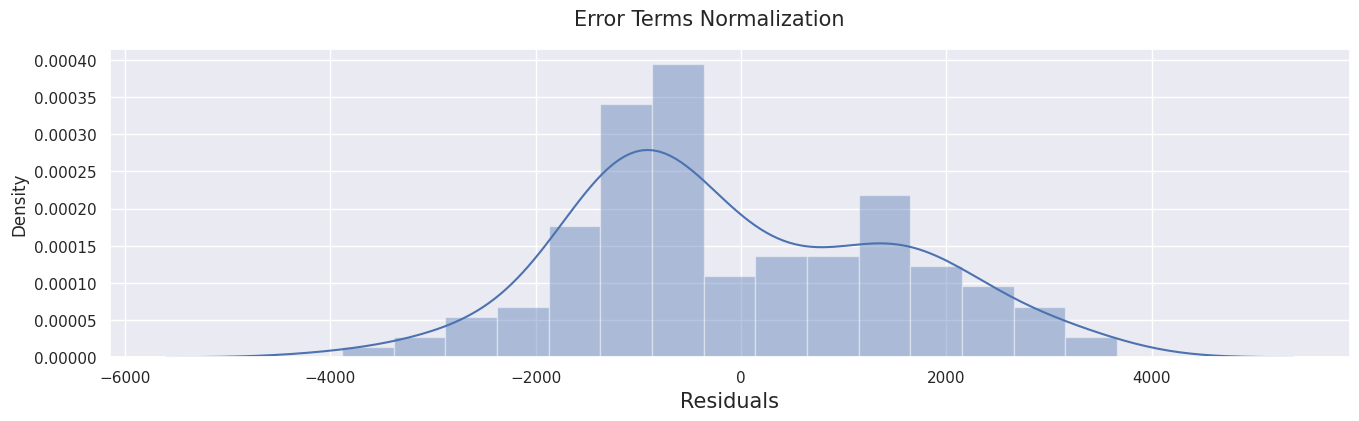

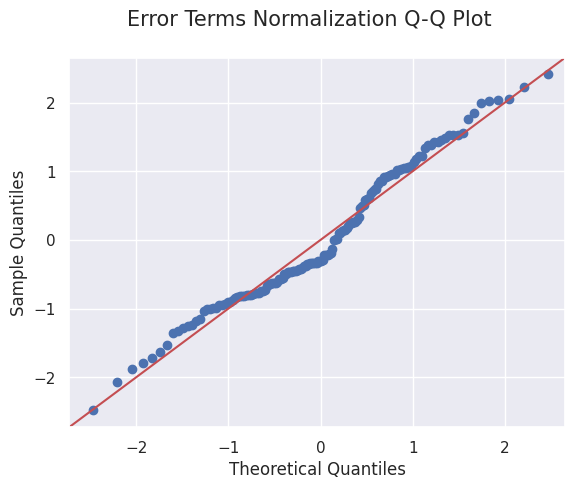

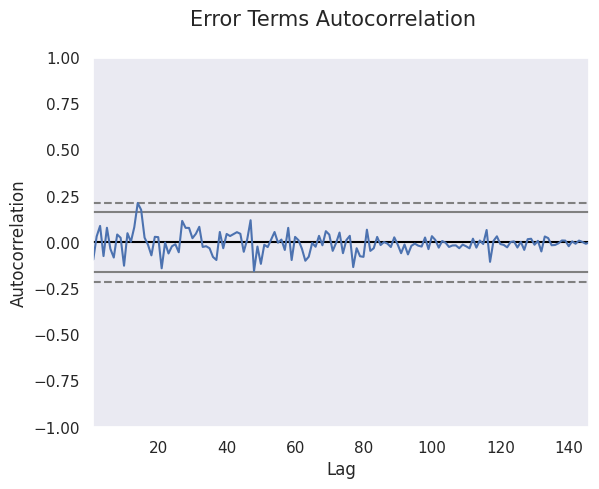

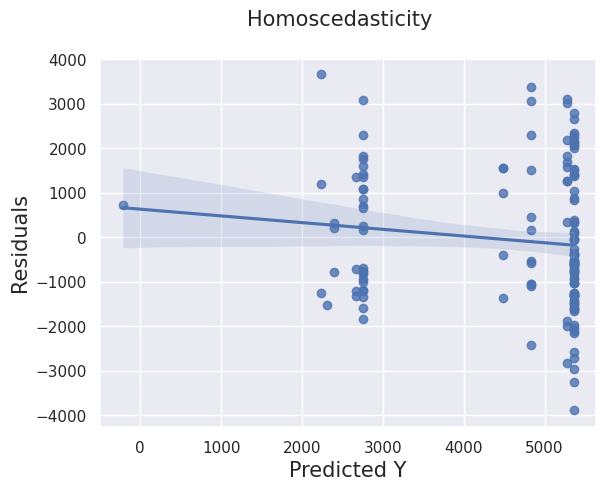


================= Evaluation Table Original Data ===================
+-------+-------------+
|  R2   |     MSE     |
+=======+=============+
| 0.298 | 2382716.540 |
+-------+-------------+
       Feature  Chosen  Rank
29          yr    True     1
13     holiday    True     1
11       atemp    True     1
10         Sep    True     1
20      spring    True     1
15  light_rain    True     1
16        mist    True     1
27      winter    True     1
4         July    True     1
19    saturday   False     2
28  workingday   False     3
8          Nov   False     4
1          Dec   False     5
3          Jan   False     6
2          Feb   False     7
26   windspeed   False     8
21      summer   False     9
14         hum   False    10
22      sunday   False    11
17      monday   False    12
24     tuesday   False    13
18  ratio_temp   False    14
7          May   False    15
0          Aug   False    16
5          Jun   False    17
9          Oct   False    18
23   thurseday   False    1

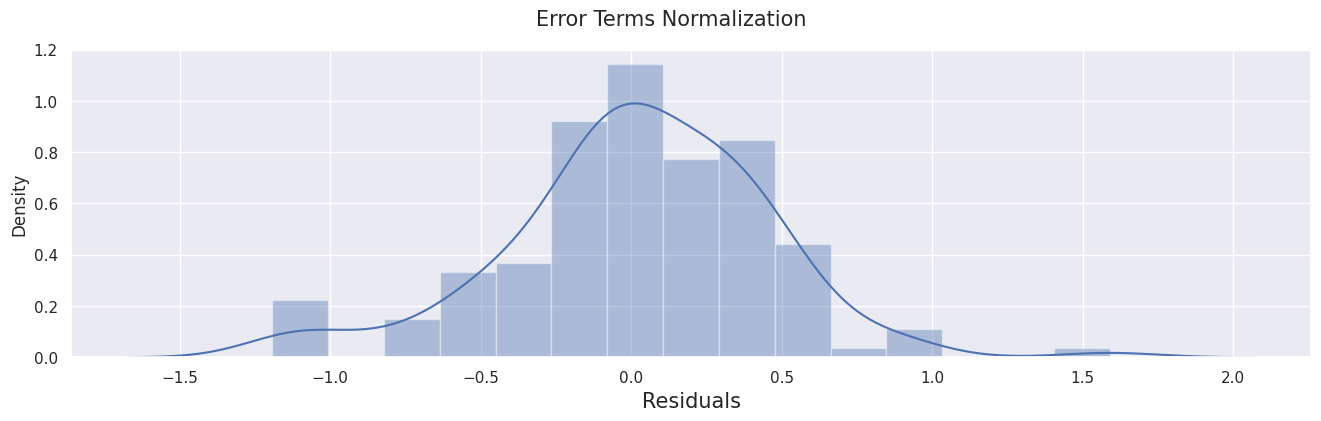

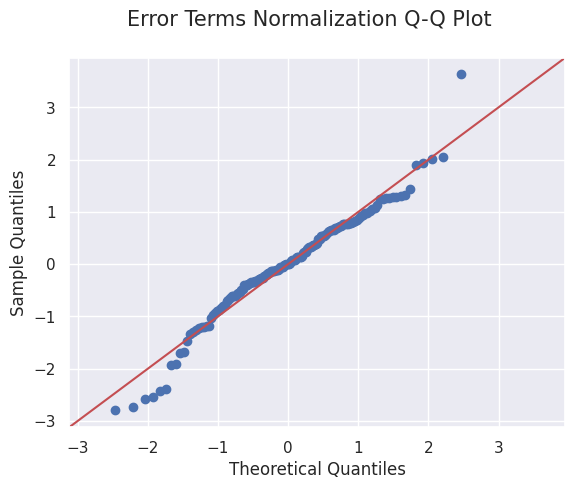

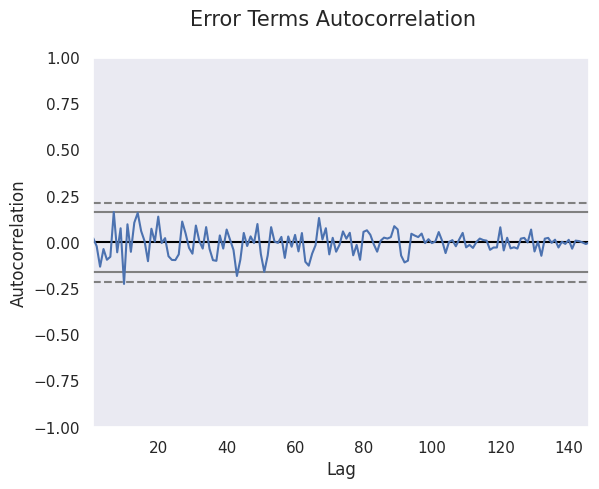

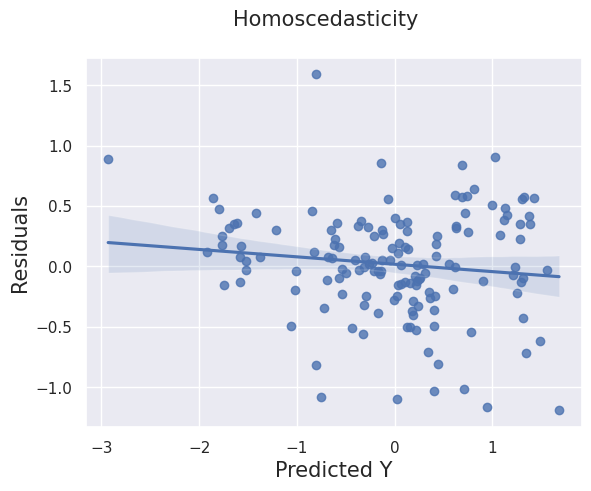


================= Evaluation Table Standardised Data ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.788 | 0.190 |
+-------+-------+


In [50]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

xDict = {"Temprature Ratio":"ratio_temp", "Feeling of Temprature in Celsius":"atemp",
          "Wind Speed":"windspeed", "Humidity":"hum", "Day of the Month":"day"}

yDict = {"Total number of users":"cnt"}

for j in yDict.keys():

    x = list(xDict.values()) + dummy_vars
    y = yDict[j]

    n = len(keepingF)

    print(f"********************************************************************")

    lm = LinearRegression()
    lm = lm.fit(df_train[x], df_train[y])

    rfe = RFE(lm, n_features_to_select=n)
    rfe = rfe.fit(df_train[x], df_train[y])

    print(pd.DataFrame(list(zip(x ,rfe.support_,rfe.ranking_)), columns=["Feature", "Chosen", "Rank"]).sort_values("Rank"))

    col = df_train[x].columns[rfe.support_]
    # print(col)

    # print(df_train[x].columns[~rfe.support_])

    x_train_sm = sm.add_constant(df_train[col])
    lr = sm.OLS(df_train[y], x_train_sm).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train[col], df_train[y])

    y_pred = lm.predict(df_test[col])
    ytest = df_test[y].reset_index(drop=True)

    predDF = pd.DataFrame(y_pred)
    predDF.columns=["pred"]
    predDF["res"] = ytest - predDF["pred"]

    print(f"{len(keepingF)} Most important features for original data selected by REF:", *col)

    # print("Features that has been Removed", df_train[x].columns[~rfe.support_].tolist())

    print(f"\n================= Summary Original Data  ===================")
    print(lr.summary())

    print(f"\n================= Linear Assumption test Original Data ===================")

    residualAnalusis(lr, predDF, f"Original Data")


    print(f"\n================= Evaluation Table Original Data ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())


    # ========================================================================================

    n = len(keepingF_sd)

    lm_sd = LinearRegression()
    lm_sd = lm_sd.fit(df_train_sd_dummy[x], df_train_sd_dummy[y])

    rfe_sd = RFE(lm_sd, n_features_to_select=n)
    rfe_sd = rfe_sd.fit(df_train_sd_dummy[x], df_train_sd_dummy[y])

    print(pd.DataFrame(sorted(list(zip(x ,rfe_sd.support_,rfe_sd.ranking_))), columns=["Feature", "Chosen", "Rank"]).sort_values("Rank"))

    col = df_train_sd_dummy[x].columns[rfe_sd.support_]

    x_train_sm_sd = sm.add_constant(df_train_sd_dummy[col])
    lr_sd = sm.OLS(df_train_sd_dummy[y], x_train_sm_sd).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train_sd_dummy[col], df_train_sd_dummy[y])

    y_pred = lm.predict(df_test_sd_dummy[col])
    ytest = df_test_sd_dummy[y].reset_index(drop=True)

    predDF_sd = pd.DataFrame(y_pred)
    predDF_sd.columns=["pred"]
    predDF_sd["res"] = ytest - predDF_sd["pred"]

    # print("Features that has been Removed", df_train_sd_dummy[x].columns[~rfe.support_].tolist())

    print(f"{len(keepingF_sd)} Most important features for standardised data selected by REF:", *col)

    print(f"\n================= Summary Standardised Data =================")
    print(lr_sd.summary())

    print(f"\n================= Linear Assumption test Standardised Data ===================")

    residualAnalusis(lr_sd, predDF_sd, f"Standardised Data")


    print(f"\n================= Evaluation Table Standardised Data ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())


When we compare 6 most important features selected by VIF with RFE for original data only yr and Light-rain are existed in both set .

When we look at those values for 9 important features in standardised data we can see yr, holiday, sep, light-rain, mist to be overlaped in the feature importance selected by VIF and RFE.

## Change number of features to 29 features to be selected

<IPython.core.display.Javascript object>

*********************************** Total number of users *********************************
       Feature  Chosen  Rank
0   ratio_temp    True     1
27      sunday    True     1
26  light_rain    True     1
25         Jun    True     1
24         Dec    True     1
23    saturday    True     1
22         Oct    True     1
21         Jan    True     1
20         May    True     1
19         Feb    True     1
18      winter    True     1
17         Mar    True     1
16      spring    True     1
15          yr    True     1
14     tuesday    True     1
13   wednesday    True     1
12     holiday    True     1
11   thurseday    True     1
10      monday    True     1
9       summer    True     1
8         July    True     1
7   workingday    True     1
6         mist    True     1
5          Nov    True     1
3          hum    True     1
2    windspeed    True     1
1        atemp    True     1
28         Sep    True     1
29         Aug    True     1
4          day   False     2
Features 

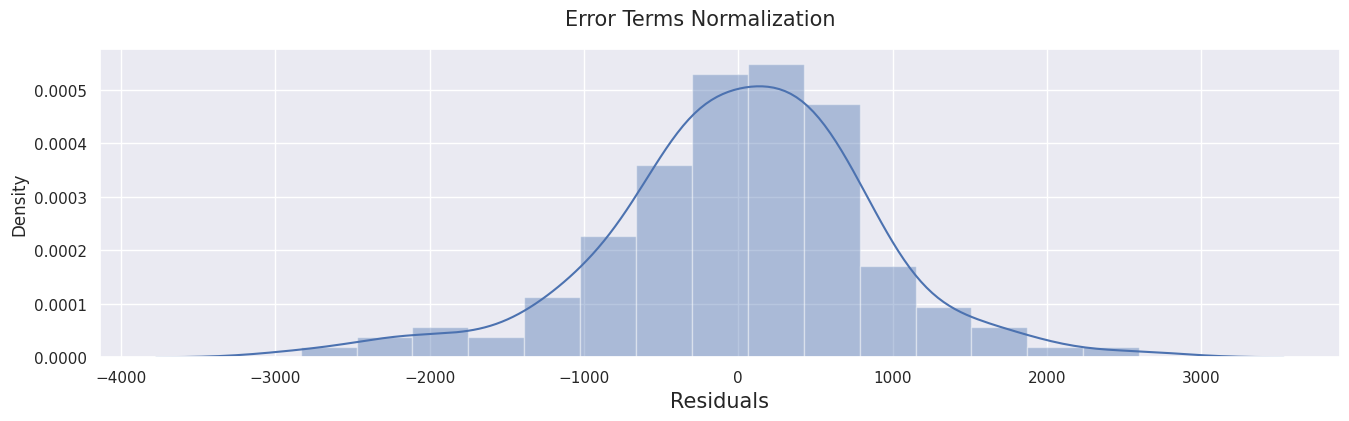

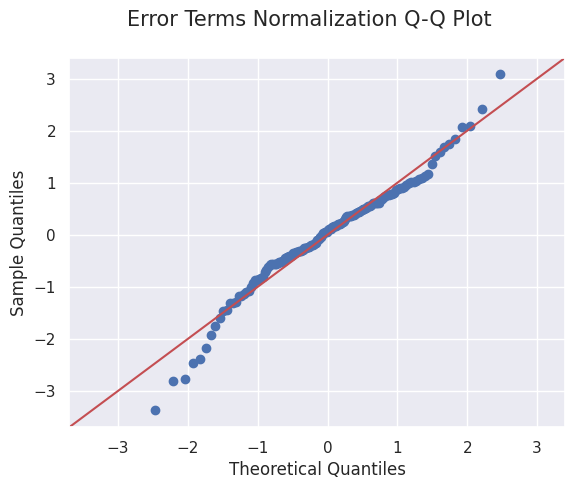

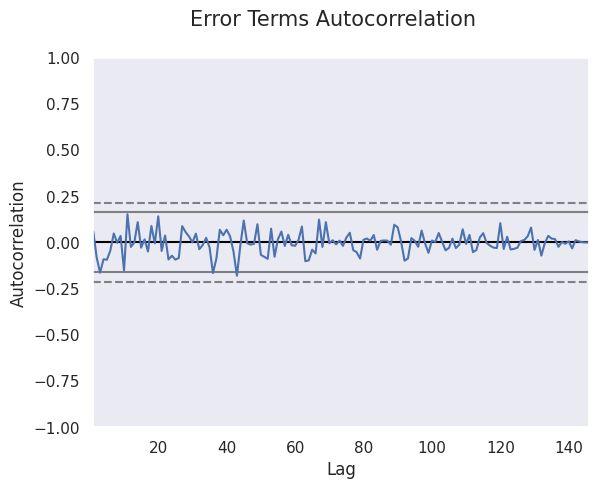

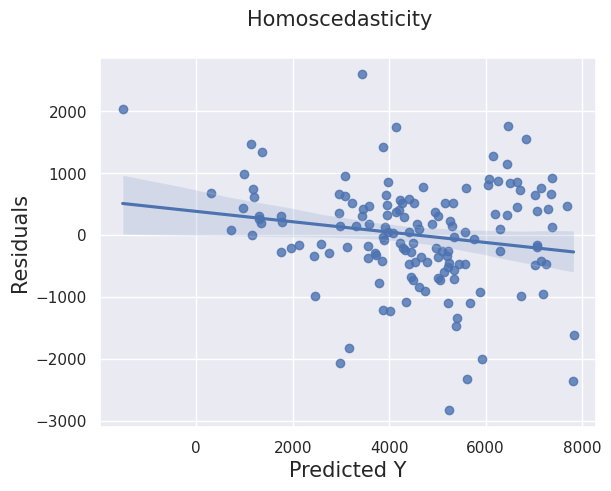


================= Evaluation Table Original Data ===================
+-------+------------+
|  R2   |    MSE     |
+=======+============+
| 0.791 | 709046.510 |
+-------+------------+
       Feature  Chosen  Rank
0          Aug    True     1
27      winter    True     1
26   windspeed    True     1
25   wednesday    True     1
24     tuesday    True     1
23   thurseday    True     1
22      sunday    True     1
21      summer    True     1
20      spring    True     1
19    saturday    True     1
18  ratio_temp    True     1
17      monday    True     1
16        mist    True     1
15  light_rain    True     1
14         hum    True     1
13     holiday    True     1
12         day    True     1
11       atemp    True     1
10         Sep    True     1
9          Oct    True     1
8          Nov    True     1
7          May    True     1
5          Jun    True     1
4         July    True     1
3          Jan    True     1
2          Feb    True     1
1          Dec    True     1
28 

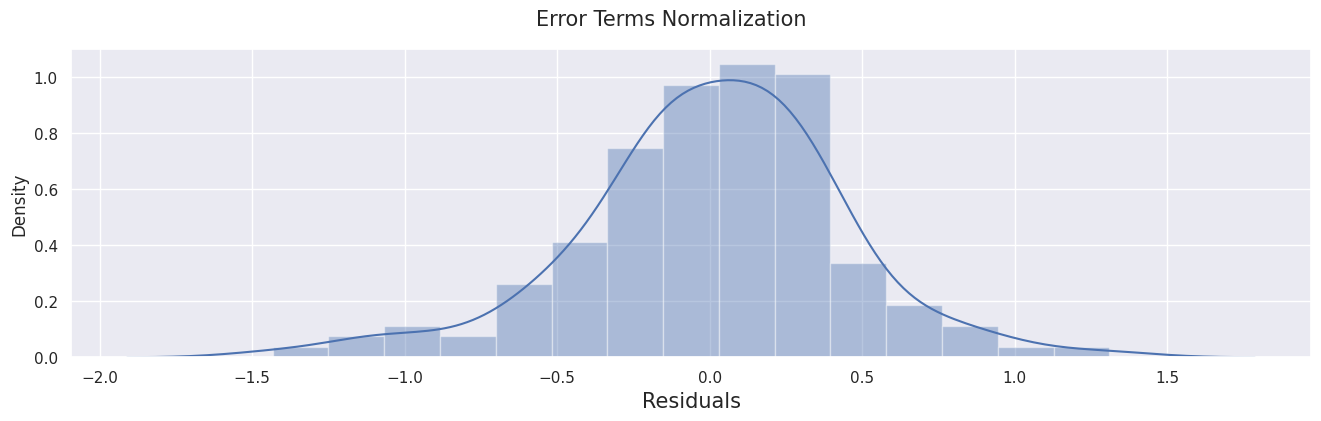

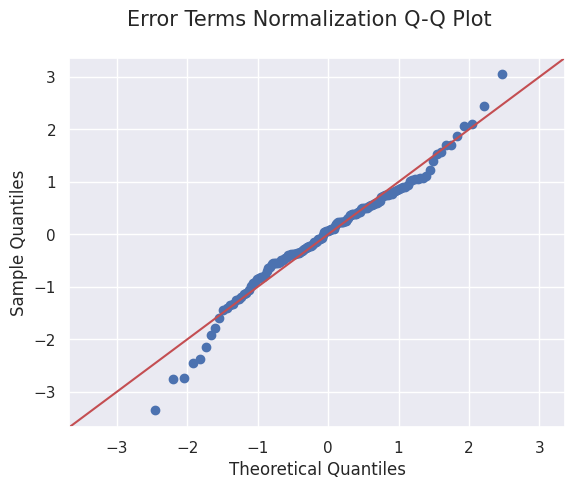

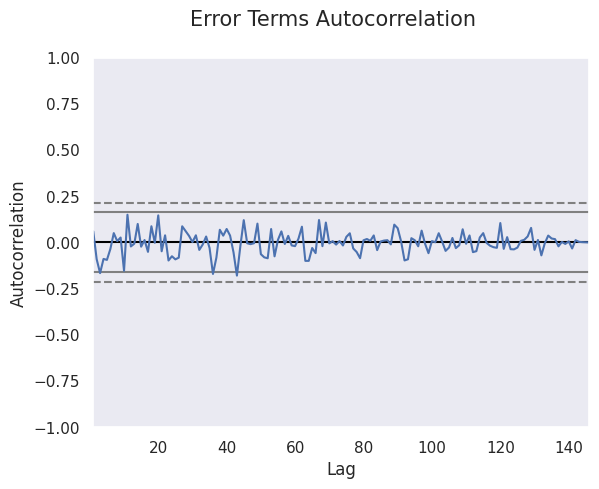

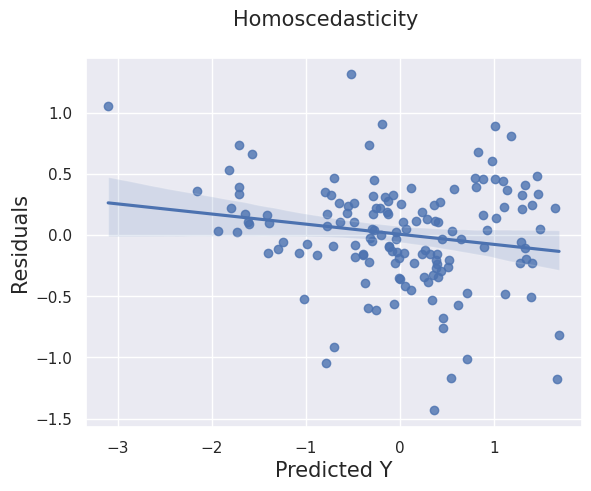


================= Evaluation Table Standardised Data ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.793 | 0.180 |
+-------+-------+


In [51]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

xDict = {"Temprature Ratio":"ratio_temp", "Feeling of Temprature in Celsius":"atemp",
          "Wind Speed":"windspeed", "Humidity":"hum", "Day of the Month":"day"}

yDict = {"Total number of users":"cnt"}

for j in yDict.keys():

    x = list(xDict.values()) + dummy_vars
    y = yDict[j]

    n = 29

    print(f"********************************************************************")

    lm = LinearRegression()
    lm = lm.fit(df_train[x], df_train[y])

    rfe = RFE(lm, n_features_to_select=n)
    rfe = rfe.fit(df_train[x], df_train[y])

    print(pd.DataFrame(list(zip(x ,rfe.support_,rfe.ranking_)), columns=["Feature", "Chosen", "Rank"]).sort_values("Rank"))

    col = df_train[x].columns[rfe.support_]
    # print(col)

    x_train_sm = sm.add_constant(df_train[col])
    lr = sm.OLS(df_train[y], x_train_sm).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train[col], df_train[y])

    y_pred = lm.predict(df_test[col])
    ytest = df_test[y].reset_index(drop=True)

    predDF = pd.DataFrame(y_pred)
    predDF.columns=["pred"]
    predDF["res"] = ytest - predDF["pred"]

    print("Features that has been Removed", df_train[x].columns[~rfe.support_].tolist())

    print(f"\n================= Summary Original Data  ===================")
    print(lr.summary())

    print(f"\n================= Linear Assumption test Original Data ===================")

    residualAnalusis(lr, predDF, f"Original Data")

    print(f"\n================= Evaluation Table Original Data ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())

    # ========================================================================================

    lm_sd = LinearRegression()
    lm_sd = lm_sd.fit(df_train_sd_dummy[x], df_train_sd_dummy[y])

    rfe_sd = RFE(lm_sd, n_features_to_select=n)
    rfe_sd = rfe_sd.fit(df_train_sd_dummy[x], df_train_sd_dummy[y])

    print(pd.DataFrame(sorted(list(zip(x ,rfe_sd.support_,rfe_sd.ranking_))), columns=["Feature", "Chosen", "Rank"]).sort_values("Rank"))

    col = df_train_sd_dummy[x].columns[rfe_sd.support_]

    x_train_sm_sd = sm.add_constant(df_train_sd_dummy[col])
    lr_sd = sm.OLS(df_train_sd_dummy[y], x_train_sm_sd).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train_sd_dummy[col], df_train_sd_dummy[y])

    y_pred = lm.predict(df_test_sd_dummy[col])
    ytest = df_test_sd_dummy[y].reset_index(drop=True)

    predDF_sd = pd.DataFrame(y_pred)
    predDF_sd.columns=["pred"]
    predDF_sd["res"] = ytest - predDF_sd["pred"]

    print("Features that has been Removed", df_train_sd_dummy[x].columns[~rfe.support_].tolist())

    print(f"\n================= Summary Standardised Data =================")
    print(lr_sd.summary())

    print(f"\n================= Linear Assumption test Standardised Data ===================")

    residualAnalusis(lr_sd, predDF_sd, f"Standardised Data")

    print(f"\n================= Evaluation Table Standardised Data ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())



if we select 29 as number of features for RFE the model identify day as be in the irrelevant factor to the model in both datatype. which is consistent with our finding in using only continues variables and it performs equally well as our other best model based on VIF feature removal for standardise data but not for original data

<IPython.core.display.Javascript object>

*********************************** Total number of users *********************************
       Feature  Chosen  Rank
0          Nov    True     1
25         Sep    True     1
24  ratio_temp    True     1
23  light_rain    True     1
22         Jun    True     1
21         Dec    True     1
20    saturday    True     1
19         Oct    True     1
18         Jan    True     1
17       atemp    True     1
16         May    True     1
15         Feb    True     1
14      winter    True     1
13         Mar    True     1
12      spring    True     1
11          yr    True     1
10     tuesday    True     1
9    wednesday    True     1
8    thurseday    True     1
7       monday    True     1
6       summer    True     1
5         July    True     1
4   workingday    True     1
3          hum    True     1
2    windspeed    True     1
1         mist    True     1
26         Aug    True     1
27         day   False     2
Features that has been Removed ['day']

================= Summary O

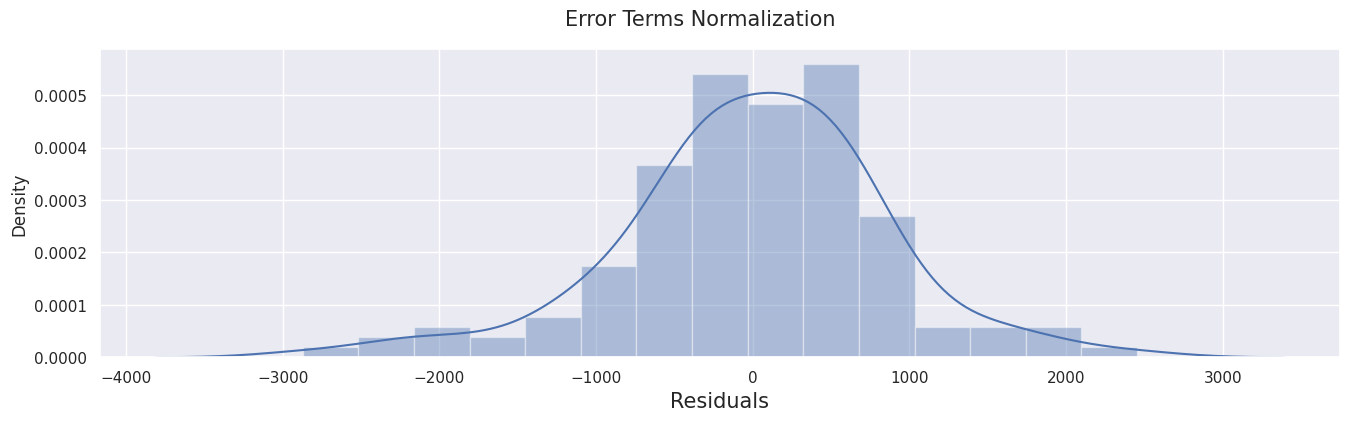

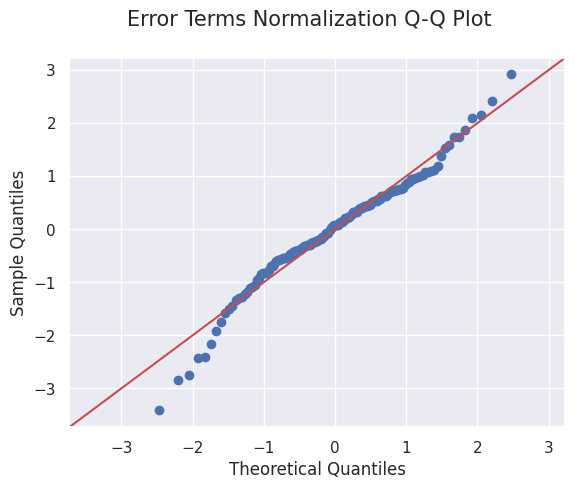

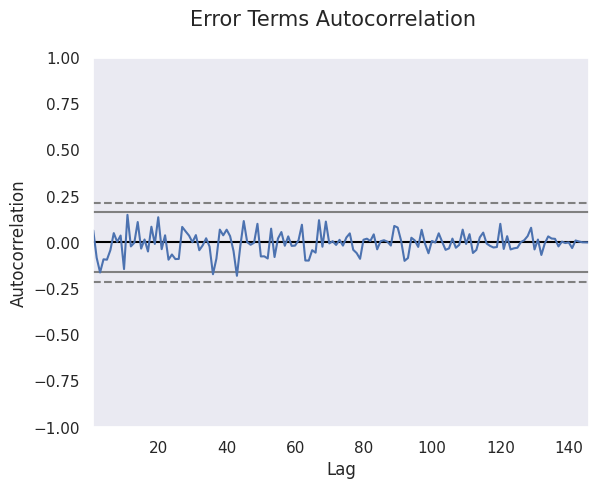

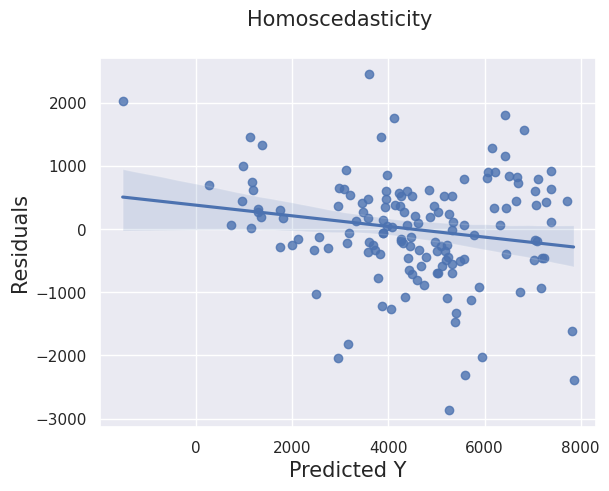


================= Evaluation Table Original Data ===================
+-------+------------+
|  R2   |    MSE     |
+=======+============+
| 0.792 | 707411.510 |
+-------+------------+
       Feature  Chosen  Rank
0          Aug    True     1
26   windspeed    True     1
25   wednesday    True     1
24     tuesday    True     1
23   thurseday    True     1
22      sunday    True     1
21      summer    True     1
20      spring    True     1
18  ratio_temp    True     1
17      monday    True     1
16        mist    True     1
15  light_rain    True     1
27      winter    True     1
14         hum    True     1
12         day    True     1
11       atemp    True     1
10         Sep    True     1
9          Oct    True     1
8          Nov    True     1
7          May    True     1
6          Mar    True     1
5          Jun    True     1
4         July    True     1
3          Jan    True     1
2          Feb    True     1
1          Dec    True     1
13     holiday    True     1
28 

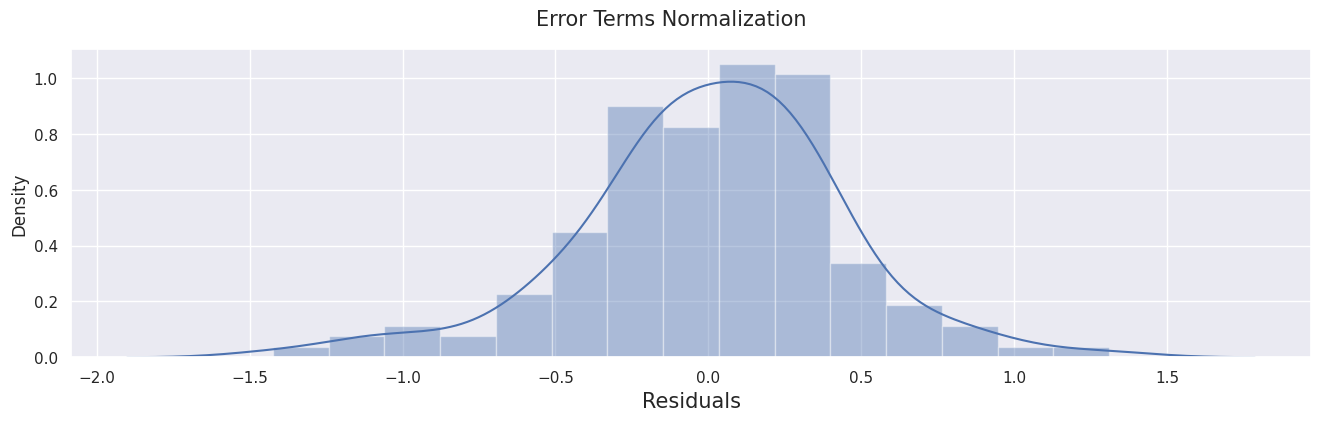

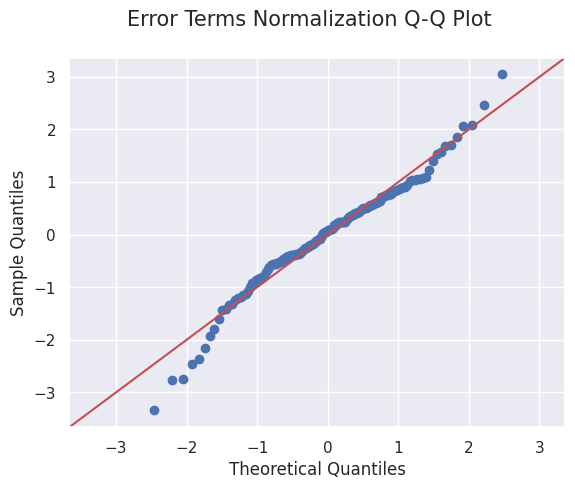

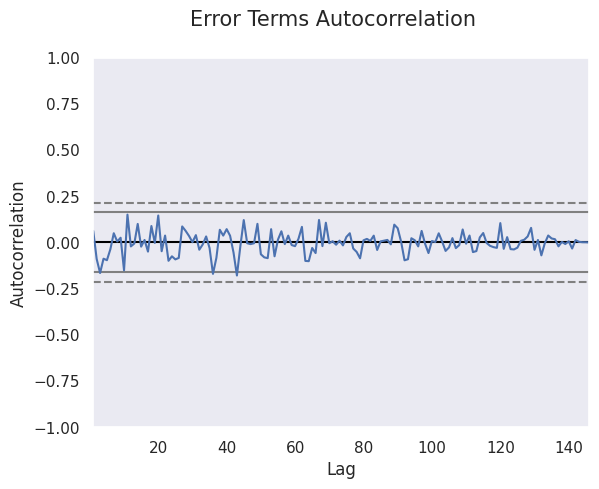

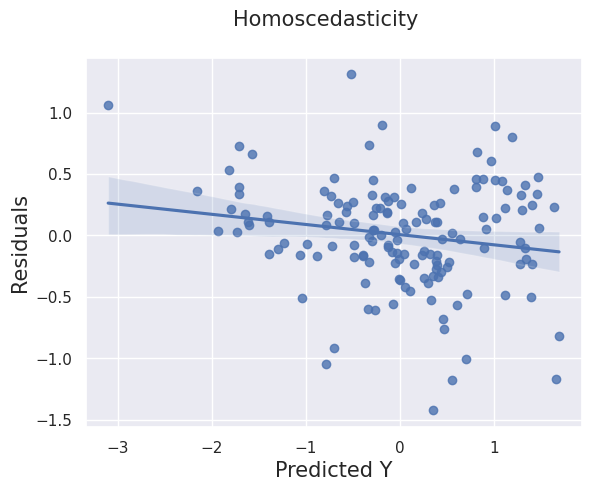


================= Evaluation Table Standardised Data ===================
+-------+-------+
|  R2   |  MSE  |
+=======+=======+
| 0.793 | 0.180 |
+-------+-------+


In [52]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500000})'''))

xDict = {"Temprature Ratio":"ratio_temp", "Feeling of Temprature in Celsius":"atemp",
          "Wind Speed":"windspeed", "Humidity":"hum", "Day of the Month":"day"}

yDict = {"Total number of users":"cnt"}

for j in yDict.keys():

    x = list(xDict.values()) + dummy_vars
    x = list(set(x)-set(["sunday", "holiday"]))
    y = yDict[j]

    n = 27

    print(f"********************************************************************")

    lm = LinearRegression()
    lm = lm.fit(df_train[x], df_train[y])

    rfe = RFE(lm, n_features_to_select=n)
    rfe = rfe.fit(df_train[x], df_train[y])

    print(pd.DataFrame(list(zip(x ,rfe.support_,rfe.ranking_)), columns=["Feature", "Chosen", "Rank"]).sort_values("Rank"))

    col = df_train[x].columns[rfe.support_]
    # print(col)

    x_train_sm = sm.add_constant(df_train[col])
    lr = sm.OLS(df_train[y], x_train_sm).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train[col], df_train[y])

    y_pred = lm.predict(df_test[col])
    ytest = df_test[y].reset_index(drop=True)

    predDF = pd.DataFrame(y_pred)
    predDF.columns=["pred"]
    predDF["res"] = ytest - predDF["pred"]

    print("Features that has been Removed", df_train[x].columns[~rfe.support_].tolist())

    print(f"\n================= Summary Original Data  ===================")
    print(lr.summary())

    print(f"\n================= Linear Assumption test Original Data ===================")

    residualAnalusis(lr, predDF, f"Original Data")

    print(f"\n================= Evaluation Table Original Data ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())

    # ========================================================================================
    n=28
    x = list(xDict.values()) + dummy_vars
    x = list(set(x)-set(["workingday"]))

    lm_sd = LinearRegression()
    lm_sd = lm_sd.fit(df_train_sd_dummy[x], df_train_sd_dummy[y])

    rfe_sd = RFE(lm_sd, n_features_to_select=n)
    rfe_sd = rfe_sd.fit(df_train_sd_dummy[x], df_train_sd_dummy[y])

    print(pd.DataFrame(sorted(list(zip(x ,rfe_sd.support_,rfe_sd.ranking_))), columns=["Feature", "Chosen", "Rank"]).sort_values("Rank"))

    col = df_train_sd_dummy[x].columns[rfe_sd.support_]

    x_train_sm_sd = sm.add_constant(df_train_sd_dummy[col])
    lr_sd = sm.OLS(df_train_sd_dummy[y], x_train_sm_sd).fit()

    lm = LinearRegression()
    lm = lm.fit(df_train_sd_dummy[col], df_train_sd_dummy[y])

    y_pred = lm.predict(df_test_sd_dummy[col])
    ytest = df_test_sd_dummy[y].reset_index(drop=True)

    predDF_sd = pd.DataFrame(y_pred)
    predDF_sd.columns=["pred"]
    predDF_sd["res"] = ytest - predDF_sd["pred"]

    # print("Features that has been Removed", df_train_dummy_sd[x].columns[rfe.support_].tolist())
    # print("Features that has been Removed", df_train_sd_dummy[x].columns[~rfe.support_].tolist())

    print(f"\n================= Summary Standardised Data =================")
    print(lr_sd.summary())

    print(f"\n================= Linear Assumption test Standardised Data ===================")

    residualAnalusis(lr_sd, predDF_sd, f"Standardised Data")

    print(f"\n================= Evaluation Table Standardised Data ===================")
    mse = round(mean_squared_error(ytest, y_pred), 2)
    r2 = round(r2_score(ytest, y_pred), 3)

    t = Texttable()
    t.add_rows([['R2', 'MSE'], [r2, mse]])
    print(t.draw())



if we also remove the feature identified by VIF as the highly redundant with high p-value. then RFE would identify day as un important feature for original data so all other features with the exception of [day, holiday and sunday] are important for prediction and prediction R2 improved by 1% while the MSE has been reduced from the time we just used RFE and has been increased from the time we just used VIF. Prediction R2 is also reduced 2% from the time we just used VIF.

For standardised data, RFE find sunday as being removed in addition to workingday identified by VIF. and Adjusted R2 improved by 1% while the predicted R2 or MSE stayed the same.


So the best model we can get is the model using original data when  holiday and sunday been removed. In this model yr and light-rain are identify as the most important factors with coefficients <-1 for arin and >1 for year that negatively affect the rental of the bikes.